# Sports memory data

## Parts of this notebook:
1. Characterize responses overall in terms of space/time.
2. Read in play-by-play data + win probability information from 'NBAplaybyplay.ipynb' output.
3. Read in our sports memory data and plot surprise and other attributes for play, game, and season memories.

In [7]:
import io
import time
import math
import requests
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.stats as sss
from copy import deepcopy
from datetime import date
from matplotlib import cm
from datetime import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.stats import pearsonr,ttest_ind,ttest_rel,mannwhitneyu
fs,fsz,lw,msz=33,10,5,10 #presets for plotting
plt.rcParams.update({'font.size': fs*2/3})
pd.set_option('display.max_rows',400)

In [ ]:
#characterize responses in terms of time and geolocation
nba3=['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW',
      'HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN','NOP','NYK',
      'OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WSH'] #quick 3-letter NBA codes
szns=18 #seasons for which we have PBP data
szn_f=2004 #first season
t_sec=4*12*60 #seconds in regulation game
#read in all dataframes from worksheet output
#plays
dfp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Play',header=1) #read in data
dfp=dfp[~dfp['Year'].isna()]
#all, including ones we couldn't identify
dfp=dfp[dfp['NCAAM/W/NBA/WNBA (1-4)']==3] #enforce NBA + ones we could identify
dfn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Play',header=1)
dfn=dfn[~dfn['Year'].isna()]
dfn=dfn[dfn['NCAAM/W/NBA/WNBA (1-4)']==3]
#games
dfgp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Game',header=1)
dfgp=dfgp[~dfgp['Year'].isna()]
dfgp=dfgp[dfgp['NCAAM/W/NBA/WNBA (1-4)']==3]
dfgn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Game',header=1)
dfgn=dfgn[~dfgn['Year'].isna()]
dfgn=dfgn[dfgn['NCAAM/W/NBA/WNBA (1-4)']==3]
#season
dfsp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Seasonpseason',header=1) #read in data
dfsp=dfsp[~dfsp['Year'].isna()]
dfsp=dfsp[dfsp['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsp=dfsp[dfsp['Cheering FOR this team (1) or AGAINST them (-1)']==1]
dfsn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Seasonpseason',header=1)
dfsn=dfsn[~dfsn['Year'].isna()]
dfsn=dfsn[dfsn['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsn=dfsn[dfsn['Cheering FOR this team (1) or AGAINST them (-1)']==1]

#basic data about odds and records
df_svr=pd.read_excel('Sports memory rubric.xlsx',sheet_name='SeasonsVsRecords',header=0) #read in data
df_ots=pd.read_excel('Sports memory rubric.xlsx',sheet_name='OddsThroughSeason',header=0)
df_svr=df_svr[:-len(nba3)] #cut off 2021-2022
df_ots=df_ots[:-len(nba3)]

print('# pos play entries: %s' %len(dfp))
print('# neg play entries: %s' %len(dfn))
print('# pos game entries: %s' %len(dfgp))
print('# neg game entries: %s' %len(dfgn))
print('# pos szn entries: %s' %len(dfsp))
print('# neg szn entries: %s' %len(dfsn))

In [ ]:
#find team indices for pos/neg play games
all_i=[]
npp,npn=len(dfp),len(dfn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((npp)),np.zeros((npp)),np.zeros((npn)),np.zeros((npn))
dfp=dfp.astype({'Month/date':'str'})
dfp=dfp.astype({'Study date':'str'})
dfn=dfn.astype({'Month/date':'str'})
dfn=dfn.astype({'Study date':'str'})
for ha in range(2):
    for i in range(npp):
        if ha==0:
            v_i_p[i]=nba3.index(dfp['Visiting team'][dfp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfp['Home team'][dfp.index[i]][:3])
    for i in range(npn):
        if ha==0:
            v_i_n[i]=nba3.index(dfn['Visiting team'][dfn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfn['Home team'][dfn.index[i]][:3])
dfp['home'],dfp['vis'],dfn['home'],dfn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([h_i_p,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

dfgp=dfgp.astype({'Month/date':'str'})
dfgp=dfgp.astype({'Study date':'str'})
dfgn=dfgn.astype({'Month/date':'str'})
dfgn=dfgn.astype({'Study date':'str'})
ngp,ngn=len(dfgp),len(dfgn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngn)),np.zeros((ngn))
for ha in range(2):
    for i in range(ngp):
        if ha==0:
            v_i_p[i]=nba3.index(dfgp['Visiting team'][dfgp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfgp['Home team'][dfgp.index[i]][:3])
    for i in range(ngn):
        if ha==0:
            v_i_n[i]=nba3.index(dfgn['Visiting team'][dfgn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfgn['Home team'][dfgn.index[i]][:3])
dfgp['home'],dfgp['vis'],dfgn['home'],dfgn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

nsp,nsn=len(dfsp),len(dfsn)
dfsp['Year'],dfsn['Year']=dfsp['Year'].astype(str),dfsn['Year'].astype(str)
dfsp=dfsp.astype({'Study date':'str'})
dfsn=dfsn.astype({'Study date':'str'})
h_i_p,h_i_n=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    h_i_p[i]=nba3.index(dfsp['Team'][dfsp.index[i]][:3])
for i in range(nsn):
    h_i_n[i]=nba3.index(dfsn['Team'][dfsn.index[i]][:3])
dfsp['home'],dfsn['home']=h_i_p,h_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,h_i_n])

In [ ]:
qq=np.linspace(-0.5,len(nba3)-0.5,len(nba3)+1)
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(all_i,bins=qq,linewidth=lw/2,color='k',ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Team',fontsize=fs*4/5)
ax.set_xticks(np.linspace(0,len(nba3)-1,len(nba3)))
ax.set_xticklabels(nba3,rotation=90,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/response_across_teams.pdf', transparent=True)
print(histo[0])
print('# GSW entries:',int(histo[0][9]),'; # LAL entries:',int(histo[0][13]))

33.7
84.3
3719673.311518167
1038427.1220274589


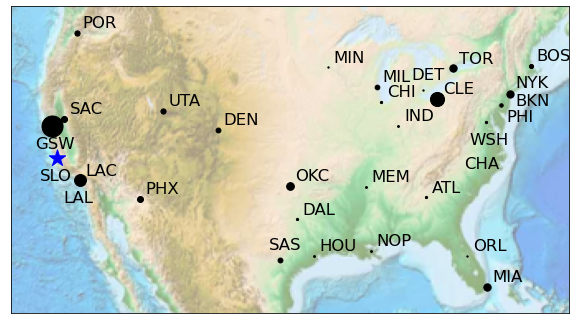

In [258]:
#https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
dfgeo = pd.read_excel('Sports memory rubric.xlsx',sheet_name='Geolocation',header=0) #read in data

f = plt.figure(figsize=(fsz,fsz))
mstyle=1
if mstyle==1:
    m=Basemap(projection='aea', resolution=None,width=5E6, height=2.75E6,lat_0=37.5, lon_0=-97.5,)
    m.etopo(scale=0.5, alpha=0.5)
elif mstyle==2:
    m=Basemap(llcrnrlon=-120,llcrnrlat=23,urcrnrlon=-65,urcrnrlat=47,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcountries()
    m.drawstates()
    m.drawcoastlines()

for i in range(len(dfgeo)):
    tn,lat,lon=dfgeo['Team'][i],dfgeo['Latitude'][i],dfgeo['Longitude'][i]
    lat,lon=float(lat[:4]),float(lon[:4])
    x,y=m(-lon,lat)
    if i==0:
        print(lat)
        print(lon)
        print(x)
        print(y)
    fact=50000
    #plt.plot(x,y,'ok',markersize=msz)
    plt.scatter(x,y,c='k',s=histo[0][i]*1.7)
    if np.logical_or(np.logical_or(tn=='GSW',tn=='WSH'),tn=='LAL'):
        plt.text(x-fact*3,y-fact*4,tn,fontsize=fs/2)
    elif np.logical_or(tn=='SAS',tn=='DET'):
        plt.text(x-fact*2,y+fact*2,tn,fontsize=fs/2)
    elif tn=='PHI':
        plt.text(x+fact,y-fact*3,tn,fontsize=fs/2)
    elif tn=='BKN':
        plt.text(x+fact,y-fact*2,tn,fontsize=fs/2)
    else:
        plt.text(x+fact,y+fact,tn,fontsize=fs/2)

x,y=m(-120.7,35.3)
plt.scatter(x,y,c='b',marker='*',s=300)#add San Luis Obispo
plt.text(x-fact*3,y-fact*4,'SLO',fontsize=fs/2)
plt.show()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/geo_data.pdf', transparent=True)

['2004-2005', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']


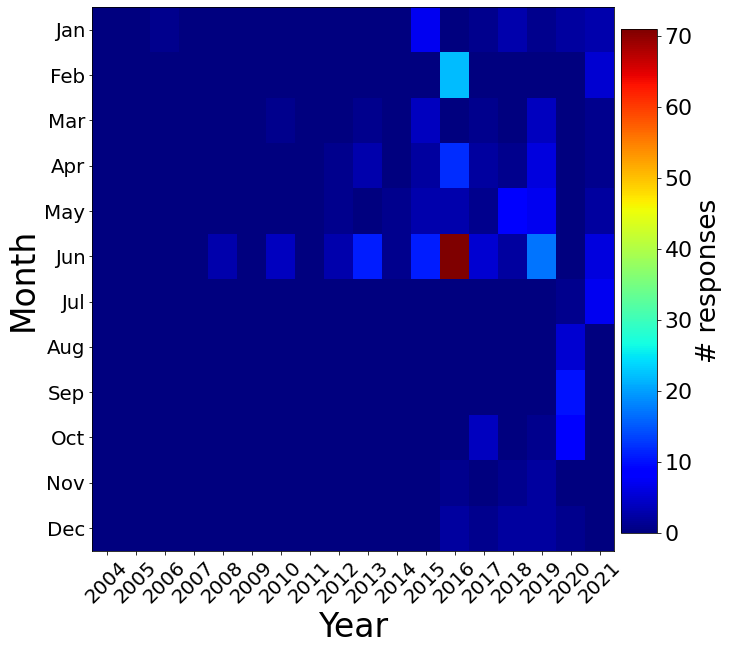

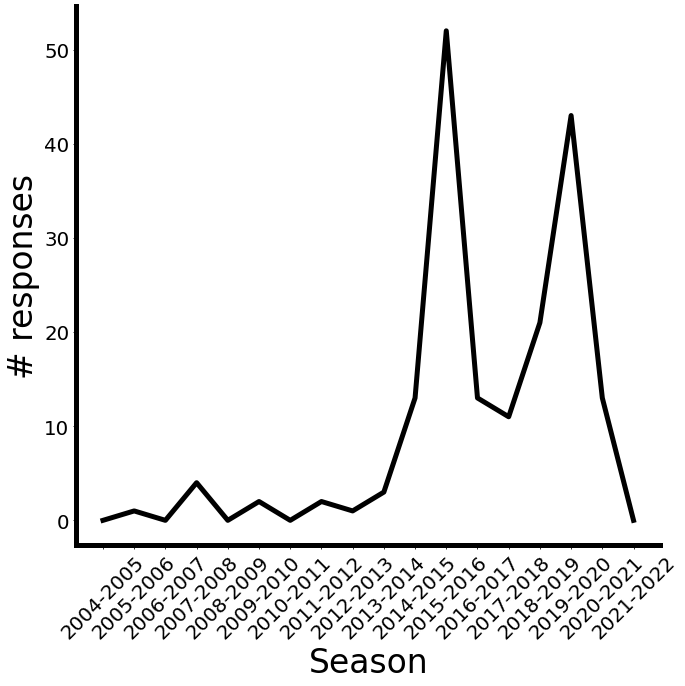

In [259]:
#characterize month/date/year of game
mos=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
szn_nms=np.linspace(szn_f,szn_f+szns-1,szns).astype(int)
szn_nms2=[]
for i in range(szns):
    szn_nms2.append(str(szn_f+i)+'-'+str(szn_f+i+1))
print(szn_nms2)
y_m_ind,y_ind_szn,mem_ages,szn_mem_ages=np.zeros((szns,12)),np.zeros((szns)),[],[]
for i in range(npp):
    y_ind=int(dfp['Year'][dfp.index[i]])
    m_ind=int(dfp['Month/date'][dfp.index[i]][5:7])
    d_ind=int(dfp['Month/date'][dfp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfp['Study date'][dfp.index[i]][:4])
    m_ind_s=int(dfp['Study date'][dfp.index[i]][5:7])
    d_ind_s=int(dfp['Study date'][dfp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(npn):
    y_ind=int(dfn['Year'][dfn.index[i]])
    m_ind=int(dfn['Month/date'][dfn.index[i]][5:7])
    d_ind=int(dfn['Month/date'][dfn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfn['Study date'][dfn.index[i]][:4])
    m_ind_s=int(dfn['Study date'][dfn.index[i]][5:7])
    d_ind_s=int(dfn['Study date'][dfn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngp):
    y_ind=int(dfgp['Year'][dfgp.index[i]])
    m_ind=int(dfgp['Month/date'][dfgp.index[i]][5:7])
    d_ind=int(dfgp['Month/date'][dfgp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgp['Study date'][dfgp.index[i]][:4])
    m_ind_s=int(dfgp['Study date'][dfgp.index[i]][5:7])
    d_ind_s=int(dfgp['Study date'][dfgp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngn):
    y_ind=int(dfgn['Year'][dfgn.index[i]])
    m_ind=int(dfgn['Month/date'][dfgn.index[i]][5:7])
    d_ind=int(dfgn['Month/date'][dfgn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgn['Study date'][dfgn.index[i]][:4])
    m_ind_s=int(dfgn['Study date'][dfgn.index[i]][5:7])
    d_ind_s=int(dfgn['Study date'][dfgn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(nsp):
    y_ind=int(dfsp['Year'][dfsp.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsp['Study date'][dfsp.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
for i in range(nsn):
    y_ind=int(dfsn['Year'][dfsn.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsn['Study date'][dfsn.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
    
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
im=ax.imshow(y_m_ind.T,interpolation='none',aspect='auto',cmap='jet')
ax.set_ylabel('Month',fontsize=fs)
ax.set_xlabel('Year',fontsize=fs)
ax.set_yticks(np.linspace(0,len(mos)-1,len(mos)))
ax.set_yticklabels(mos,fontsize=fs*0.6)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms, rotation = 45,fontsize=fs*0.6)
f.subplots_adjust(right=0.85) #adjust so we can add colorbar
cbar_ax = f.add_axes([0.86, 0.15, 0.05, 0.7])
cbar=f.colorbar(im, cax=cbar_ax)
cbar.set_label('# responses',fontsize=fs*0.8)
#f.tight_layout()
f.savefig('figs/time_playgame.pdf', transparent=True)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(y_ind_szn,'k',linewidth=lw)
ax.set_ylabel('# responses',fontsize=fs)
ax.tick_params(axis='y',labelsize=fs*0.6)
ax.set_xlabel('Season',fontsize=fs)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms2, rotation = 45,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#f.subplots_adjust(right=0.8) #adjust so we can add colorbar
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/time_season.pdf', transparent=True)

[19. 20.  2. 12.  3. 17.  8. 11. 10.  2.  9.  4.  7.  4. 34. 31. 29. 15.
 15.  7.  4.  3.  0.  0.  8.  3.  3.  3.  1.  2.  0.  0.  0.  0.  3.  2.
  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


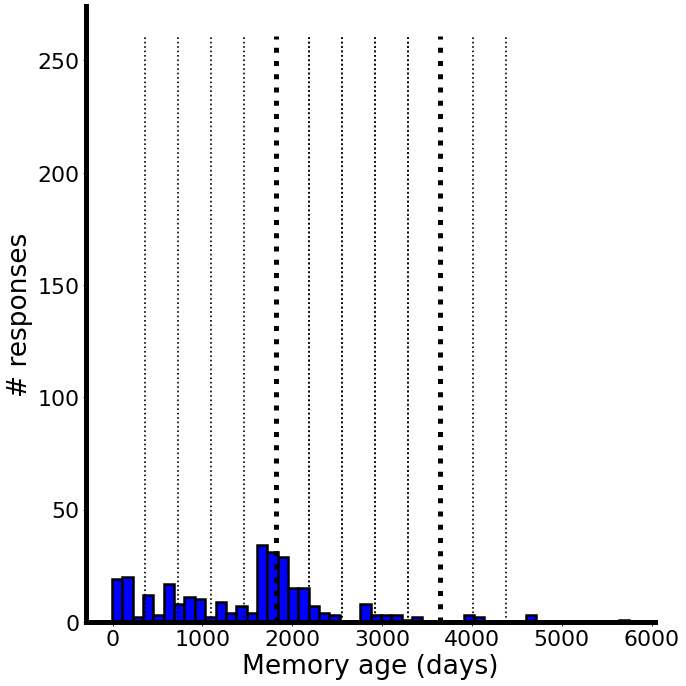

In [260]:
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
#line for every year + darker every 5
plt.vlines(365*5,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(365*10,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365,365*4,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*11,365*12,2),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
histo=plt.hist(mem_ages,bins=50,linewidth=lw/2,ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (days)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages.pdf', transparent=True)
print(histo[0])

(array([13., 43., 21., 11., 13., 52., 13.,  3.,  1.,  2.,  0.,  2.,  0.,
        4.,  1.]), array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.]), <a list of 15 Patch objects>)


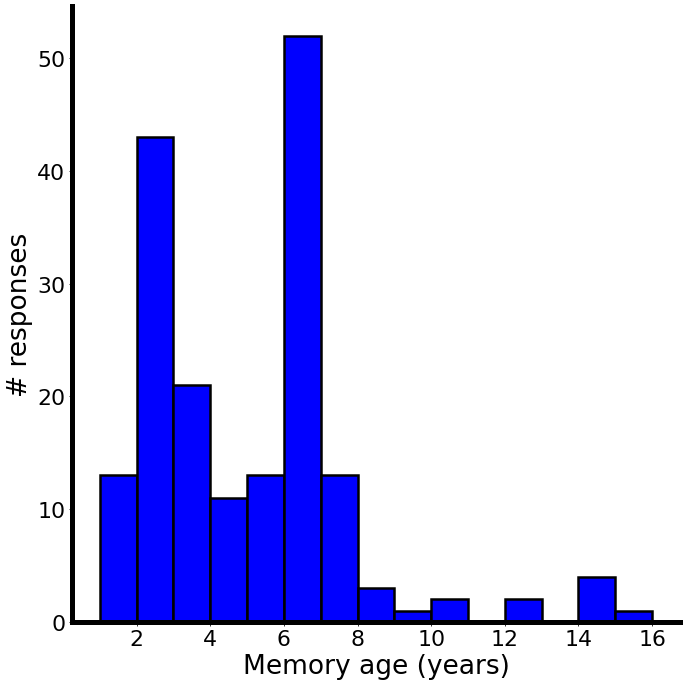

In [261]:
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(szn_mem_ages,linewidth=lw/2,ec='black',bins=15)
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (years)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages_szn.pdf', transparent=True)
print(histo)

# 1. Load play-by-play data & plot basics

In [262]:
allsurs=np.load('pydata/allsurs.npy')
mwwps=np.load('pydata/mwwps.npy')
mwwp_ts=np.load('pydata/mwwp_ts.npy')
maxsurs=np.load('pydata/maxsurs.npy')
df1=pd.read_csv('pydata/df1.csv')
fwwps=np.load('pydata/fwwps.npy')
secB=np.load('pydata/secB.npy')
print(df1[:2])

qq=np.where(abs(allsurs)<0.01)
lil_i=len(qq[0])/len(allsurs)
print('% plays with <1% impact on game:',lil_i)

qq=np.where(abs(allsurs)<0.05)
lil_i5=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',lil_i5)

qq=np.where(abs(allsurs)>0.25)
big_i=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',big_i)

       g_id         g_d    sl  sdiff  hp  home  vis  hw  sl_ot  year  month  \
0  40400407  2005-06-23  2880      0   0    26    8   1   2880  2005      6   
1  40400407  2005-06-23  2880      0   1    26    8   1   2880  2005      6   

   day  sdiff_adj       hwp      mwwp       sur     fgsur     wgsur    maxsur  \
0   23          4  0.702929  0.319512       NaN  0.297071  0.680488  0.098775   
1   23          4  0.702634  0.319512 -0.000295  0.297071  0.680488  0.098775   

   mwwp_t  
0  1184.0  
1  1184.0  
% plays with <1% impact on game: 0.34608928886236845
% plays with <5% impact on game: 0.8253828535453367
% plays with <5% impact on game: 0.0009720825247366121


In [263]:
sur_v=df1['sur']
sl_ot_v=df1['sl_ot']
sur_bm,sur_bs=np.zeros((len(secB)-1)),np.zeros((len(secB)-1))
for i in range(len(secB)-1):
    if i==0:
        qq=np.where(np.logical_and(sl_ot_v<=secB[i],sl_ot_v>=secB[i+1]))[0]
    else:
        qq=np.where(np.logical_and(sl_ot_v<secB[i],sl_ot_v>=secB[i+1]))[0]
    if i==0:
        print(sur_v[qq])
    sur_bm[i]=np.nanmean(np.absolute(sur_v[qq]))
    sur_bs[i]=np.nanstd(np.absolute(sur_v[qq]))

0               NaN
1         -0.000295
208             NaN
427             NaN
428       -0.000006
             ...   
5682754   -0.002254
5683053         NaN
5683054   -0.000006
5683313         NaN
5683314   -0.001125
Name: sur, Length: 45133, dtype: float64


a: 1.2857767970955867e-06, b: 0.025939052211879393
r-squared =  0.1753776345619509
a: -0.0072136873527133705, b: 0.07739103776433245
r-squared =  0.8161658384543994


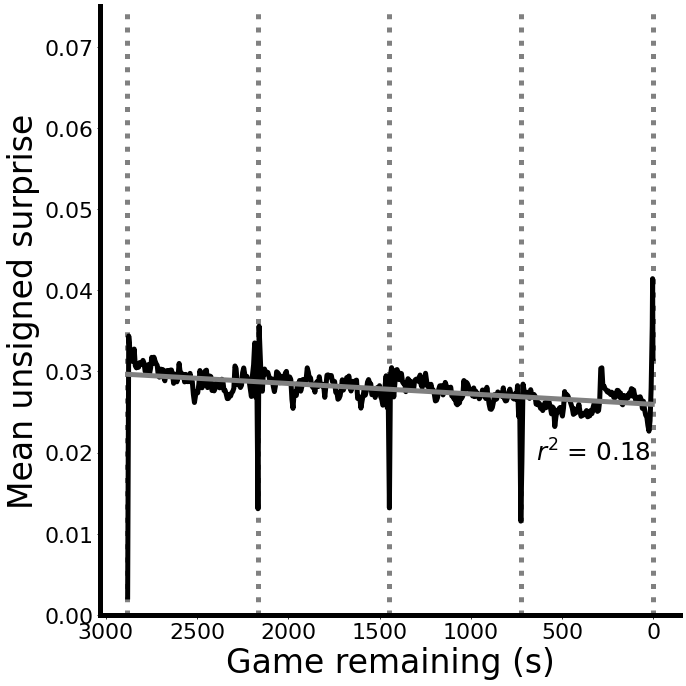

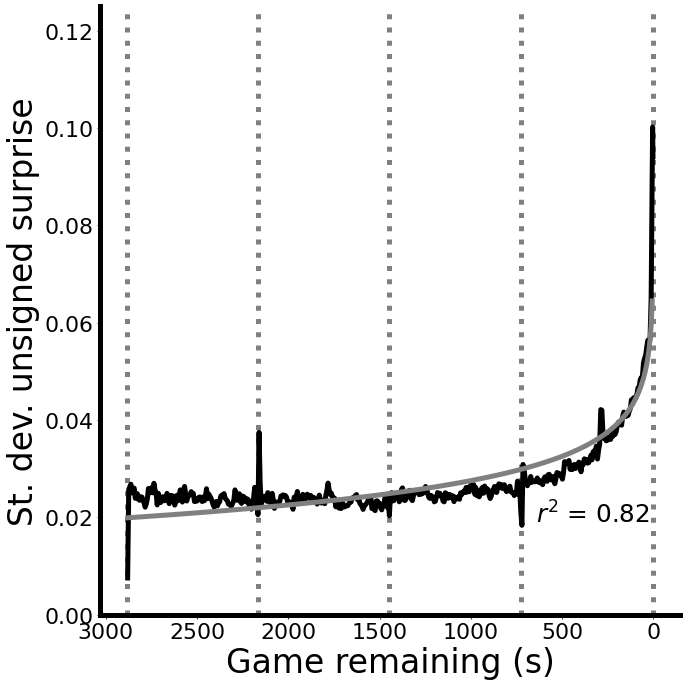

In [264]:
def plot_sur_att(x,y,fitt,ymx,yl,sn):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    bf,bsz=-2,6 #bin size
    #x,y=secB[:-1],sur_bm
    if fitt==1:
        xf=x+0
    else:
        xf=np.log(x)
    a,b=np.polyfit(xf,y,1)
    corr, _ = pearsonr(xf,y)
    print('a: %s, b: %s' %(a,b))
    print('r-squared = ',corr**2)
    plt.plot(x,y,'k',linewidth=lw)
    plt.plot(x[:bf], a*xf[:bf]+b,'gray',linewidth=lw)
    ax.invert_xaxis()
    ax.set_ylabel(yl,fontsize=fs)
    ax.set_xlabel('Game remaining (s)',fontsize=fs)
    ax.set_ylim(0,ymx)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(t_sec/4-75,0.019,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*3/4,color='k')
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    plt.vlines([t_sec+bsz,t_sec*3/4+bsz,t_sec/2+bsz,t_sec/4+bsz,0],0,ymx,linewidth=lw,colors='gray',linestyles='dotted')
    f.tight_layout()
    f.savefig(sn, transparent=True)
    
plot_sur_att(secB[:-1],sur_bm,1,0.075,'Mean unsigned surprise','figs/surprise_mean.pdf')
plot_sur_att(secB[:-1],sur_bs,2,0.125,'St. dev. unsigned surprise','figs/surprise_stdev.pdf')

In [265]:
#### maybe make ax2 w/ histplot? 
def kdeplotf(dat,dat2,dat3,xl,xlim,fn,exv):
    #exv is an extra variable to adjust one thing or another
    fs,binn,legg,lw2,bwa=25,120,[],5,1.333
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    if xlim[0]<xlim[1]:
        binns=np.linspace(xlim[0],xlim[1],binn+1)
    else:
        binns=np.linspace(xlim[1],xlim[0],binn+1)
    if len(dat3)>0:
        sns.kdeplot(dat,color='k',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat2,color='b',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat3,color='r',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='k')
        #sns.histplot(dat2,color='b',linewidth=lw2,bins=binns)
        #sns.rugplot(dat2,color='b')
        #sns.rugplot(dat3,color='r')
        #sns.histplot(dat3,color='r',linewidth=lw2,bins=binns)
        legg=['All','Positive','Negative']
        if exv==2:
            legg[0]='''All, 
same game'''
        elif exv==3:
            legg[0]='''All, 4Q of 
same game'''
        elif exv==6:
            legg[0]='''All, 4Q of 
same game'''
    elif len(dat2)>0:
        sns.kdeplot(dat,color='b',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat2,color='r',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='b')
        #sns.histplot(dat,color='b',linewidth=lw2,bins=binns,kde=True)
        #sns.rugplot(dat2,color='r')
        #sns.histplot(dat2,color='r',linewidth=lw2,bins=binns,kde=True)
        legg=['Positive','Negative']
    else:
        sns.kdeplot(dat,color='k',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='k')
    ax.set_ylabel('Density',fontsize=fs*5/4)
    ax.set_xlabel(xl,fontsize=fs*5/4)
    ax.set_xlim(xlim)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if len(legg)>0:
        if exv!=5:
            ax.legend(legg,ncol=1,loc='upper left',fontsize=fs) #,frameon=False
        if exv==4:
            ax.legend(legg,ncol=1,loc='upper center',fontsize=fs)
        #elif exv==5:
        #    ax.legend(legg,ncol=3,loc='upper center',fontsize=fs)
        elif exv==6:
            ax.legend(legg,ncol=1,loc='upper right',fontsize=fs)
    if exv==1: #plot vertical lines to demarcate quarters / OT periods
        ymin, ymax = ax.get_ylim()
        plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0,-(5*60)],ymin,ymax,
                   linewidth=lw,colors='k',linestyles='dotted')
        ax.set_ylim([ymin, ymax])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    if len(fn)>0:
        f.tight_layout()
        f.savefig(fn, transparent=True)

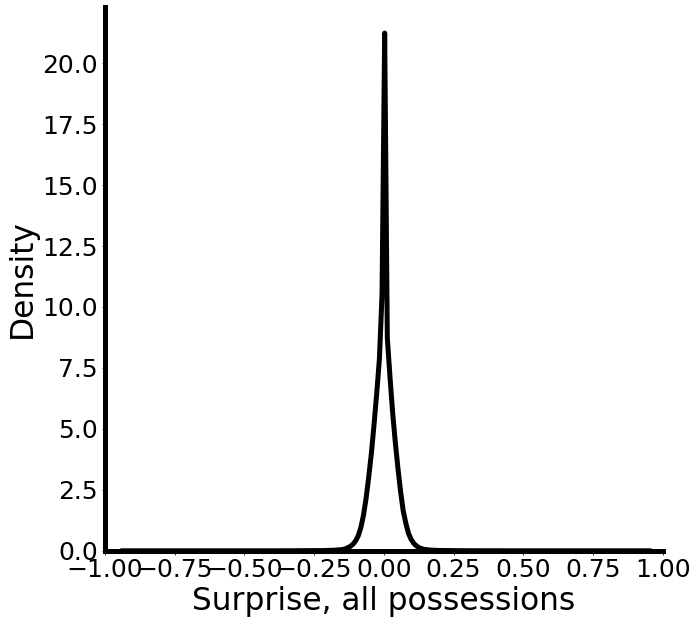

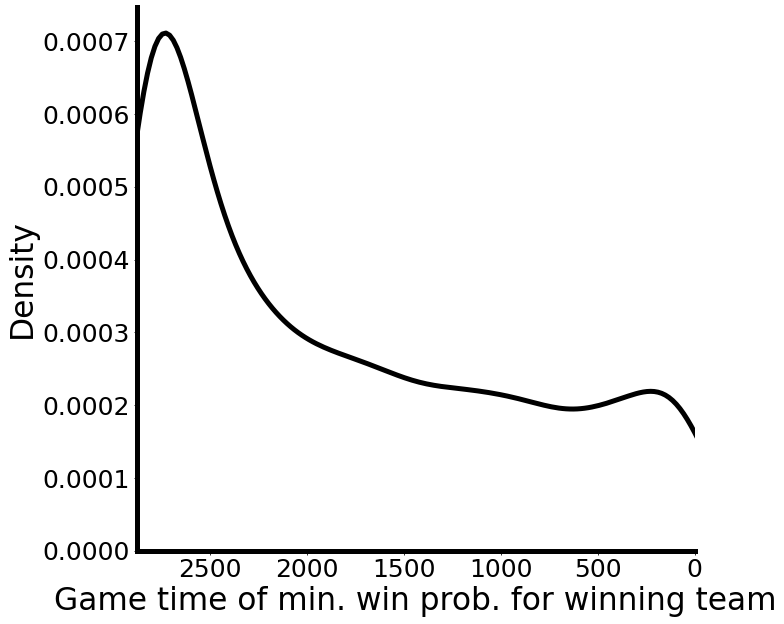

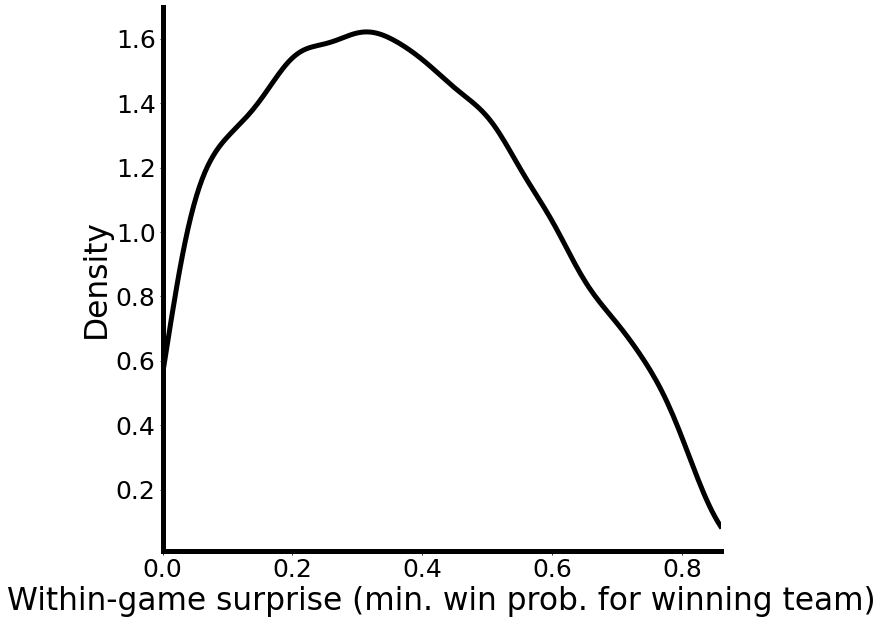

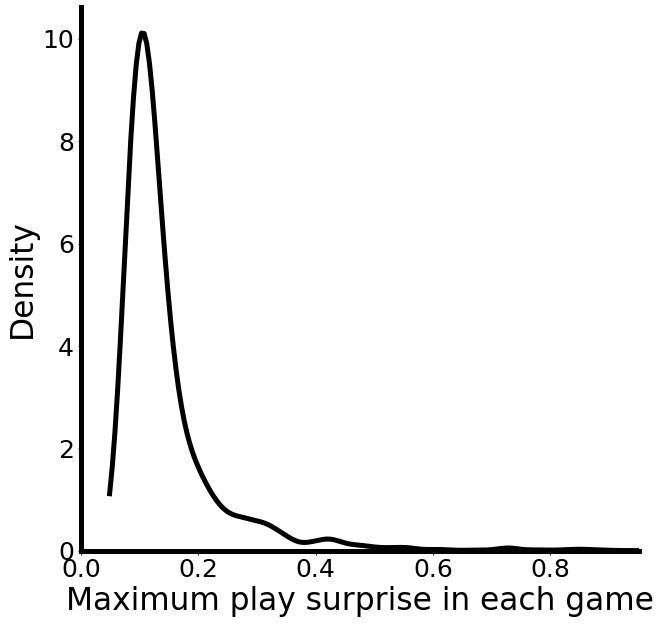

In [266]:
##possession level
kdeplotf(allsurs,[],[],'Surprise, all possessions',[-1,1],'figs/all_surs.pdf',0)
##game level
kdeplotf(mwwp_ts[:,0],[],[],'Game time of min. win prob. for winning team',[t_sec,0],
         'figs/all_comeback_times.pdf',0)
kdeplotf(mwwps[:,0],[],[],'Within-game surprise (min. win prob. for winning team)',[0,np.max(mwwps)],
         'figs/all_comebacks.pdf',0)
kdeplotf(maxsurs[:,0],[],[],'Maximum play surprise in each game',[0,np.max(maxsurs)],
         'figs/max_play_sur_game.pdf',0)

prior: 0.7650933040614709
max: 0.8434782608695652
last 100: [0.         0.01603376 0.01603376 0.01603376 0.01603376 0.01603376
 0.01603376 0.01603376 0.01603376 0.01603376 0.03341149 0.03341149
 0.03341149 0.03341149 0.03341149 0.03341149 0.03341149 0.03341149
 0.03341149 0.03341149 0.03341149 0.05369128 0.05369128 0.05369128
 0.05369128 0.05369128 0.05369128 0.05369128 0.05369128 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.46091015
 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015
 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015
 0.46091015 0.46091015 0.46091015 0.49075216 0.49075216 0.49075216
 0.49075216 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414
 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414
 0

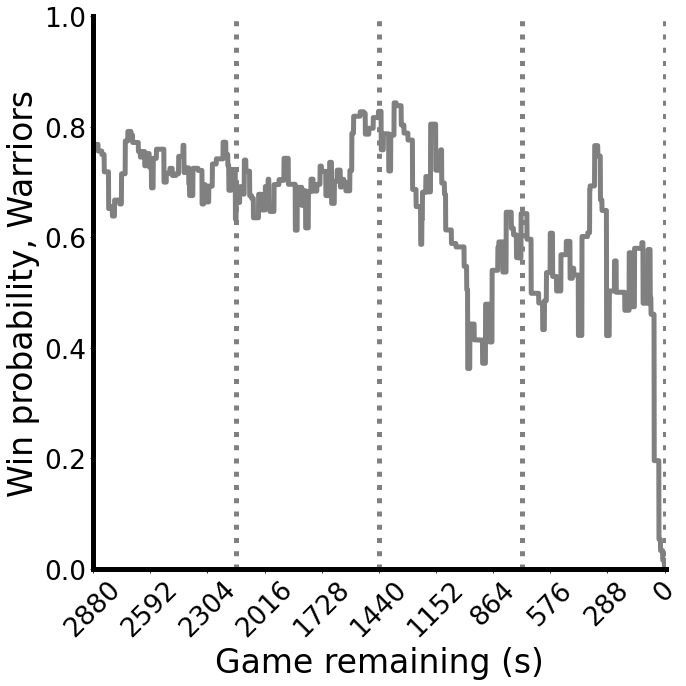

In [267]:
#plot one game - Cavs-Warriors 2016-06-19
qq=np.where(np.logical_and(np.logical_and(df1['year']==2016,df1['month']==6),df1['day']==19))[0]
sec_ds=df1['sl'][df1.index[qq]].values
wp_ds=df1['hwp'][df1.index[qq]].values
sec_ex,wp_ex=np.linspace(0,t_sec,t_sec+1),np.zeros((t_sec+1))
for i in range(len(wp_ds)-1):
    wp_ex[sec_ds[i+1]:sec_ds[i]]=wp_ds[i]
wp_ex[0],wp_ex[-1]=0,wp_ds[0]

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(sec_ex,wp_ex,'gray',linewidth=lw)
ax.set_ylabel('Win probability, Warriors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Game remaining (s)',fontsize=fs)
ax.set_xticklabels(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int), rotation = 45,fontsize=fs*4/5)
ax.set_xticks(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int))
ax.set_xlim([-5,t_sec])
ax.invert_xaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0],0,1,linewidth=lw,colors='gray',linestyles='dotted')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_game.pdf', transparent=True)
print('prior:',wp_ex[-1])
print('max:',np.max(wp_ex))
print('last 100:',wp_ex[:100])

['Oct 1', 'Nov 1', 'Dec 1', 'Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Round 1', 'Round 2', 'Round 3', 'Finals']
[0.05128205 0.08333333 0.11111111 0.11764706 0.09756098 0.08510638
 0.07407407 0.09302326 0.10695187 0.10582011 0.3030303  1.        ]


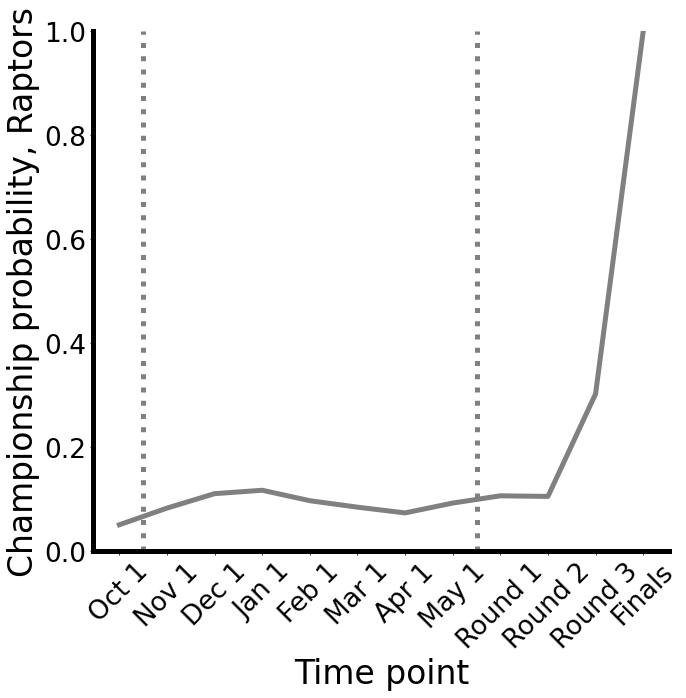

In [268]:
#odds updates
ou=['Oct 1','Nov 1','Dec 1','Jan 1','Feb 1','Mar 1','Apr 1','May 1','Round 1','Round 2','Round 3','Finals']
qq=df_ots.loc[np.logical_and(df_ots['Team']=='TOR',df_ots['Starting year']==2018)]
odds=np.zeros((len(ou)))
odds[:11]=df_ots.loc[df_ots.index==447].values[0][4:15]
odds=100/(100+odds)
odds[11]=1
print(ou)
print(odds)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(odds,'gray',linewidth=lw)
ax.set_ylabel('Championship probability, Raptors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Time point',fontsize=fs)
ax.set_xticks(np.linspace(0,len(ou),len(ou)+1))
ax.set_xticklabels(ou, rotation = 45,fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.vlines([0.5,7.5],0,1,linewidth=lw,colors='gray',linestyles='dotted')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_season.pdf', transparent=True)

# 3. Input data from our study & plot

# First: play data

In [269]:
#defs for reading in data
def findsecs(tstring):
    if isHMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S:%f") #datetime
        a_timedelta = date_time - datetime(1900, 1, 1) #datetime
        #print(a_timedelta)
        seconds = a_timedelta.total_seconds()
        #print(seconds)
        return seconds
    elif isMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S") #datetime
        a_timedelta = date_time # - datetime(1900, 1, 1) #datetime
        seconds = a_timedelta.total_seconds()
        #print(seconds)
        return seconds
def isHMS(input):
    try:
        time.strptime(input, '%H:%M:%S')
        return True
    except ValueError:
        return False
def isMS(input):
    try:
        time.strptime(input, '%M:%S')
        return True
    except ValueError:
        return False

In [270]:
print('# final entries, pos: %s' %npp)
timesp=np.zeros((npp)) #pre-assign empty secs column
for i in range(npp):
    if str(dfp['Game time for possession AFTER play'][dfp.index[i]])!='nan': #BEFORE
        timesp[i]=findsecs(str(dfp['Game time for possession AFTER play'][dfp.index[i]]))
        if dfp['Quarter'][dfp.index[i]]<4: #for regular game, non-4th quarter
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(12*60)
        elif dfp['Quarter'][dfp.index[i]]>4: #for OT
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(5*60)
dfp=dfp.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 
print('# final entries, neg: %s' %npn)
timesn=np.zeros((npn)) #pre-assign empty secs column
for i in range(npn):
    if str(dfn['Game time for possession AFTER play'][dfn.index[i]])!='nan':
        timesn[i]=findsecs(str(dfn['Game time for possession AFTER play'][dfn.index[i]]))
        if dfn['Quarter'][dfn.index[i]]<4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(12*60)
        elif dfn['Quarter'][dfn.index[i]]>4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(5*60)
dfn=dfn.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 

#OT games:separate time being looked up (for alignment w/ data) from the time left (for win probability)
timesp2=deepcopy(timesp)
qq=np.where(timesp<0)[0] #
timesp2[qq]=timesp[qq]+(60*5)
qq=np.where(timesp<0)[0] #repeat in case 2OT
timesp2[qq]=timesp[qq]+(60*5)
timesn2=deepcopy(timesn)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)

#clean up time info and data as ints
m_ind,d_ind=np.zeros((npp)),np.zeros((npp))
for i in range(npp):
    m_ind[i]=dfp['Month/date'][dfp.index[i]][5:7]
    d_ind[i]=dfp['Month/date'][dfp.index[i]][8:10]
dfp['month']=m_ind
dfp['day']=d_ind
dfp['gt']=timesp
dfp['gt2']=timesp2
dfp[['month','day','Year','home','gt','gt2']]=dfp[['month','day','Year','home','gt','gt2']].astype(int)

m_ind,d_ind=np.zeros((npn)),np.zeros((npn))
for i in range(npn):
    m_ind[i]=dfn['Month/date'][dfn.index[i]][5:7]
    d_ind[i]=dfn['Month/date'][dfn.index[i]][8:10]
dfn['month']=m_ind
dfn['day']=d_ind
dfn['gt']=timesn
dfn['gt2']=timesn2
dfn[['month','day','Year','home','gt','gt2']]=dfn[['month','day','Year','home','gt','gt2']].astype(int)

# final entries, pos: 70
# final entries, neg: 74


# find info from game for a given play

In [271]:
#loop over all dfp, matching year/month/day/team
sursp_a,perc_g_surp,perc_g_surp_4q=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
sursp_a_abs,perc_g_surp_abs,perc_g_surp_4q_abs=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
perc_into_sznpp=np.zeros((npp))
for i in range(npp):
    curr_y=dfp['Year'][dfp.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfp['month'][dfp.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfp['day'][dfp.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfp['home'][dfp.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    tdiffs=np.absolute(df1gt['sl']-dfp['gt'][dfp.index[i]]) #match play by finding time diffs, min
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    #sometimes it grabs two within the same second - must check these!
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfp['gt'][dfp.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==4: #fix specific spots w/ multiple plays within a second
        print(df1gt['sur'][df1gt.index[pos_m]])
        pos_m=pos_m[4]
    elif i==8:
        pos_m=pos_m[1]
    elif i==9:
        pos_m=pos_m[1]
    elif i==16:
        pos_m=pos_m[1] 
    else:
        pos_m=pos_m[0] #other cases
    sursp_a[i]=df1gt['sur'][df1gt.index[pos_m]] #relative surprise by the algorithm
    sursp_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) #abs surprise by the algorithm
    pos_4q=np.where(df1gt['sl']<60*12)[0] #grab game events from 4th quarter
    if i==0:
        allgsursp=df1gt['sur'][1:] #all rel surprise values from that game
        allgsursp_4q=df1gt['sur'][df1gt.index[pos_4q]] #all surprise values in last five min
        allgsursp_abs=np.absolute(df1gt['sur'][1:]) #absolute surprise
        allgsursp_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
        allgsursp_4q=np.hstack([allgsursp_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
        allgsursp_4q_abs=np.hstack([allgsursp_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surp[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursp_a[i])
    perc_g_surp_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursp_a[i])
    perc_g_surp_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursp_a_abs[i])
    perc_g_surp_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursp_a_abs[i])
    print('expert sur:%s' %format(dfp['Relative surprise'][dfp.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursp_a[i],".2f"),format(perc_g_surp[i],".2f"),format(perc_g_surp_4q[i],".2f"),))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursp_a_abs[i],".2f"),format(perc_g_surp_abs[i],".2f"),format(perc_g_surp_4q_abs[i],".2f"),))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    #late part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #combine df of all updates in this season!
    ids_tszn=df1szn.g_id.unique() #find unique games
    perc_into_sznpp[i]=stats.percentileofscore(ids_tszn,curr_g_id) #all in order by g_id so find %ile
    print('\n')

Year, month, date, home:2015,6,14,9
rows, rows, rows, rows:362147,1540,243,243
game time, RAs:453;pbp:3240049    453
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:0.13,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.13,99.59,98.46


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 1
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:39: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=df1gt['sur'][1:] #all rel surprise values from that game
<ipython-input-271-4c28ae6b9e81>:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.absolute(df1gt['sur'][1:]) #absolute surprise
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* inde



Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
game time, RAs:0;pbp:4681818    0
4681819    0
4681820    0
Name: sl, dtype: int64;#rs:3
special i: 2
multiple surs: 4681818    0.393222
4681819    0.000000
4681820    0.031323
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.39,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.39,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 3
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2014,5,2,24
rows, rows, rows, rows:366300,10988,755,254
game time, RAs:0;pbp:2888315    0
2888316    0
2888317    0
2888318    0
2888319    0
2888320    0
2888321    0
Name: sl, dtype: int64;#rs:7
special i: 4
multiple surs: 2888315    0.087902
2888316   -0.459931
2888317    0.000000
2888318   -0.057094
2888319    0.945547
2888320    0.000000
2888321    0.046892
Name: sur, dtype: float64
2888315    0.087902
2888316   -0.459931
2888317    0.000000
2888318   -0.057094
2888319    0.945547
2888320    0.000000
2888321    0.046892
Name: sur, dtype: float64
expert sur:0.97
sur, perc sur g, perc sur 4q:0.95,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.95,100.00,100.00


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 5
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:-0.44
sur, perc sur g, perc su

<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 6
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2020,10,11,15
rows, rows, rows, rows:205965,1234,240,240
game time, RAs:2279;pbp:5041265    2279
Name: sl, dtype: int64;#rs:1
expert sur:0.01
sur, perc sur g, perc sur 4q:0.02,84.94,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.02,64.02,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2020,12,23,7
rows, rows, rows, rows:205965,30721,3154,301
game time, RAs:-300;pbp:5669435   -300
5669436   -300
5669437   -300
5669438   -300
Name: sl, dtype: int64;#rs:4
special i: 8
multiple surs: 5669435    0.009083
5669436   -0.517025
5669437    0.000000
5669438   -0.007561
Name: sur, dtype: float64
expert sur:0.59
sur, perc sur g, perc sur 4q:-0.52,0.33,0.98
abs sur, abs perc sur g, abs perc sur 4q:0.52,100.00,100.00


Year, month, date, home:2015,4,23,18
rows, rows, rows, rows:362147,40288,834,295
game time, RAs:3;pbp:3255928    2
3255929    2
Name: sl, dtype: int64;#rs:2
special i: 9
multiple surs: 3255928    0.038230
3255929   -0.393684
Name: sur, dtype: float64
expert sur:0.48
sur, perc sur g, perc sur 4q:-0.39,0.34,0.91
abs sur, abs perc sur g, abs perc sur 4q:0.39,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2017,1,28,9
rows, rows, rows, rows:362709,57375,1774,247
game time, RAs:1440;pbp:4118840    1440
4118841    1440
4118842    1440
Name: sl, dtype: int64;#rs:3
special i: 10
multiple surs: 4118840    0.0
4118841    0.0
4118842    0.0
Name: sur, dtype: float64
expert sur:0.01
sur, perc sur g, perc sur 4q:0.00,47.36,50.00
abs sur, abs perc sur g, abs perc sur 4q:0.00,22.56,50.00


Year, month, date, home:2018,6,6,5
rows, rows, rows, rows:358838,732,245,245
game time, RAs:49;pbp:4326386    49
4326387    49
Name: sl, dtype: int64;#rs:2
special i: 11
multiple surs: 4326386   -0.129014
4326387    0.000000
Name: sur, dtype: float64
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.13,1.23,5.00
abs sur, abs perc sur g, abs perc sur 4q:0.13,98.77,95.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2015,6,16,5
rows, rows, rows, rows:362147,1540,264,264
game time, RAs:0;pbp:3239854    0
Name: sl, dtype: int64;#rs:1
expert sur:0.00
sur, perc sur g, perc sur 4q:0.00,53.42,56.67
abs sur, abs perc sur g, abs perc sur 4q:0.00,5.13,12.67


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 13
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 14
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 15
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.44
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2015,4,23,18
rows, rows, rows, rows:362147,40288,834,295
game time, RAs:3;pbp:3255928    2
3255929    2
Name: sl, dtype: int64;#rs:2
special i: 16
multiple surs: 3255928    0.038230
3255929   -0.393684
Name: sur, dtype: float64
expert sur:0.48
sur, perc sur g, perc sur 4q:-0.39,0.34,0.91
abs sur, abs perc sur g, abs perc sur 4q:0.39,100.00,100.00




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 18
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2013,3,10,12
rows, rows, rows, rows:359216,58022,2166,237
game time, RAs:1712;pbp:2643916    1712
2643917    1712
Name: sl, dtype: int64;#rs:2
special i: 19
multiple surs: 2643916   -0.034483
2643917    0.012744
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.03,4.24,0.00
abs sur, abs perc sur g, ab

<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 20
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2015,3,31,12
rows, rows, rows, rows:362147,59410,983,269
game time, RAs:1585;pbp:3291125    1585
Name: sl, dtype: int64;#rs:1
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.02,26.12,36.49
abs sur, abs perc sur g, abs perc sur 4q:0.02,48.51,36.49


Year, month, date, home:2018,12,27,25
rows, rows, rows, rows:358838,56951,1343,278
game time, RAs:0;pbp:4886388    0
4886389    0
4886390    0
4886391    0
Name: sl, dtype: int64;#rs:4
special i: 22
multiple surs: 4886388    0.852615
4886389    0.000000
4886390    0.000000
4886391    0.046892
Name: sur, dtype: float64
expert sur:0.90
sur, perc sur g, perc sur 4q:0.85,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.85,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 23
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, 

<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
game time, RAs:0;pbp:4681818    0
4681819    0
4681820    0
Name: sl, dtype: int64;#rs:3
special i: 25
multiple surs: 4681818    0.393222
4681819    0.000000
4681820    0.031323
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.39,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.39,100.00,100.00


Year, month, date, home:2018,5,5,5
rows, rows, rows, rows:358838,7716,509,246
game time, RAs:0;pbp:4332312    0
4332313    0
4332314    0
Name: sl, dtype: int64;#rs:3
special i: 26
multiple surs: 4332312    0.313701
4332313    0.000000
4332314    0.031323
Name: sur, dtype: float64
expert sur:0.39
sur, perc sur g, perc sur 4q:0.31,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.31,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  perc_g_surp[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursp_a[i])
<ipython-input-271-4c28ae6b9e81>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  perc_g_surp_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursp_a_abs[i])
<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, t



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
expert sur:0.28
sur, perc sur g, perc sur 4q:-0.26,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2021,2,28,13
rows, rows, rows, rows:283261,54564,2087,271
game time, RAs:2632;pbp:5542708    2633
Name: sl, dtype: int64;#rs:1
expert sur:0.03
sur, perc sur g, perc sur 4q:0.02,87.04,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.02,78.52,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 30
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2015,3,31,12
rows, rows, rows, rows:362147,59410,983,269
game time, RAs:1585;pbp:3291125    1585
Name: sl, dtype: int64;#rs:1
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.02,26.12,36.49
abs sur, abs perc sur g, abs perc sur 4q:0.02,48.51,36.49


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 32
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.44
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
expert sur:0.31
sur, perc sur g, perc sur 4q:-0.26,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


Year, month, date, home:2018,5,5,5
rows, rows, rows, rows:358838,7716,509,246
game time, RAs:0;pbp:4332312    0
4332313    0
4332314    0
Name: sl, dtype: int64;#rs:3
special i: 34
multiple surs: 4332312    0.313701
4332313    0.000000
4332314    0.031323
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.31,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.31,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2012,6,1,2
rows, rows, rows, rows:363506,3128,232,232
game time, RAs:1978;pbp:2291087    1978
2291088    1978
Name: sl, dtype: int64;#rs:2
special i: 37
multiple surs: 2291087    0.017876
2291088   -0.003463
Name: sur, dtype: float64
expert sur:0.02
sur, perc sur g, perc sur 4q:0.02,73.16,92.73
abs sur, abs perc sur g, abs perc sur 4q:0.02,51.95,81.82




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:-0.10
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 39
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.44
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2020,8,4,12
rows, rows, rows, rows:205965,32434,1570,255
game time, RAs:0;pbp:5078873    0
5078874    0
5078875    0
Name: sl, dtype: int64;#rs:3
special i: 40
multiple surs: 5078873   -0.353913
5078874   -0.057094
5078875   -0.007561
Name: sur, dtype: float64
expert sur:0.54
sur, perc sur g, perc sur 4q:-0.35,0.39,1.52
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 41
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 42
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2019,12,17,12
rows, rows, rows, rows:352368,57318,1542,258
game time, RAs:2824;pbp:5242072    2824
Name: sl, dtype: int64;#rs:1
expert sur:0.01
sur, perc sur g, perc sur 4q:-0.05,3.11,0.00
abs sur, abs perc sur g, abs perc sur 4q:0.05,94.55,100.00




<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  perc_g_surp[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursp_a[i])
<ipython-input-271-4c28ae6b9e81>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *l

Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 44
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2018,5,25,5
rows, rows, rows, rows:358838,7716,235,235
game time, RAs:100;pbp:4327831    100
4327832    100
4327833    100
Name: sl, dtype: int64;#rs:3
special i: 45
multiple surs: 4327831    0.005747
4327832    0.000000
4327833    0.000000
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:0.01,65.38,71.88
abs sur, abs perc sur g, abs perc sur 4q:0.01,31.62,45.31


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2019,4,23,24
rows, rows, rows, rows:352368,32820,1013,250
game time, RAs:0;pbp:4689603    0
4689604    0
4689605    0
Name: sl, dtype: int64;#rs:3
special i: 46
multiple surs: 4689603    0.350099
4689604    0.000000
4689605    0.005968
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.35,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00




<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
expert sur:0.31
sur, perc sur g, perc sur 4q:-0.26,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


Year, month, date, home:2020,8,4,12
rows, rows, rows, rows:205965,32434,1570,255
game time, RAs:0;pbp:5078873    0
5078874    0
5078875    0
Name: sl, dtype: int64;#rs:3
special i: 48
multiple surs: 5078873   -0.353913
5078874   -0.057094
5078875   -0.007561
Name: sur, dtype: float64
expert sur:0.54
sur, perc sur g, perc sur 4q:-0.35,0.39,1.52
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 49
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2019,4,23,24
rows, rows, rows, rows:352368,32820,1013,250
game time, RAs:0;pbp:4689603    0
4689604    0
4689605    0
Name: sl, dtype: int64;#rs:3
special i: 50
multiple surs: 4689603    0.350099
4689604    0.000000
4689605    0.005968
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.35,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 51
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 52
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.26,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 54
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 56
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2015,3,31,12
rows, rows, rows, rows:362147,59410,983,269
game time, RAs:1586;pbp:3291125    1585
Name: sl, dtype: int64;#rs:1
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.02,26.12,36.49
abs sur, abs perc sur g, abs perc sur 4q:0.02,48.51,36.49


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 59
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2015,3,31,12
rows, rows, rows, rows:362147,59410,983,269
game time, RAs:1586;pbp:3291125    1585
Name: sl, dtype: int64;#rs:1
expert sur:-0.00
sur, perc sur g, perc sur 4q:-0.02,26.12,36.49
abs sur, abs perc sur g, abs perc sur 4q:0.02,48.51,36.49


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:109;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.06
sur, perc sur g, perc sur 4q:-0.11,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2019,5,25,27
rows, rows, rows, rows:352368,7649,237,237
game time, RAs:406;pbp:4679138    406
4679139    406
Name: sl, dtype: int64;#rs:2
special i: 65
multiple surs: 4679138   -0.037759
4679139    0.000000
Name: sur, dtype: float64
expert sur:0.04
sur, perc sur g, perc sur 4q:-0.04,16.53,16.67
abs sur, abs perc sur g, abs perc sur 4q:0.04,66.53,58.33


Year, month, date, home:2021,5,16,1
rows, rows, rows, rows:283261,44578,3831,248
game time, RAs:2550;pbp:5395213    2552
5395214    2548
Name: sl, dtype: int64;#rs:2
special i: 66
multiple surs: 5395213   -0.030560
5395214   -0.033956
Name: sur, dtype: float64
expert sur:0.03
sur, perc sur g, perc sur 4q:-0.03,8.50,0.00
abs sur, abs perc sur g, abs perc sur 4q:0.03,81.78,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2015,5,8,4
rows, rows, rows, rows:362147,9128,528,255
game time, RAs:0;pbp:3247480    0
3247481    0
3247482    0
Name: sl, dtype: int64;#rs:3
special i: 67
multiple surs: 3247480    0.418578
3247481    0.000000
3247482    0.005968
Name: sur, dtype: float64
expert sur:0.38
sur, perc sur g, perc sur 4q:0.42,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.42,100.00,100.00


Year, month, date, home:2019,4,23,24
rows, rows, rows, rows:352368,32820,1013,250
game time, RAs:0;pbp:4689603    0
4689604    0
4689605    0
Name: sl, dtype: int64;#rs:3
special i: 68
multiple surs: 4689603    0.350099
4689604    0.000000
4689605    0.005968
Name: sur, dtype: float64
expert sur:0.38
sur, perc sur g, perc sur 4q:0.35,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00


<ipython-input-271-4c28ae6b9e81>:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
<ipython-input-271-4c28ae6b9e81>:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-271-4c28ae6b9e81>:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con



Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 69
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00




In [272]:
#repeat for negative plays - for all comments, see above
sursn_a,perc_g_surn,perc_g_surn_4q=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
sursn_a_abs,perc_g_surn_abs,perc_g_surn_4q_abs=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
perc_into_sznpn=np.zeros((npn))
for i in range(npn):
    curr_y=dfn['Year'][dfn.index[i]] 
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfn['month'][dfn.index[i]] 
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfn['day'][dfn.index[i]] 
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfn['home'][dfn.index[i]] 
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]]
    tdiffs=np.absolute(df1gt['sl']-dfn['gt'][dfn.index[i]]) 
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==15: 
        pos_m=pos_m[1]
    elif i==33: 
        pos_m=pos_m[2] #34, [3]
    elif i==37: 
        pos_m=pos_m[2]
    elif i==48: 
        pos_m=pos_m[2]
    elif i==52: 
        pos_m=pos_m[1]
    elif i==60: 
        pos_m=pos_m[2]
    elif i==68: 
        pos_m=pos_m[-1]
    elif i==73: 
        pos_m=pos_m[1]
    else:
        pos_m=pos_m[0] 
    print('game time, RAs:%s;pbp:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]]))
    sursn_a[i]=df1gt['sur'][df1gt.index[pos_m]]
    sursn_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) 
    pos_4q=np.where(df1gt['sl']<60*12)[0] 
    if i==0:
        allgsursn=df1gt['sur'][1:]
        allgsursn_4q=df1gt['sur'][df1gt.index[pos_4q]] 
        allgsursn_abs=np.absolute(df1gt['sur'][1:]) 
        allgsursn_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
        allgsursn_4q=np.hstack([allgsursn_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
        allgsursn_4q_abs=np.hstack([allgsursn_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surn[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursn_a[i])
    perc_g_surn_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursn_a[i])
    perc_g_surn_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursn_a_abs[i])
    perc_g_surn_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursn_a_abs[i])
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('expert sur:%s' %format(dfn['Relative surprise'][dfn.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursn_a[i],".3f"),format(perc_g_surn[i],".2f"),format(perc_g_surn_4q[i],".2f")))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursn_a_abs[i],".2f"),format(perc_g_surn_abs[i],".2f"),format(perc_g_surn_4q_abs[i],".2f")))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]]
    if curr_y!=2020:
        mthc=8 
    else:
        mthc=11
    if curr_m>mthc: 
        szn=curr_y+0
    else:
        szn=curr_y-1 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_sznpn[i]=stats.percentileofscore(ids_tszn,curr_g_id)
    

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=df1gt['sur'][1:]
<ipython-input-272-991a0a8a3fa3>:47: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.absolute(df1gt['sur'][1:])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain t

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:352368,58546,1107,330
game time, RAs:-458;pbp:4731367   -458
4731368   -458
4731369   -458
Name: sl, dtype: int64;#rs:3
special i: 3
multiple surs: 4731367    0.039824
4731368    0.079671
4731369   -0.015406
Name: sur, dtype: float64
game time, RAs:-458;pbp:-458
Year, month, date, home:2019,3,25,24
rows, rows, rows, rows:352368,58546,1107,330
expert sur:0.06
sur, perc sur g, perc sur 4q:0.040,77.51,74.29
abs sur, abs perc sur g, abs perc sur 4q:0.04,55.02,47.86


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:31;pbp:3600532    29
Name: sl, dtype: int64;#rs:1
game time, RAs:31;pbp:29
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.10
sur, perc sur g, perc sur 4q:-0.142,1.28,5.66
abs sur, abs perc sur g, abs perc sur 4q:0.14,98.72,94.34
rows, rows, rows, rows:352368,58546,1811,282
game time, RAs:4;pbp:4736799    4
Name: sl, dtype: int64;#rs:1
game time, RAs:4;pbp:4
Year, month, date, home:2019,3,22,13
rows, rows, rows, rows:352368,58546,1811,282
expert sur:-0.01
sur, perc sur g, perc sur 4q:-0.016,31.32,32.93
abs sur, abs perc sur g, abs perc sur 4q:0.02,36.30,34.15


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 6
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
game time, RAs:5;pbp:5
Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
expert sur:-0.44
sur, perc sur g, perc sur 4q:0.427,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00
rows, rows, rows, rows:352368,1274,260,260
game time, RAs:862;pbp:4677589    862
4677590    862
4677591    862
4677592    862
Name: sl, dtype: int64;#rs:4
special i: 7
multiple surs: 4677589   -0.022323
4677590   -0.019130
4677591    0.109079
4677592   -0.044052
Name: sur, dtype: float64
game time, RAs:862;pbp:862
Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.022,30.12,37.31
abs sur, abs perc sur g, abs perc sur 4q:0.02,41.70,28.36


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:352368,1274,241,241
game time, RAs:2029;pbp:4677751    2029
Name: sl, dtype: int64;#rs:1
game time, RAs:2029;pbp:2029
Year, month, date, home:2019,6,10,27
rows, rows, rows, rows:352368,1274,241,241
expert sur:-0.02
sur, perc sur g, perc sur 4q:0.003,53.75,41.51
abs sur, abs perc sur g, abs perc sur 4q:0.00,10.00,5.66
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:31;pbp:3600532    29
Name: sl, dtype: int64;#rs:1
game time, RAs:31;pbp:29
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.10
sur, perc sur g, perc sur 4q:-0.142,1.28,5.66
abs sur, abs perc sur g, abs perc sur 4q:0.14,98.72,94.34


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:362709,46451,526,264
game time, RAs:2565;pbp:4656663    2565
Name: sl, dtype: int64;#rs:1
game time, RAs:2565;pbp:2565
Year, month, date, home:2017,10,17,5
rows, rows, rows, rows:362709,46451,526,264
expert sur:0.01
sur, perc sur g, perc sur 4q:-0.024,24.33,34.38
abs sur, abs perc sur g, abs perc sur 4q:0.02,50.19,21.88


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 14
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
game time, RAs:5;pbp:5
Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
expert sur:-0.44
sur, perc sur g, perc sur 4q:0.427,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00
rows, rows, rows, rows:362709,1348,266,266
game time, RAs:10;pbp:3964800    10
3964801    10
Name: sl, dtype: int64;#rs:2
special i: 15
multiple surs: 3964800   -0.009900
3964801   -0.072204
Name: sur, dtype: float64
game time, RAs:10;pbp:10
Year, month, date, home:2017,6,7,5
rows, rows, rows, rows:362709,1348,266,266
expert sur:-0.04
sur, perc sur g, perc sur 4q:-0.072,6.79,14.75
abs sur, abs perc sur g, abs perc sur 4q:0.07,88.30,80.33


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:362709,46451,526,264
game time, RAs:2565;pbp:4656663    2565
Name: sl, dtype: int64;#rs:1
game time, RAs:2565;pbp:2565
Year, month, date, home:2017,10,17,5
rows, rows, rows, rows:362709,46451,526,264
expert sur:0.01
sur, perc sur g, perc sur 4q:-0.024,24.33,34.38
abs sur, abs perc sur g, abs perc sur 4q:0.02,50.19,21.88


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,32434,1081,293
game time, RAs:-300;pbp:5055671   -300
5055672   -300
5055673   -300
Name: sl, dtype: int64;#rs:3
special i: 18
multiple surs: 5055671    0.744352
5055672    0.000000
5055673    0.031323
Name: sur, dtype: float64
game time, RAs:-300;pbp:-300
Year, month, date, home:2020,8,23,6
rows, rows, rows, rows:205965,32434,1081,293
expert sur:-0.82
sur, perc sur g, perc sur 4q:0.744,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.74,100.00,100.00
rows, rows, rows, rows:352368,1274,260,260
game time, RAs:862;pbp:4677589    862
4677590    862
4677591    862
4677592    862
Name: sl, dtype: int64;#rs:4
special i: 19
multiple surs: 4677589   -0.022323
4677590   -0.019130
4677591    0.109079
4677592   -0.044052
Name: sur, dtype: float64
game time, RAs:862;pbp:862
Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.022,30.12,37.31
abs sur, abs perc sur g, abs perc sur 4q:0.02,

<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:367236,1730,250,250
game time, RAs:563;pbp:3600737    563
Name: sl, dtype: int64;#rs:1
game time, RAs:563;pbp:563
Year, month, date, home:2016,6,16,5
rows, rows, rows, rows:367236,1730,250,250
expert sur:-0.01
sur, perc sur g, perc sur 4q:0.052,95.18,96.83
abs sur, abs perc sur g, abs perc sur 4q:0.05,91.57,95.24


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:362709,46451,526,264
game time, RAs:2565;pbp:4656663    2565
Name: sl, dtype: int64;#rs:1
game time, RAs:2565;pbp:2565
Year, month, date, home:2017,10,17,5
rows, rows, rows, rows:362709,46451,526,264
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.024,24.33,34.38
abs sur, abs perc sur g, abs perc sur 4q:0.02,50.19,21.88


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,9052,234,234
game time, RAs:27;pbp:3602262    26
3602263    26
Name: sl, dtype: int64;#rs:2
special i: 24
multiple surs: 3602262    0.003257
3602263    0.000000
Name: sur, dtype: float64
game time, RAs:27;pbp:26
Year, month, date, home:2016,5,30,9
rows, rows, rows, rows:367236,9052,234,234
expert sur:-0.00
sur, perc sur g, perc sur 4q:0.003,56.22,58.93
abs sur, abs perc sur g, abs perc sur 4q:0.00,18.03,23.21
rows, rows, rows, rows:362147,9128,498,250
game time, RAs:0;pbp:3247225    0
3247226    0
3247227    0
Name: sl, dtype: int64;#rs:3
special i: 25
multiple surs: 3247225    0.324743
3247226    0.000000
3247227    0.031323
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2015,5,9,29
rows, rows, rows, rows:362147,9128,498,250
expert sur:-0.43
sur, perc sur g, perc sur 4q:0.325,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.32,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:363506,55321,973,251
game time, RAs:70;pbp:2308153    70
2308154    70
2308155    70
2308156    70
Name: sl, dtype: int64;#rs:4
special i: 26
multiple surs: 2308153    0.002105
2308154    0.000000
2308155    0.000000
2308156    0.000000
Name: sur, dtype: float64
game time, RAs:70;pbp:70
Year, month, date, home:2012,4,28,4
rows, rows, rows, rows:363506,55321,973,251
expert sur:0.00
sur, perc sur g, perc sur 4q:0.002,56.80,76.67
abs sur, abs perc sur g, abs perc sur 4q:0.00,25.40,67.50
rows, rows, rows, rows:283261,57183,2298,264
game time, RAs:1;pbp:5619963    1
Name: sl, dtype: int64;#rs:1
game time, RAs:1;pbp:1
Year, month, date, home:2021,1,18,13
rows, rows, rows, rows:283261,57183,2298,264
expert sur:-0.22
sur, perc sur g, perc sur 4q:-0.111,0.76,3.17
abs sur, abs perc sur g, abs perc sur 4q:0.11,99.62,98.41


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:352368,1274,241,241
game time, RAs:2029;pbp:4677751    2029
Name: sl, dtype: int64;#rs:1
game time, RAs:2029;pbp:2029
Year, month, date, home:2019,6,10,27
rows, rows, rows, rows:352368,1274,241,241
expert sur:-0.02
sur, perc sur g, perc sur 4q:0.003,53.75,41.51
abs sur, abs perc sur g, abs perc sur 4q:0.00,10.00,5.66


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:358838,34126,1019,274
game time, RAs:1;pbp:4344787    1
Name: sl, dtype: int64;#rs:1
game time, RAs:1;pbp:1
Year, month, date, home:2018,4,15,2
rows, rows, rows, rows:358838,34126,1019,274
expert sur:-0.31
sur, perc sur g, perc sur 4q:0.339,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.34,99.63,98.99
rows, rows, rows, rows:352368,57462,2807,268
game time, RAs:849;pbp:4837449    846
Name: sl, dtype: int64;#rs:1
game time, RAs:849;pbp:846
Year, month, date, home:2019,1,21,13
rows, rows, rows, rows:352368,57462,2807,268
expert sur:0.00
sur, perc sur g, perc sur 4q:0.000,52.43,51.59
abs sur, abs perc sur g, abs perc sur 4q:0.00,22.10,50.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:359216,40647,3481,255
game time, RAs:188;pbp:2585321    188
2585322    188
2585323    188
Name: sl, dtype: int64;#rs:3
special i: 32
multiple surs: 2585321   -0.006748
2585322    0.101847
2585323   -0.006573
Name: sur, dtype: float64
game time, RAs:188;pbp:188
Year, month, date, home:2013,4,12,13
rows, rows, rows, rows:359216,40647,3481,255
expert sur:0.04
sur, perc sur g, perc sur 4q:-0.007,45.67,38.81
abs sur, abs perc sur g, abs perc sur 4q:0.01,14.17,16.42
rows, rows, rows, rows:205965,9067,491,242
game time, RAs:0;pbp:5050262    0
5050263    0
5050264    0
5050265    0
5050266    0
Name: sl, dtype: int64;#rs:5
special i: 33
multiple surs: 5050262    0.324879
5050263    0.000000
5050264   -0.839339
5050265   -0.111502
5050266   -0.017836
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2020,9,3,2
rows, rows, rows, rows:205965,9067,491,242
expert sur:-0.97
sur, perc sur g, perc sur 4q:-0.839,0.41,1.85
abs sur, abs perc sur g, abs perc s

<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 34
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
game time, RAs:-299;pbp:-300
Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
expert sur:-0.36
sur, perc sur g, perc sur 4q:-0.408,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:352368,7649,513,253
game time, RAs:0;pbp:4681818    0
4681819    0
4681820    0
Name: sl, dtype: int64;#rs:3
special i: 36
multiple surs: 4681818    0.393222
4681819    0.000000
4681820    0.031323
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
expert sur:-0.33
sur, perc sur g, perc sur 4q:0.393,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.39,100.00,100.00
rows, rows, rows, rows:358838,7716,267,267
game time, RAs:0;pbp:4326888    0
4326889    0
4326890    0
Name: sl, dtype: int64;#rs:3
special i: 37
multiple surs: 4326888    0.009083
4326889    0.000000
4326890    0.240507
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2018,5,31,9
rows, rows, rows, rows:358838,7716,267,267
expert sur:-0.32
sur, perc sur g, perc sur 4q:0.241,99.62,98.86
abs sur, abs perc sur g, abs perc sur 4q:0.24,99.62,98.86


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:359216,40647,3481,255
game time, RAs:188;pbp:2585321    188
2585322    188
2585323    188
Name: sl, dtype: int64;#rs:3
special i: 38
multiple surs: 2585321   -0.006748
2585322    0.101847
2585323   -0.006573
Name: sur, dtype: float64
game time, RAs:188;pbp:188
Year, month, date, home:2013,4,12,13
rows, rows, rows, rows:359216,40647,3481,255
expert sur:0.04
sur, perc sur g, perc sur 4q:-0.007,45.67,38.81
abs sur, abs perc sur g, abs perc sur 4q:0.01,14.17,16.42
rows, rows, rows, rows:205965,32434,1846,269
game time, RAs:0;pbp:5064291    0
Name: sl, dtype: int64;#rs:1
game time, RAs:0;pbp:0
Year, month, date, home:2020,8,13,1
rows, rows, rows, rows:205965,32434,1846,269
expert sur:-0.27
sur, perc sur g, perc sur 4q:-0.373,0.37,1.49
abs sur, abs perc sur g, abs perc sur 4q:0.37,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:367236,1730,245,245
game time, RAs:162;pbp:3601261    162
3601262    162
Name: sl, dtype: int64;#rs:2
special i: 43
multiple surs: 3601261   -0.014881
3601262    0.013937
Name: sur, dtype: float64
game time, RAs:162;pbp:162
Year, month, date, home:2016,6,10,5
rows, rows, rows, rows:367236,1730,245,245
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.015,28.69,26.39
abs sur, abs perc sur g, abs perc sur 4q:0.01,44.67,56.94


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,57836,1576,258
game time, RAs:885;pbp:5204665    885
5204666    885
5204667    885
Name: sl, dtype: int64;#rs:3
special i: 44
multiple surs: 5204665   -0.000927
5204666    0.012903
5204667   -0.011494
Name: sur, dtype: float64
game time, RAs:885;pbp:885
Year, month, date, home:2020,1,7,13
rows, rows, rows, rows:205965,57836,1576,258
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.001,38.13,10.17
abs sur, abs perc sur g, abs perc sur 4q:0.00,27.63,79.66
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,9067,469,223
game time, RAs:0;pbp:5051270    0
Name: sl, dtype: int64;#rs:1
game time, RAs:0;pbp:0
Year, month, date, home:2020,9,1,7
rows, rows, rows, rows:205965,9067,469,223
expert sur:-0.08
sur, perc sur g, perc sur 4q:0.072,94.59,85.00
abs sur, abs perc sur g, abs perc sur 4q:0.07,90.99,73.33
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 47
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
game time, RAs:5;pbp:5
Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
expert sur:-0.44
sur, perc sur g, perc sur 4q:0.427,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:358838,7716,267,267
game time, RAs:0;pbp:4326888    0
4326889    0
4326890    0
Name: sl, dtype: int64;#rs:3
special i: 48
multiple surs: 4326888    0.009083
4326889    0.000000
4326890    0.240507
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2018,5,31,9
rows, rows, rows, rows:358838,7716,267,267
expert sur:-0.32
sur, perc sur g, perc sur 4q:0.241,99.62,98.86
abs sur, abs perc sur g, abs perc sur 4q:0.24,99.62,98.86
rows, rows, rows, rows:352368,39340,2894,278
game time, RAs:1231;pbp:5331157    1231
5331158    1231
5331159    1231
Name: sl, dtype: int64;#rs:3
special i: 49
multiple surs: 5331157    0.000000
5331158    0.000000
5331159    0.084957
Name: sur, dtype: float64
game time, RAs:1231;pbp:1231
Year, month, date, home:2019,10,30,9
rows, rows, rows, rows:352368,39340,2894,278
expert sur:0.00
sur, perc sur g, perc sur 4q:0.000,50.18,49.38
abs sur, abs perc sur g, abs perc sur 4q:0.00,30.32,30.62


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:283261,2010,249,249
game time, RAs:74;pbp:5370330    73
Name: sl, dtype: int64;#rs:1
game time, RAs:74;pbp:73
Year, month, date, home:2021,7,14,16
rows, rows, rows, rows:283261,2010,249,249
expert sur:-0.08
sur, perc sur g, perc sur 4q:0.109,98.39,97.10
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.98,97.10
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:283261,11247,240,240
game time, RAs:1;pbp:5373826    0
5373827    0
5373828    0
5373829    0
Name: sl, dtype: int64;#rs:4
special i: 52
multiple surs: 5373826   -0.321545
5373827    0.935272
5373828    0.000000
5373829    0.046892
Name: sur, dtype: float64
game time, RAs:1;pbp:0
Year, month, date, home:2021,6,22,23
rows, rows, rows, rows:283261,11247,240,240
expert sur:-0.90
sur, perc sur g, perc sur 4q:0.935,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.94,100.00,100.00
rows, rows, rows, rows:283261,11247,268,268
game time, RAs:1;pbp:5374561    1
5374562    1
Name: sl, dtype: int64;#rs:2
special i: 53
multiple surs: 5374561    0.349354
5374562    0.000000
Name: sur, dtype: float64
game time, RAs:1;pbp:1
Year, month, date, home:2021,6,19,1
rows, rows, rows, rows:283261,11247,268,268
expert sur:0.40
sur, perc sur g, perc sur 4q:0.349,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:352368,1274,241,241
game time, RAs:2029;pbp:4677751    2029
Name: sl, dtype: int64;#rs:1
game time, RAs:2029;pbp:2029
Year, month, date, home:2019,6,10,27
rows, rows, rows, rows:352368,1274,241,241
expert sur:-0.02
sur, perc sur g, perc sur 4q:0.003,53.75,41.51
abs sur, abs perc sur g, abs perc sur 4q:0.00,10.00,5.66
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:362709,46451,526,264
game time, RAs:2565;pbp:4656663    2565
Name: sl, dtype: int64;#rs:1
game time, RAs:2565;pbp:2565
Year, month, date, home:2017,10,17,5
rows, rows, rows, rows:362709,46451,526,264
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.024,24.33,34.38
abs sur, abs perc sur g, abs perc sur 4q:0.02,50.19,21.88
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,1234,250,250
game time, RAs:7;pbp:5041701    5
Name: sl, dtype: int64;#rs:1
game time, RAs:7;pbp:5
Year, month, date, home:2020,10,9,13
rows, rows, rows, rows:205965,1234,250,250
expert sur:-0.22
sur, perc sur g, perc sur 4q:-0.142,2.01,7.69
abs sur, abs perc sur g, abs perc sur 4q:0.14,97.19,89.23
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,9067,491,242
game time, RAs:0;pbp:5050262    0
5050263    0
5050264    0
5050265    0
5050266    0
Name: sl, dtype: int64;#rs:5
special i: 60
multiple surs: 5050262    0.324879
5050263    0.000000
5050264   -0.839339
5050265   -0.111502
5050266   -0.017836
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2020,9,3,2
rows, rows, rows, rows:205965,9067,491,242
expert sur:-0.97
sur, perc sur g, perc sur 4q:-0.839,0.41,1.85
abs sur, abs perc sur g, abs perc sur 4q:0.84,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:283261,61825,2080,263
game time, RAs:50;pbp:5464734    50
Name: sl, dtype: int64;#rs:1
game time, RAs:50;pbp:50
Year, month, date, home:2021,4,12,9
rows, rows, rows, rows:283261,61825,2080,263
expert sur:-0.01
sur, perc sur g, perc sur 4q:0.010,67.18,90.41
abs sur, abs perc sur g, abs perc sur 4q:0.01,41.98,83.56
rows, rows, rows, rows:363506,14480,477,249
game time, RAs:969;pbp:2293846    969
2293847    969
2293848    969
Name: sl, dtype: int64;#rs:3
special i: 63
multiple surs: 2293846    0.035333
2293847    0.000000
2293848   -0.031084
Name: sur, dtype: float64
game time, RAs:969;pbp:969
Year, month, date, home:2012,5,21,20
rows, rows, rows, rows:363506,14480,477,249
expert sur:-0.05
sur, perc sur g, perc sur 4q:0.035,88.31,98.04
abs sur, abs perc sur g, abs perc sur 4q:0.04,75.00,98.04


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:205965,1234,250,250
game time, RAs:7;pbp:5041701    5
Name: sl, dtype: int64;#rs:1
game time, RAs:7;pbp:5
Year, month, date, home:2020,10,9,13
rows, rows, rows, rows:205965,1234,250,250
expert sur:-0.22
sur, perc sur g, perc sur 4q:-0.142,2.01,7.69
abs sur, abs perc sur g, abs perc sur 4q:0.14,97.19,89.23
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:1;pbp:3600537    1
Name: sl, dtype: int64;#rs:1
game time, RAs:1;pbp:1
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.01
sur, perc sur g, perc sur 4q:-0.016,34.47,47.17
abs sur, abs perc sur g, abs perc sur 4q:0.02,37.02,24.53


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:283261,2010,235,235
game time, RAs:13;pbp:5370092    13
Name: sl, dtype: int64;#rs:1
game time, RAs:13;pbp:13
Year, month, date, home:2021,7,17,23
rows, rows, rows, rows:283261,2010,235,235
expert sur:-0.16
sur, perc sur g, perc sur 4q:-0.063,6.41,8.33
abs sur, abs perc sur g, abs perc sur 4q:0.06,88.89,88.33


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:358838,7716,267,267
game time, RAs:0;pbp:4326888    0
4326889    0
4326890    0
Name: sl, dtype: int64;#rs:3
special i: 68
multiple surs: 4326888    0.009083
4326889    0.000000
4326890    0.240507
Name: sur, dtype: float64
game time, RAs:0;pbp:0
Year, month, date, home:2018,5,31,9
rows, rows, rows, rows:358838,7716,267,267
expert sur:-0.32
sur, perc sur g, perc sur 4q:0.241,99.62,98.86
abs sur, abs perc sur g, abs perc sur 4q:0.24,99.62,98.86
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:283261,44578,523,262
game time, RAs:58;pbp:5392083    58
Name: sl, dtype: int64;#rs:1
game time, RAs:58;pbp:58
Year, month, date, home:2021,5,19,13
rows, rows, rows, rows:283261,44578,523,262
expert sur:-0.23
sur, perc sur g, perc sur 4q:0.240,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.24,100.00,100.00
rows, rows, rows, rows:359216,40647,3481,255
game time, RAs:188;pbp:2585321    188
2585322    188
2585323    188
Name: sl, dtype: int64;#rs:3
special i: 72
multiple surs: 2585321   -0.006748
2585322    0.101847
2585323   -0.006573
Name: sur, dtype: float64
game time, RAs:188;pbp:188
Year, month, date, home:2013,4,12,13
rows, rows, rows, rows:359216,40647,3481,255
expert sur:0.04
sur, perc sur g, perc sur 4q:-0.007,45.67,38.81
abs sur, abs perc sur g, abs perc sur 4q:0.01,14.17,16.42


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

rows, rows, rows, rows:352368,1274,260,260
game time, RAs:862;pbp:4677589    862
4677590    862
4677591    862
4677592    862
Name: sl, dtype: int64;#rs:4
special i: 73
multiple surs: 4677589   -0.022323
4677590   -0.019130
4677591    0.109079
4677592   -0.044052
Name: sur, dtype: float64
game time, RAs:862;pbp:862
Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
expert sur:0.02
sur, perc sur g, perc sur 4q:-0.019,32.82,40.30
abs sur, abs perc sur g, abs perc sur 4q:0.02,37.07,25.37


<ipython-input-272-991a0a8a3fa3>:50: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
<ipython-input-272-991a0a8a3fa3>:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
<ipython-input-272-991a0a8a3fa3>:54: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, con

In [273]:
chvp=np.zeros((npp)) #fix quick thing with 'cheering for' being strings + inconvertible to int quickly
for i in range(npp):
    if int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==1:
        chvp[i]=1
    elif int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==-1:
        chvp[i]=-1
dfp['chv']=chvp
chvn=np.zeros((npn)) #fix quick thing with cheering for being strings + inconvertible to int quickly
for i in range(npn):
    if int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==1:
        chvn[i]=1
    elif int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==-1:
        chvn[i]=-1
dfn['chv']=chvn

dfp['relsur_a']=np.multiply(sursp_a,dfp['chv'].values) #relative surprise by algorithm
dfn['relsur_a']=np.multiply(sursn_a,dfn['chv'].values)

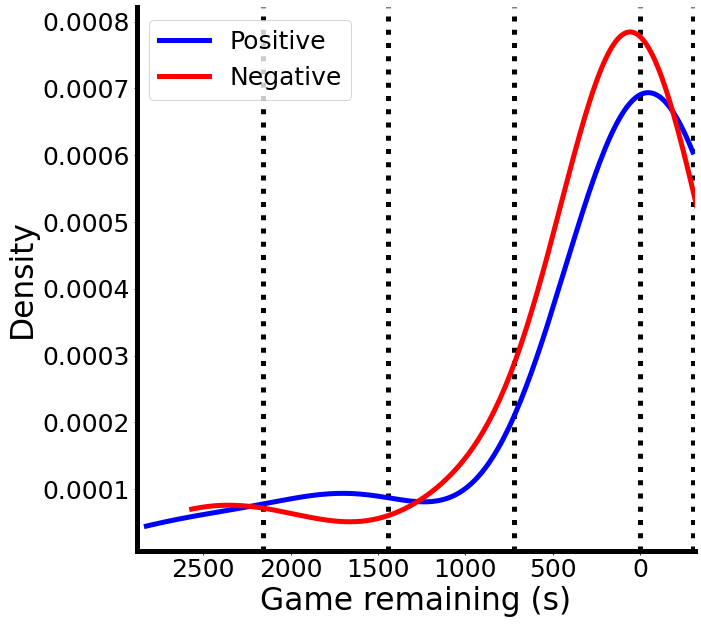

kurtosis g1: 2.959, p=0.003; kurtosis g2: 3.5, p=0.0
skewness g1: 5.155, p=0.0; kurtosis g2: 5.634, p=0.0
use mann-whitney!
times into game, pos v neg
   meth  g1n      g1m     g1s  g1med  g2n      g2m     g2s  g2med   df  \
0     2   70  270.629  93.232    5.0   74  344.838  82.319   53.0  142   

     stat      p    d  
0  1904.5  0.006 -0.1  




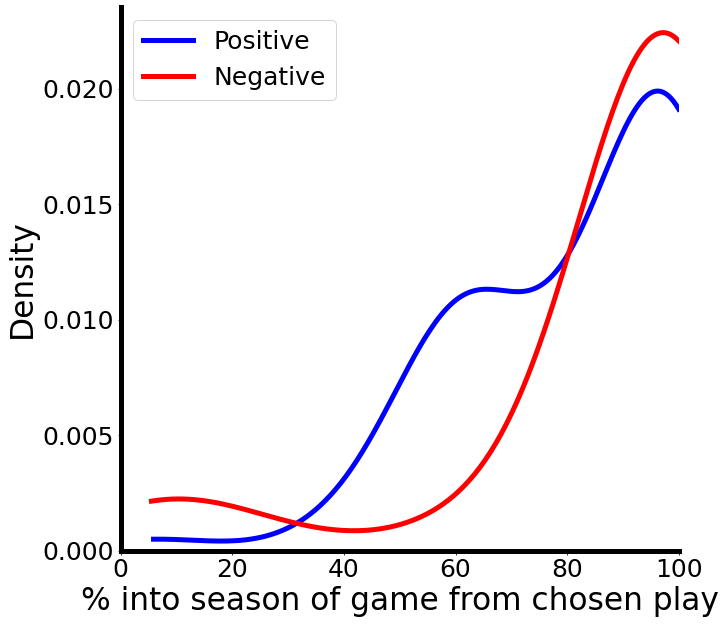

kurtosis g1: 1.843, p=0.065; kurtosis g2: 3.822, p=0.0
skewness g1: -3.469, p=0.001; kurtosis g2: -5.993, p=0.0
use mann-whitney!
times into szn, pos v neg
   meth  g1n     g1m    g1s      g1med  g2n     g2m    g2s      g2med   df  \
0     2   70  82.203  2.404  89.320388   74  87.534  3.009  99.047619  142   

     stat      p      d  
0  1922.0  0.006 -0.229  




In [321]:
#reporting Mann-Whitney tests: 
#https://stats.stackexchange.com/questions/393128/calculating-degrees-of-freedom-in-a-mann-whitney-u
def rd(dat,dig): #shorter rounding function
    r=round(dat,dig)
    return r

def astats(g1,g2,tn): #not used, as it turns out!
    #outputs t-stat, p value, and cohen's dz, given two paired groups
    t,p=ttest_rel(g1,g2)
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df,g3=n1-1,g1-g2
    dz=np.nanmean(g3)/np.nanstd(g3) #Cohen's dz
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    r['g1m'],r['g1s'],r['g2m'],r['g2s'],r['df'],r['t'],r['p'],r['dz']=b,b,b,b,b,b,b,b
    r['p'],r['t'],r['dz'],r['df']=rd(p,dg),rd(t,dg),rd(dz,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    print(tn)
    print(r)
    print('\n')
    return r

def astats1(g1,popm,tn):
    #outputs t-stat, p value, and cohen's dz, given one sample group
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    sku1,pku1=stats.kurtosistest(g1,nan_policy='omit')
    print('kurtosis g1: %s, p=%s' %(rd(sku1,dg),rd(pku1,dg)))
    ske1,pke1=stats.skewtest(g1,nan_policy='omit')
    print('skewness g1: %s, p=%s' %(rd(ske1,dg),rd(pke1,dg)))
    if np.logical_or(pku1<0.05,pke1<0.05):
        res=stats.wilcoxon(g1-popm,nan_policy='omit',method = 'approx')
        stat,p=res.zstatistic, res.pvalue
        print('use wilcoxon!')
        meth=2
    else:
        stat,p=stats.ttest_1samp(g1,popmean=popm,nan_policy='omit')
        print('assume normality')
        meth=1
    n1=np.sum(~np.isnan(g1))
    df=n1-1
    dz=np.nanmean(g1)/np.nanstd(g1) #Cohen's dz
    g1m,g1s=np.nanmean(g1),np.nanstd(g1)/np.sqrt(n1)
    r['meth'],r['g1n'],r['g1m'],r['g1s'],r['df'],r['stat'],r['p'],r['dz'],r['g1med']=b,b,b,b,b,b,b,b,b
    r['p'],r['stat'],r['dz'],r['df']=rd(p,dg),rd(stat,dg),rd(dz,dg),rd(df,dg)
    r['g1m'],r['g1s']=rd(g1m,dg),rd(g1s,dg)
    r['meth'],r['g1n'],r['g1med']=meth,n1,np.nanmedian(g1)
    print(tn)
    print(r)
    print('\n')
    return r

def astats2(g1,g2,tn):
    #outputs t-stat, p value, and cohen's d, given two unpaired groups
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    sku1,pku1=stats.kurtosistest(g1,nan_policy='omit')
    sku2,pku2=stats.kurtosistest(g2,nan_policy='omit')
    print('kurtosis g1: %s, p=%s; kurtosis g2: %s, p=%s' %(rd(sku1,dg),rd(pku1,dg),rd(sku2,dg),rd(pku2,dg)))
    ske1,pke1=stats.skewtest(g1,nan_policy='omit')
    ske2,pke2=stats.skewtest(g2,nan_policy='omit')
    print('skewness g1: %s, p=%s; kurtosis g2: %s, p=%s' %(rd(ske1,dg),rd(pke1,dg),rd(ske2,dg),rd(pke2,dg)))
    if np.logical_or(np.logical_or(np.logical_or(pku1<0.05,pku2<0.05),pke1<0.05),pke2<0.05):
        stat,p=stats.mannwhitneyu(g1,g2,nan_policy='omit')
        print('use mann-whitney!')
        meth=2
    else:
        stat,p=ttest_ind(g1,g2,nan_policy='omit')
        print('assume normality')
        meth=1
    #n1,n2,df=len(g1),len(g2),len(g1)+len(g2)-2
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df=n1+n2-2
    pools=np.sqrt(((n1-1)*np.nanvar(g1)+(n2-1)*np.nanvar(g2))/df)
    d=(np.nanmean(g1)-np.nanmean(g2))/pools#Cohen's d
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r['meth'],r['g1n'],r['g1m'],r['g1s'],r['g1med'],r['g2n'],r['g2m'],r['g2s'],r['g2med']=b,b,b,b,b,b,b,b,b
    r['df'],r['stat'],r['p'],r['d']=b,b,b,b
    r['p'],r['stat'],r['d'],r['df']=rd(p,dg),rd(stat,dg),rd(d,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    r['meth'],r['g1n'],r['g2n'],r['g1med'],r['g2med']=meth,n1,n2,np.nanmedian(g1),np.nanmedian(g2)
    print(tn)
    print(r)
    print('\n')
    return r

# plot when chosen plays happen in game
figp=1
nseci=t_sec/2 #2880 #720
max_gl,min_gl=t_sec+0,-(5*60)-10 #add 10 s buffer so we can see rugplot points
sec_a=np.linspace(min_gl,max_gl,51) #last quarter
kdeplotf(timesp,timesn,[],'Game remaining (s)',[max_gl,min_gl],'figs/play_recalltimes.pdf',1)

x,y=timesp,timesn
out=astats2(x,y,'times into game, pos v neg')
#stat,pval=ttest_ind(x,y,nan_policy='omit') #OLD syntax
#print('times pos v neg, stat = %s, pval = %s,df = %s' %(stat,pval,len(x)+len(y)-2))

#plot when chosen plays happen in season
kdeplotf(perc_into_sznpp,perc_into_sznpn,[],'% into season of game from chosen play',
         [0,100],'figs/play_recalltimes_szn.pdf',0)

x,y=perc_into_sznpp,perc_into_sznpn
out=astats2(x,y,'times into szn, pos v neg')

(0.9442398158906452,
 0.01841126416515813,
 0.8754650193612041,
 -0.018769280049418358)

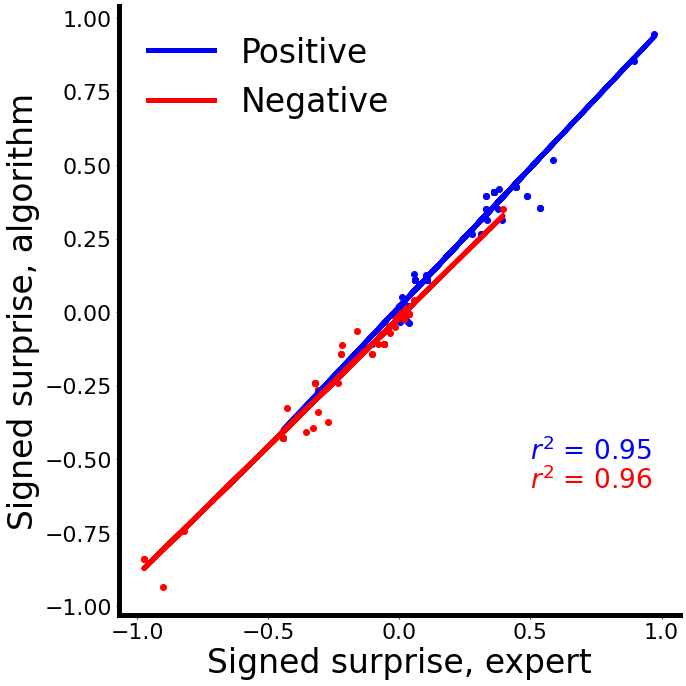

In [275]:
#check algo vs expert
def scatterp(x1,y1,x2,y2,xl,yl,fn,exv):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    plt.scatter(x1,y1)
    a1,b1=np.polyfit(x1,y1,1)
    plt.plot(x1, a1*x1+b1,linewidth=lw)
    if len(x2)>0:
        plt.scatter(x2,y2)
        a2,b2=np.polyfit(x2,y2,1)
        plt.plot(x2, a2*x2+b2,linewidth=lw)
    ax.set_xlabel(xl,fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    ax.legend(['Positive','Negative'],ncol=1,loc='upper left',fontsize=fs,frameon=False)
    if exv>0:
        ax.legend(['Positive','Negative'],ncol=1,loc='upper right',fontsize=fs,frameon=False)
        
    corr1, _ = pearsonr(x1,y1)
    corr2, _ = pearsonr(x2,y2)
    if len(fn)>0:
        if exv==1:
            ax.text(0.5,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        elif exv==2:
            ax.text(15,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(15,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        else:
            ax.text(0.5,-0.5,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,-0.6,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        f.tight_layout()
        f.savefig(fn, transparent=True)
    return a1,b1,a2,b2

scatterp(dfp['Relative surprise']/100,dfp['relsur_a'],dfn['Relative surprise']/100,dfn['relsur_a'],
        'Signed surprise, expert','Signed surprise, algorithm','figs/play_algoVexpert.pdf',0)

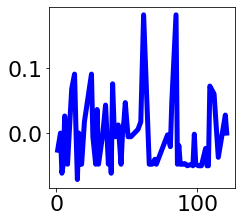

In [276]:
#plot differences between expert & algorithm to quickly investigate
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz/3,fsz/3))
plt.plot((dfp['Relative surprise']/100-dfp['relsur_a']),linewidth=lw)

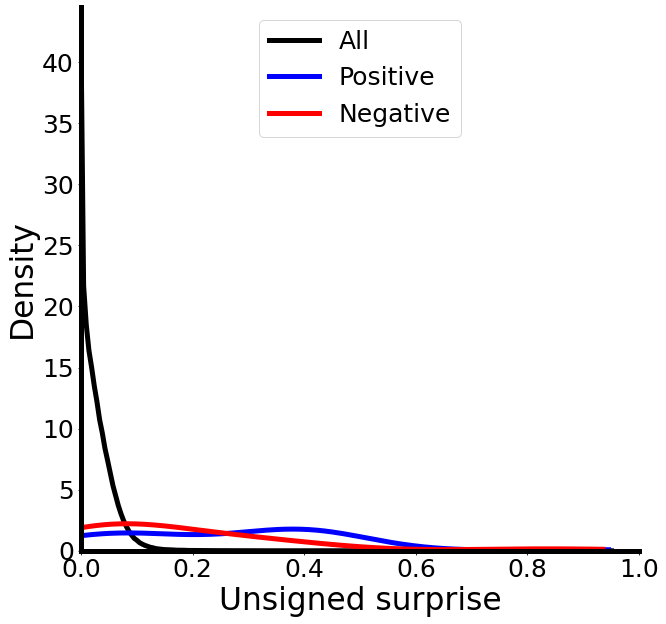

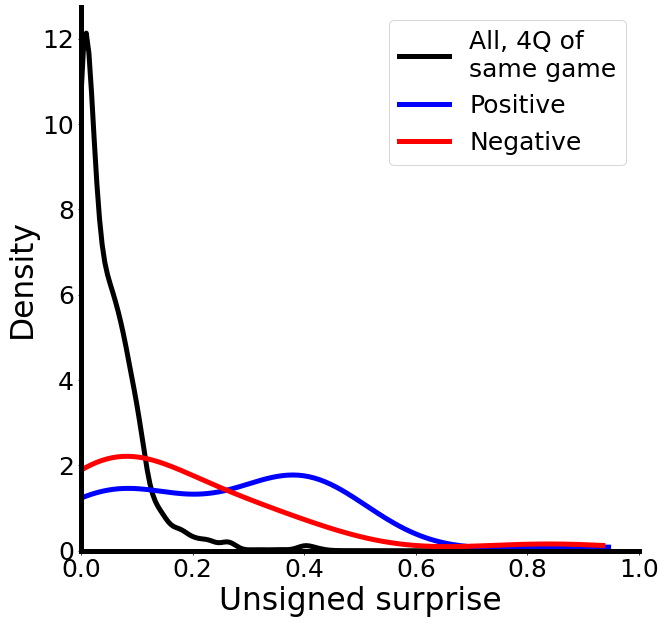

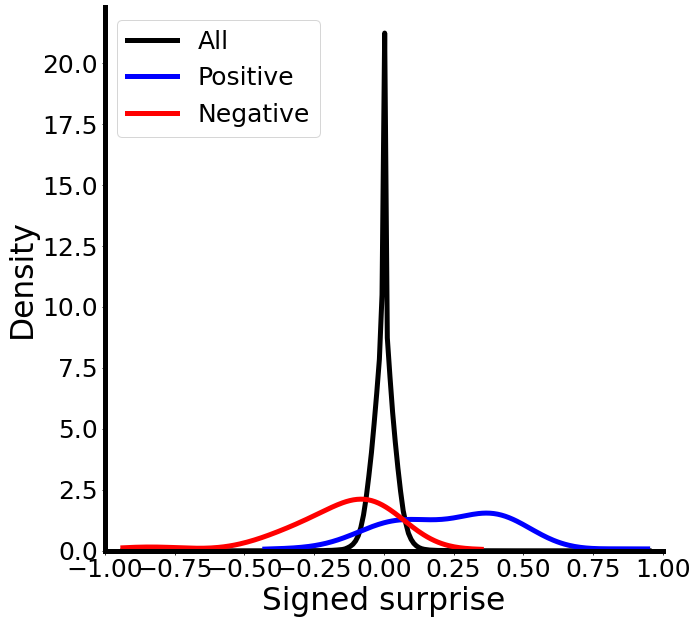

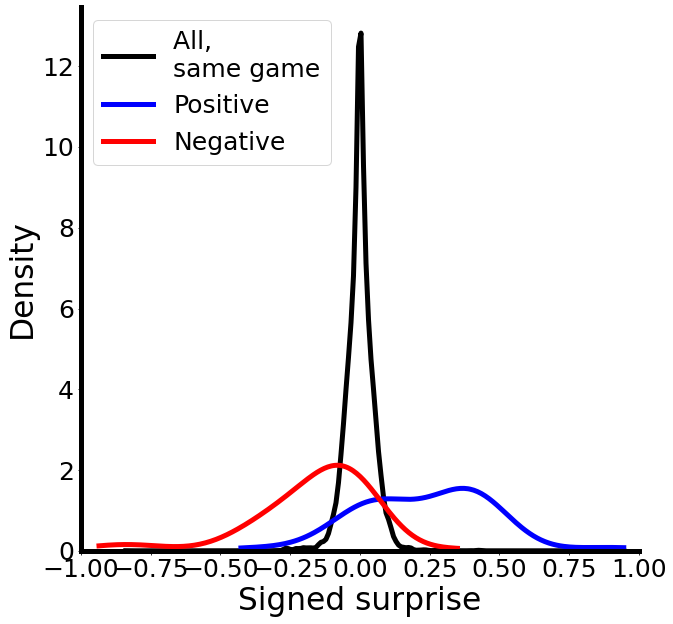

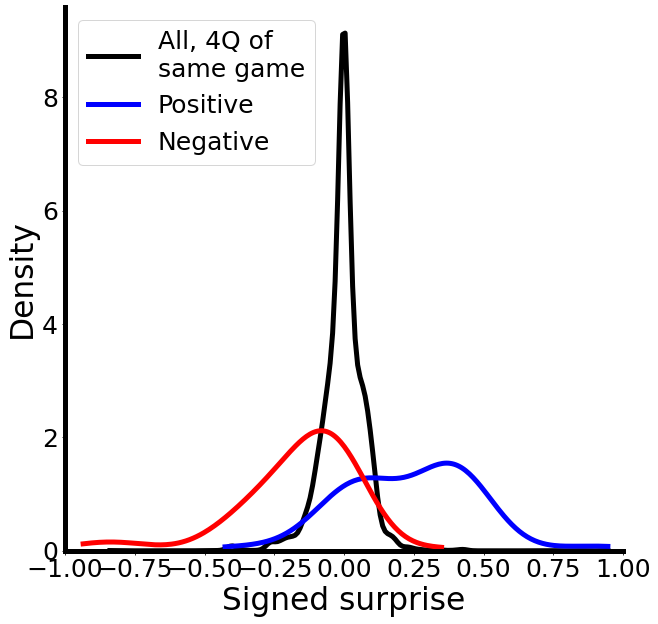

In [277]:
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    sursp,sursn=dfp['Signed surprise']/100,dfn['Signed surprise']/100
elif expert_algo==2:
    sursp,sursn=dfp['relsur_a'],dfn['relsur_a']
    
allgsurs=np.hstack([allgsursp,allgsursn])
allgsurs_4q=np.hstack([allgsursp_4q,allgsursn_4q])

##possession level
nb=100
kdeplotf(np.absolute(allsurs),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise.pdf',4)
kdeplotf(np.absolute(allgsurs_4q),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise_4q.pdf',6)

kdeplotf(allsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise.pdf',0)
kdeplotf(allgsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs.pdf',2)
kdeplotf(allgsurs_4q,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs_4q.pdf',3)

In [278]:
#run stats 
#unsigned
astats2(np.absolute(sursp),np.absolute(allsurs),'unsigned play sur, pos vs allsurs')
astats2(np.absolute(sursp),np.absolute(allgsursp),'unsigned play sur, pos vs allsurs, same game')
astats2(np.absolute(sursp),np.absolute(allgsursp_4q),'unsigned play sur, pos vs allsurs, 4q of same game')
astats2(np.absolute(sursn),np.absolute(allsurs),'unsigned play sur, neg vs allsurs')
astats2(np.absolute(sursn),np.absolute(allgsursn),'unsigned play sur, neg vs allsurs, same game')
astats2(np.absolute(sursn),np.absolute(allgsursn_4q),'unsigned play sur, neg vs allsurs, 4q of same game')
astats2(np.absolute(sursp),np.absolute(sursn),'unsigned play sur, pos vs neg')

#signed
astats2(sursp,allsurs,'signed play sur, pos vs allsurs')
astats2(sursp,allgsursp,'signed play sur, pos vs allsurs, same game')
astats2(sursp,allgsursp_4q,'signed play sur, pos vs allsurs, 4q of same game')
astats2(sursn,allsurs,'signed play sur, neg vs allsurs')
astats2(sursn,allgsursn,'signed play sur, neg vs allsurs, same game')
astats2(sursn,allgsursn_4q,'signed play sur, neg vs allsurs, 4q of same game')
astats2(sursp,sursn,'signed play sur, pos vs neg')

qq=np.where(abs(sursp)>0.05)
big_i=len(qq[0])/len(sursp)
print('% + plays with >5% impact on game:',big_i)
qq=np.where(abs(sursn)>0.05)
big_i=len(qq[0])/len(sursn)
print('% - plays with >5% impact on game:',big_i)
qq=np.where(abs(sursp)>0.25)
big_i=len(qq[0])/len(sursp)
print('% + plays with >25% impact on game:',big_i)
qq=np.where(abs(sursn)>0.25)
big_i=len(qq[0])/len(sursn)
print('% - plays with >25% impact on game:',big_i)

kurtosis g1: 1.642, p=0.101; kurtosis g2: 1315.464, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 1682.901, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsurs
   meth  g1n    g1m    g1s     g1med      g2n    g2m  g2s     g2med       df  \
0     2   70  0.261  0.024  0.313701  5661042  0.027  0.0  0.019384  5661110   

          stat    p      d  
0  344307235.5  0.0  7.859  


kurtosis g1: 1.642, p=0.101; kurtosis g2: 76.594, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 107.747, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsurs, same game
   meth  g1n    g1m    g1s     g1med    g2n    g2m  g2s     g2med     df  \
0     2   70  0.261  0.024  0.313701  18202  0.034  0.0  0.024241  18270   

        stat    p      d  
0  1086322.0  0.0  5.353  


kurtosis g1: 1.642, p=0.101; kurtosis g2: 37.196, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 52.391, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsurs, 4q of same game
   meth  g1n    g1m    g1s     g1med   g2n    g2

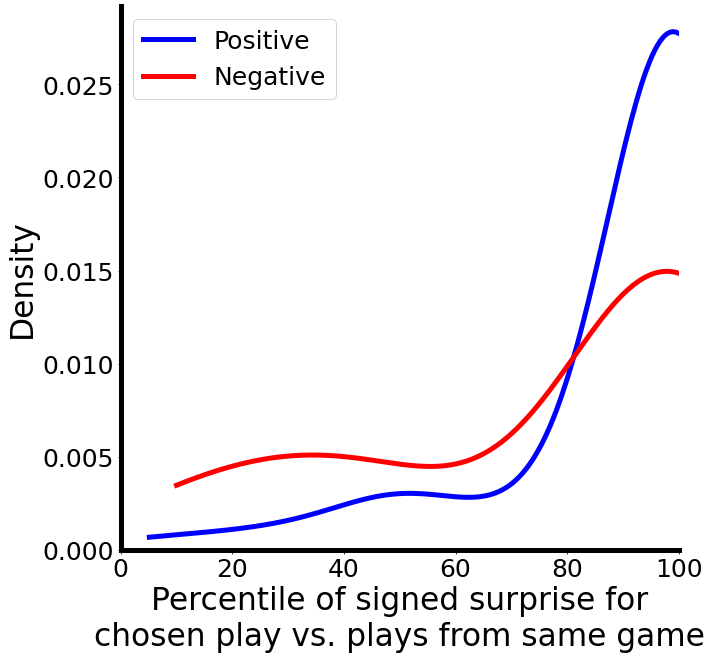

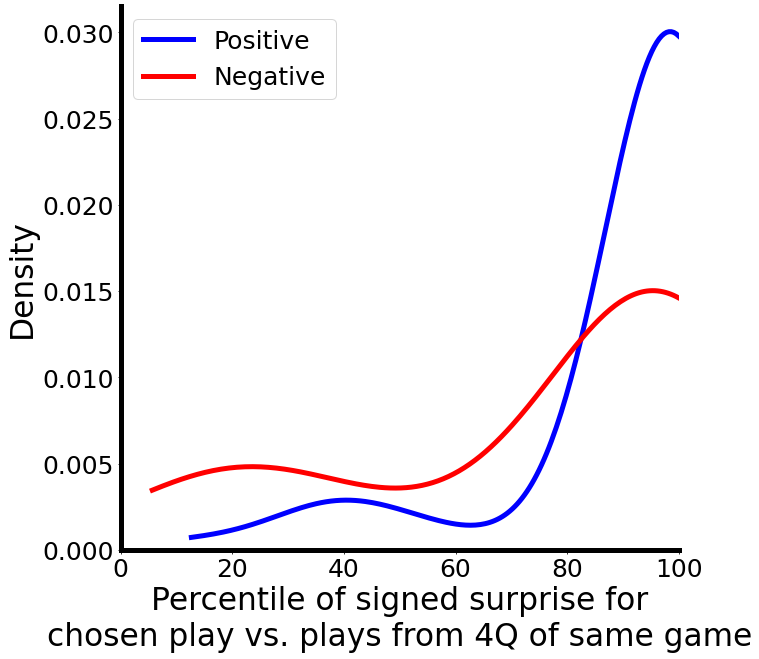

In [279]:
kdeplotf(perc_g_surp_abs,perc_g_surn_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from same game''',[0,100],'figs/recalltimes_play.pdf',0)
kdeplotf(perc_g_surp_4q_abs,perc_g_surn_4q_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from 4Q of same game''',[0,100],'figs/recalltimes_play_4q.pdf',0)

In [280]:
def barswarm(dp,dn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Positive']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Negative']*len(dn),lab:dn})
    dat=dat1.append(dat2)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors = ["blue", "red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],palette=cp,facecolor=None,size=msz)
    ax.set_ylabel(yl,fontsize=fs)
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if exv==0:
        ax.hlines(0,-0.5,1.5,color="black")
    elif exv==1:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','Top 3/game','Top 10/week','Top 10/year'])
    elif exv==2:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','''Good solo
performance or
hyped narrative''','''Performance
in top 10/week''','''Performance
in top 10/year'''])
    elif exv==3:
        ax.hlines(15.5,-0.5,1.5,colors='k', linestyles='dashed',linewidth=lw)
    f.tight_layout()
    f.savefig(fn, transparent=True)

<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


kurtosis g1: 0.124, p=0.901; kurtosis g2: -2.076, p=0.038
skewness g1: -0.041, p=0.967; kurtosis g2: 2.576, p=0.01
use mann-whitney!
spectacularity, pos vs neg
   meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med  df    stat  \
0     2   45  2.044  0.089    2.0   48  1.583  0.121    1.0  91  1477.0   

       p      d  
0  0.001  0.631  


r-squared,both = 0.008438505835819706, pval = 0.3811653879375573
r-squared,positive = 0.011595658478823673, pval = 0.4813801503947981
r-squared,negative = 0.011168941450192382, pval = 0.47467075328229497


(-0.29922417975933174,
 2.1288571116724895,
 0.4793317520818941,
 1.5011734116351938)

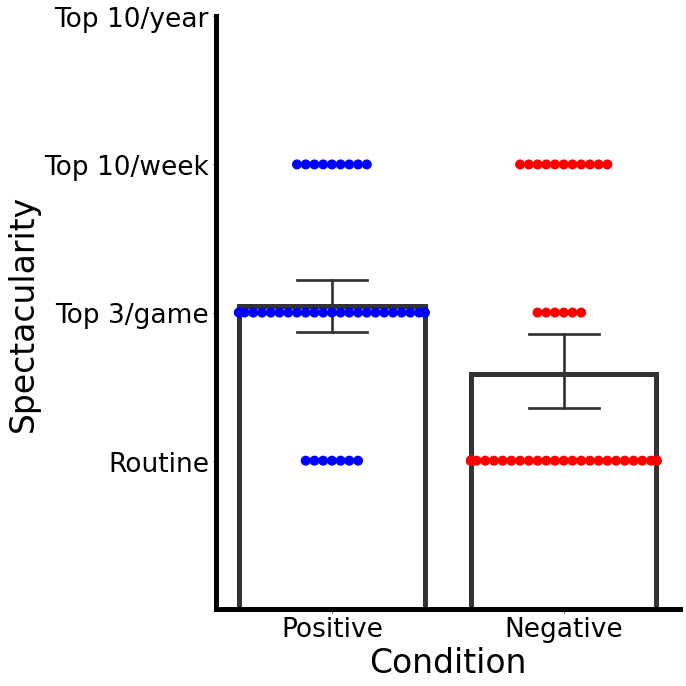

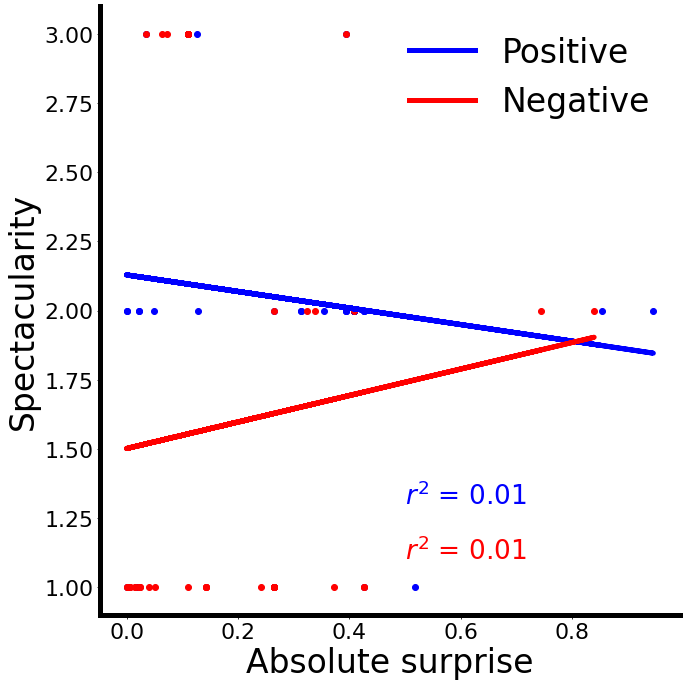

In [281]:
#spectacularity
ystr1,ybr1='relsur_a','Absolute surprise'
ystr2,ybr2='Spectacularity','Spectacularity'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,1)

astats2(y1[qp],y2[qn],'spectacularity, pos vs neg')

#stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
#print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(np.hstack([x1[qp],x2[qn]]),np.hstack([y1[qp],y2[qn]]))
print('r-squared,both = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


kurtosis g1: -1.346, p=0.178; kurtosis g2: -2.452, p=0.014
skewness g1: -0.015, p=0.988; kurtosis g2: 0.429, p=0.668
use mann-whitney!
time affected, pos vs neg
   meth  g1n    g1m    g1s  g1med  g2n    g2m   g2s  g2med   df    stat  \
0     2   68  3.162  0.145    3.0   73  2.836  0.15    3.0  139  2828.5   

       p      d  
0  0.138  0.263  


r-squared,positive = 0.0071634075685594, pval = 0.49256988810321245
r-squared,negative = 0.025852422435812244, pval = 0.17417420585825613


(-0.506377762139756, 3.291865429389867, -1.0137971115924105, 3.016604146533269)

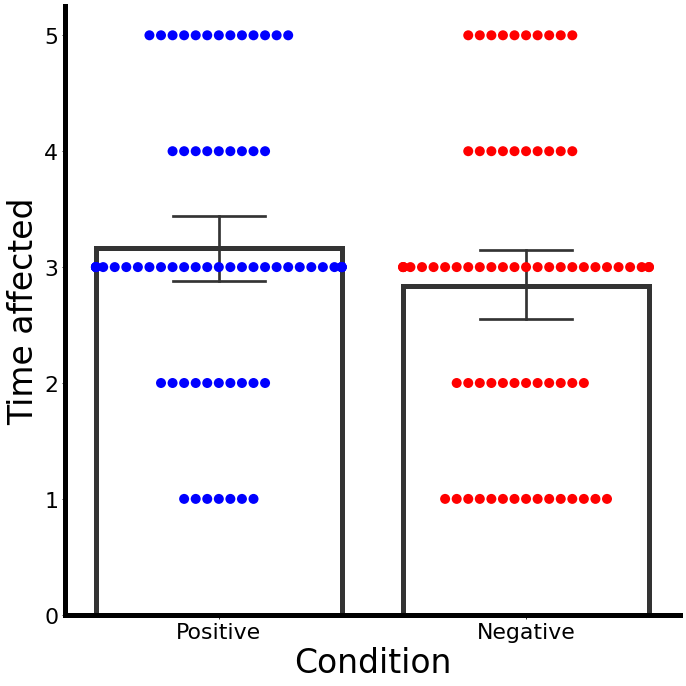

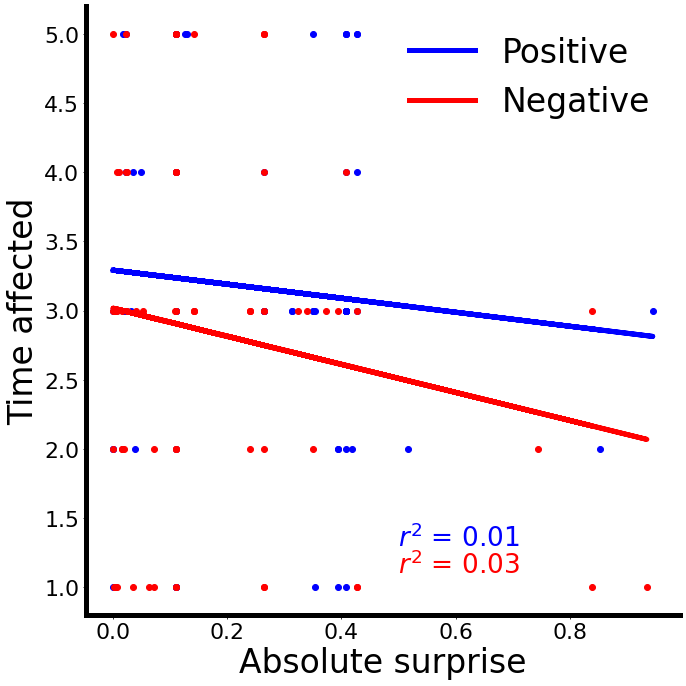

In [282]:
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
#x1,x2=dfp[ystr1].values,dfn[ystr1].values
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

astats2(y1[qp],y2[qn],'time affected, pos vs neg')
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

# Game data

In [283]:
m_ind,d_ind=np.zeros((ngp)),np.zeros((ngp))
for i in range(ngp):
    m_ind[i]=dfgp['Month/date'][dfgp.index[i]][5:7]
    d_ind[i]=dfgp['Month/date'][dfgp.index[i]][8:10]
dfgp['month']=m_ind
dfgp['day']=d_ind
dfgp[['month','day','Year','home']] = dfgp[['month','day','Year','home']].astype(int)
m_ind,d_ind=np.zeros((ngn)),np.zeros((ngn))
for i in range(ngn):
    m_ind[i]=dfgn['Month/date'][dfgn.index[i]][5:7]
    d_ind[i]=dfgn['Month/date'][dfgn.index[i]][8:10]
dfgn['month']=m_ind
dfgn['day']=d_ind
dfgn[['month','day','Year','home']] = dfgn[['month','day','Year','home']].astype(int)

In [284]:
#find games!!!!!
gsursp_a,perc_s_surp,perc_s_surp_poffs=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_a_abs,perc_s_surp_abs,perc_into_szngp=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
perc_s_surp_poffs_abs,gmaxsursp_a,gsursp_st_a=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_t_a=np.zeros((ngp))
for i in range(ngp):
    curr_y=dfgp['Year'][dfgp.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfgp['month'][dfgp.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfgp['day'][dfgp.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfgp['home'][dfgp.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    print('i, Year, month, date, home:%s,%s,%s,%s,%s' %(dfgp.index[i],curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursp_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursp_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursp_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative comeback effect by the algorithm
        #use absolute here because there are some miniscule rounding errors
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
    else:
        gsursp_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
    gsursp_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]] #time in game of moment furthest from comeback        
        
    gsursp_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs comeback effect by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursp_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursp_a[i],".2f"),format(gmaxsursp_a[i],".2f"))) 
    
    print('\n')
    #find % of way into season of games
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngp[i]=stats.percentileofscore(ids_tszn,curr_g_id)

i, Year, month, date, home:1,2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


i, Year, month, date, home:3,2008,6,17,2
rows, rows, rows, rows:330313,1470,257,257
gsur, gmaxsur,gsur_st:0.82,0.11,0.11


i, Year, month, date, home:4,2016,6,5,9
rows, rows, rows, rows:367236,1730,241,241
gsur, gmaxsur,gsur_st:0.49,0.09,0.09


i, Year, month, date, home:5,2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


i, Year, month, date, home:7,2018,11,19,25
rows, rows, rows, rows:358838,57070,2360,281
gsur, gmaxsur,gsur_st:0.61,0.14,0.14


i, Year, month, date, home:8,2016,12,5,9
rows, rows, rows, rows:367236,59347,2919,286
gsur, gmaxsur,gsur_st:0.19,0.06,0.06


i, Year, month, date, home:9,2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


i, Year, month, date, home:10,2020,10,11,15
rows, rows, rows, rows:205965,1234,240,240
gsur, gmaxsur,gsur_st:-0.51,0.12,0.12


i,

i, Year, month, date, home:102,2016,4,13,13
rows, rows, rows, rows:367236,36781,3527,240
gsur, gmaxsur,gsur_st:1.00,0.21,0.21


i, Year, month, date, home:103,2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


i, Year, month, date, home:106,2016,5,30,9
rows, rows, rows, rows:367236,9052,234,234
gsur, gmaxsur,gsur_st:0.73,0.10,0.10


i, Year, month, date, home:107,2021,6,30,12
rows, rows, rows, rows:283261,11247,245,245
gsur, gmaxsur,gsur_st:-0.61,0.09,0.09


i, Year, month, date, home:108,2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


i, Year, month, date, home:109,2006,1,22,13
rows, rows, rows, rows:332820,56193,2272,264
gsur, gmaxsur,gsur_st:0.91,0.09,0.09


i, Year, month, date, home:110,2018,1,8,9
rows, rows, rows, rows:358838,54655,2057,255
gsur, gmaxsur,gsur_st:0.36,0.11,0.11


i, Year, month, date, home:112,2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84

In [285]:
gsursn_a,perc_s_surn,perc_s_surn_poffs=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_a_abs,perc_s_surn_abs,perc_into_szngn=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
perc_s_surn_poffs_abs,gmaxsursn_a,gsursn_st_a=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_t_a=np.zeros((ngn))
for i in range(ngn):
    curr_y=dfgn['Year'][dfgn.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfgn['month'][dfgn.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfgn['day'][dfgn.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfgn['home'][dfgn.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursn_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursn_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursn_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative game surprise by the algorithm
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]      
    else:
        gsursn_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]       
        
        
    gsursn_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs game surprise by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursn_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursn_a[i],".2f"),format(gmaxsursn_a[i],".2f"))) 
    print('\n')
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #df of all updates in this season!
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngn[i]=stats.percentileofscore(ids_tszn,curr_g_id)

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
gsur, gmaxsur,gsur_st:-0.75,0.19,0.19


Year, month, date, home:2020,9,30,13
rows, rows, rows, rows:205965,9067,248,248
gsur, gmaxsur,gsur_st:0.68,0.09,0.09


Year, month, date, home:2020,9,27,15
rows, rows, rows, rows:205965,9067,247,247
gsur, gmaxsur,gsur_st:0.70,0.12,0.12


Year, month, date, home:2020,1,12,14
rows, rows, rows, rows:205965,57836,1820,285
gsur, gmaxsur,gsur_st:0.42,0.09,0.09


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2019,3,22,13
rows, rows, rows, rows:352368,58546,1811,282
gsur, gmaxsur,gsur_st:-0.64,0.14,0.14


Year, month, date, home:2020,7,31,26
rows, 

Year, month, date, home:2021,7,20,16
rows, rows, rows, rows:283261,2010,264,264
gsur, gmaxsur,gsur_st:0.62,0.10,0.10


Year, month, date, home:2017,6,12,9
rows, rows, rows, rows:362709,1348,266,266
gsur, gmaxsur,gsur_st:0.46,0.12,0.12


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
gsur, gmaxsur,gsur_st:0.99,0.43,0.43


Year, month, date, home:2021,6,19,1
rows, rows, rows, rows:283261,11247,268,268
gsur, gmaxsur,gsur_st:-0.83,0.35,0.35


Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
gsur, gmaxsur,gsur_st:-0.75,0.19,0.19




kurtosis g1: -1.198, p=0.231; kurtosis g2: 4.052, p=0.0
skewness g1: -3.317, p=0.001; kurtosis g2: -6.111, p=0.0
use mann-whitney!
times into game, pos vs neg
   meth  g1n     g1m   g1s      g1med  g2n     g2m    g2s  g2med   df    stat  \
0     2   77  79.467  3.18  98.837209   74  91.785  2.111  100.0  149  2225.0   

       p      d  
0  0.012 -0.521  




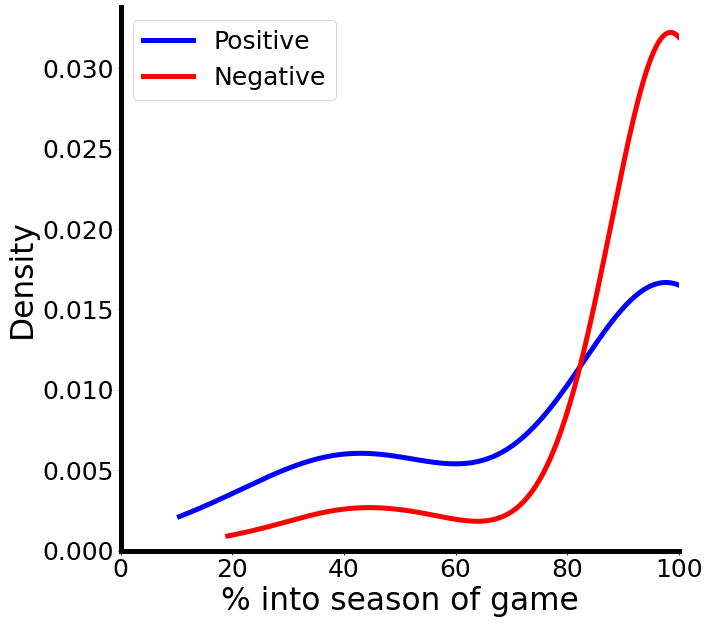

In [286]:
x,y=perc_into_szngp+0,perc_into_szngn+0
astats2(x,y,'times into game, pos vs neg')

kdeplotf(x,y,[],'% into season of game',[0,100],'figs/game_perc_into_szn.pdf',0)

In [287]:
qq=100==perc_into_szngp
print('# last game',np.sum(qq))
print('# games',len(perc_into_szngp))
lastgameperc=np.sum(qq)/len(perc_into_szngp)
print(lastgameperc)

# last game 35
# games 77
0.45454545454545453


(0.9542329708687951,
 0.03587358487346553,
 0.9883486876040508,
 -0.022160767793215522)

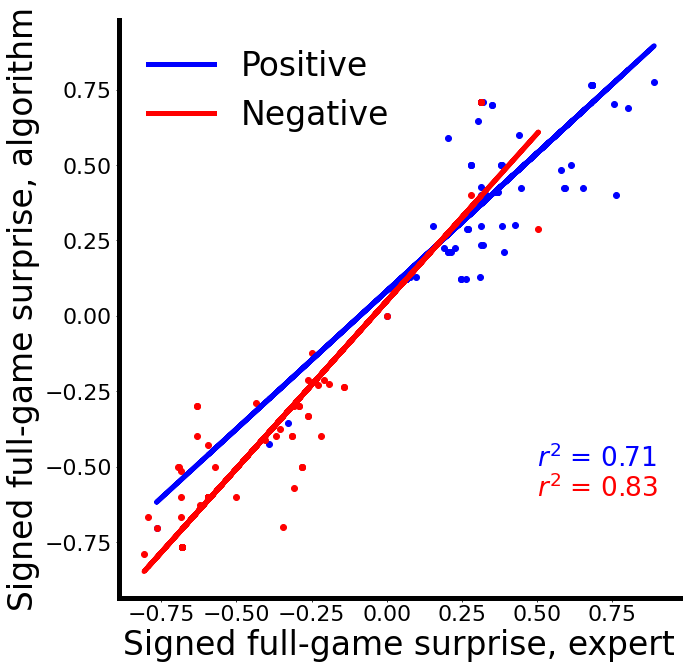

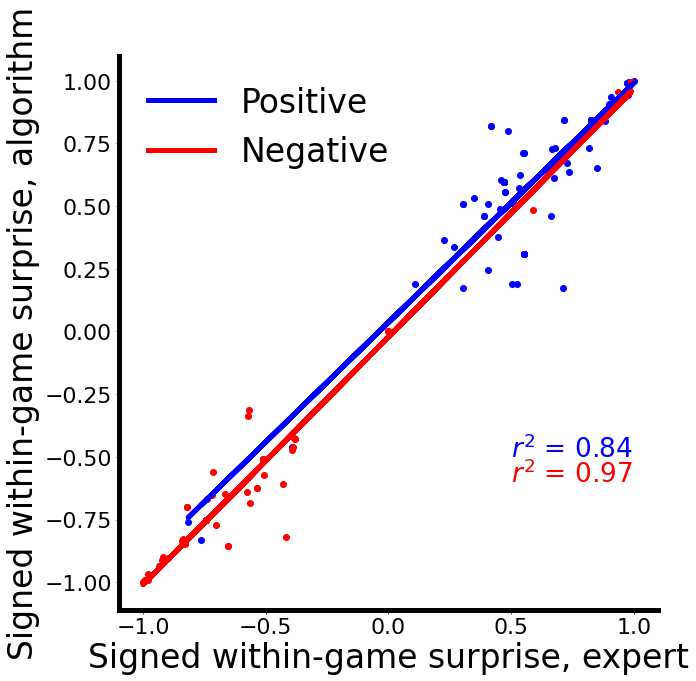

In [288]:
chvp=np.zeros((ngp))
for i in range(ngp):
    if int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==1:
        chvp[i]=1
    elif int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==-1:
        chvp[i]=-1
dfgp['chv']=chvp
chvn=np.zeros((ngn)) #fix quick thing with cheering for being strings / inconvertible to int quickly
for i in range(ngn):
    if int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==1:
        chvn[i]=1
    elif int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==-1:
        chvn[i]=-1
dfgn['chv']=chvn

dfgp['relcbsur_a']=np.multiply(gsursp_a,dfgp['chv'].values) #relative surprise by algorithm
dfgn['relcbsur_a']=np.multiply(gsursn_a,dfgn['chv'].values)
dfgp['relgsur_a']=np.multiply(gsursp_st_a,dfgp['chv'].values) #post- minus pre-game surprise by algorithm
dfgn['relgsur_a']=np.multiply(gsursn_st_a,dfgn['chv'].values)

#check algo vs expert
scatterp(dfgp['Relative surprise (game-level)']/100,dfgp['relgsur_a'],
        dfgn['Relative surprise (game-level)']/100,dfgn['relgsur_a'],
        'Signed full-game surprise, expert','Signed full-game surprise, algorithm',
        'figs/game_fullgame_algoVexpert.pdf',0)

scatterp(dfgp['Comeback via website (if NBA/WNBA)']/100,dfgp['relcbsur_a'],
        dfgn['Comeback via website (if NBA/WNBA)']/100,dfgn['relcbsur_a'],
        'Signed within-game surprise, expert','Signed within-game surprise, algorithm',
        'figs/game_cb_algoVexpert.pdf',0)

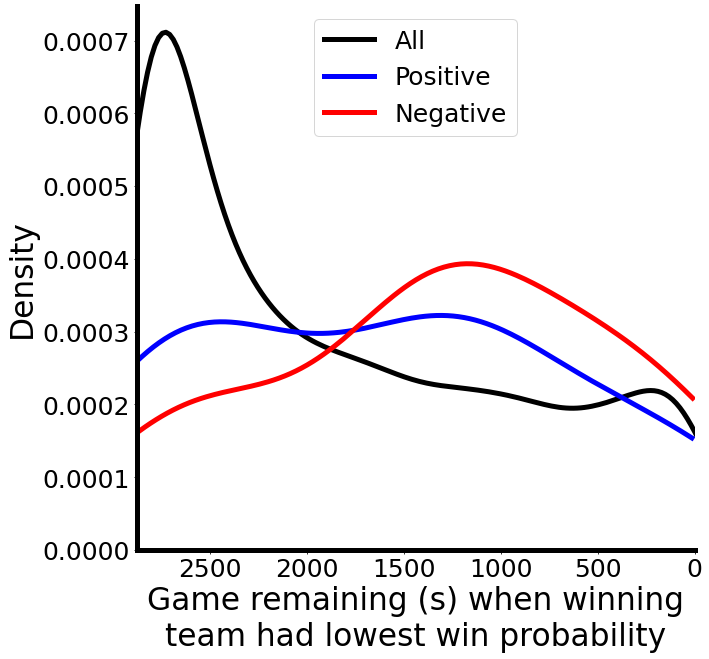

kurtosis g1: -67.683, p=0.0; kurtosis g2: -4.94, p=0.0
skewness g1: -33.386, p=0.0; kurtosis g2: -0.757, p=0.449
use mann-whitney!
game remaining, pos vs null
   meth    g1n       g1m    g1s   g1med  g2n       g2m      g2s   g2med  \
0     2  22539  1821.159  6.185  2081.0   77  1608.935  104.927  1364.0   

      df      stat      p      d  
0  22614  992516.5  0.029  0.229  


kurtosis g1: -67.683, p=0.0; kurtosis g2: -2.906, p=0.004
skewness g1: -33.386, p=0.0; kurtosis g2: 0.924, p=0.356
use mann-whitney!
game remaining, neg vs null
   meth    g1n       g1m    g1s   g1med  g2n       g2m     g2s   g2med     df  \
0     2  22539  1821.159  6.185  2081.0   74  1317.176  99.995  1364.0  22611   

        stat    p      d  
0  1099629.5  0.0  0.543  


kurtosis g1: -4.94, p=0.0; kurtosis g2: -2.906, p=0.004
skewness g1: -0.757, p=0.449; kurtosis g2: 0.924, p=0.356
use mann-whitney!
game remaining, pos vs neg
   meth  g1n       g1m      g1s   g1med  g2n       g2m     g2s   g2med   df  \


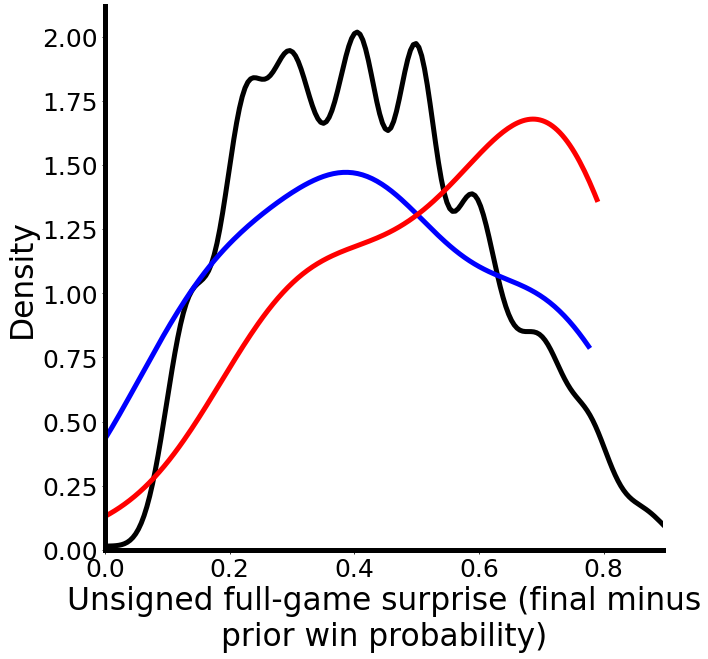

kurtosis g1: -32.311, p=0.0; kurtosis g2: -3.964, p=0.0
skewness g1: 17.739, p=0.0; kurtosis g2: 0.367, p=0.713
use mann-whitney!
full-game surprise, pos vs null
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.421  0.001  0.41012   77  0.424  0.025  0.410526  22614   

       stat      p      d  
0  867914.0  0.998 -0.014  


kurtosis g1: -32.311, p=0.0; kurtosis g2: -2.199, p=0.028
skewness g1: 17.739, p=0.0; kurtosis g2: -1.821, p=0.069
use mann-whitney!
full-game surprise, neg vs null
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s    g2med     df  \
0     2  22539  0.421  0.001  0.41012   74  0.541  0.024  0.60039  22611   

       stat    p      d  
0  546094.0  0.0 -0.656  


kurtosis g1: -3.964, p=0.0; kurtosis g2: -2.199, p=0.028
skewness g1: 0.367, p=0.713; kurtosis g2: -1.821, p=0.069
use mann-whitney!
full-game surprise, pos vs neg
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s    g2med   df    stat  \
0     2 

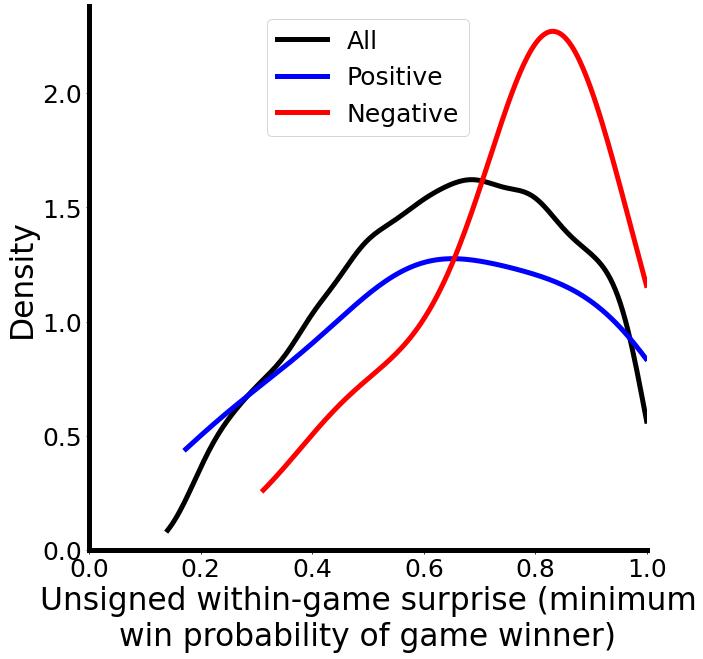

kurtosis g1: -50.885, p=0.0; kurtosis g2: -2.843, p=0.004
skewness g1: -13.595, p=0.0; kurtosis g2: -0.888, p=0.374
use mann-whitney!
unsigned within-game surprise, pos vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.638  0.001  0.650831   77  0.647  0.028  0.624294  22614   

       stat      p      d  
0  834067.0  0.556 -0.045  


kurtosis g1: -50.885, p=0.0; kurtosis g2: 0.043, p=0.966
skewness g1: -13.595, p=0.0; kurtosis g2: -2.62, p=0.009
use mann-whitney!
unsigned within-game surprise, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med     df  \
0     2  22539  0.638  0.001  0.650831   74  0.763  0.02  0.839474  22611   

       stat    p      d  
0  539131.0  0.0 -0.602  


kurtosis g1: -2.843, p=0.004; kurtosis g2: 0.043, p=0.966
skewness g1: -0.888, p=0.374; kurtosis g2: -2.62, p=0.009
use mann-whitney!
unsigned within-game surprise, pos vs neg
   meth  g1n    g1m    g1s     g1med  g2n    g2m

meth  g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med   df    stat  \
0     2   77  0.647  0.028  0.624294   74  0.763  0.02  0.839474  149  2055.0   

       p      d  
0  0.003 -0.545

In [289]:
## next also calculate based on GAME surprise, not within-game
# need to calculate the base rate of these two
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    cbsp,cbsn=dfgp['Comeback via website (if NBA/WNBA)'],dfgn['Comeback via website (if NBA/WNBA)']
    cbsp,cbsn=1-cbsp/100,1-cbsn/100 #normalize - put in same space as other data
    fgsp,fgsp=dfgp['Absolute surprise (game-level)'],dfgn['Absolute surprise (game-level)']
elif expert_algo==2:
    cbsp,cbsn=gsursp_a_abs+0,gsursn_a_abs+0
    fgsp,fgsn=dfgp['relgsur_a'],dfgn['relgsur_a']

#need to grab this null distribution!!
kdeplotf(mwwp_ts[:,0],gsursp_t_a,gsursn_t_a,'''Game remaining (s) when winning
team had lowest win probability''',[t_sec,0],
         'figs/game_comeback_times.pdf',4)

astats2(mwwp_ts[:,0],gsursp_t_a,'game remaining, pos vs null')
astats2(mwwp_ts[:,0],gsursn_t_a,'game remaining, neg vs null')
astats2(gsursp_t_a,gsursn_t_a,'game remaining, pos vs neg')

#full-game sur
kdeplotf(1-fwwps[:,0],np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise (final minus
prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs.pdf',5)

astats2(1-fwwps[:,0],np.absolute(fgsp),'full-game surprise, pos vs null')
astats2(1-fwwps[:,0],np.absolute(fgsn),'full-game surprise, neg vs null')
astats2(np.absolute(fgsp),np.absolute(fgsn),'full-game surprise, pos vs neg')

#within-game sur
kdeplotf(1-mwwps[:,0],1-cbsp,1-cbsn,'''Unsigned within-game surprise (minimum
win probability of game winner)''',[0,1],
         'figs/game_comeback_abs.pdf',4)

astats2(1-mwwps[:,0],1-cbsp,'unsigned within-game surprise, pos vs null')
astats2(1-mwwps[:,0],1-cbsn,'unsigned within-game surprise, neg vs null')
astats2(1-cbsp,1-cbsn,'unsigned within-game surprise, pos vs neg')

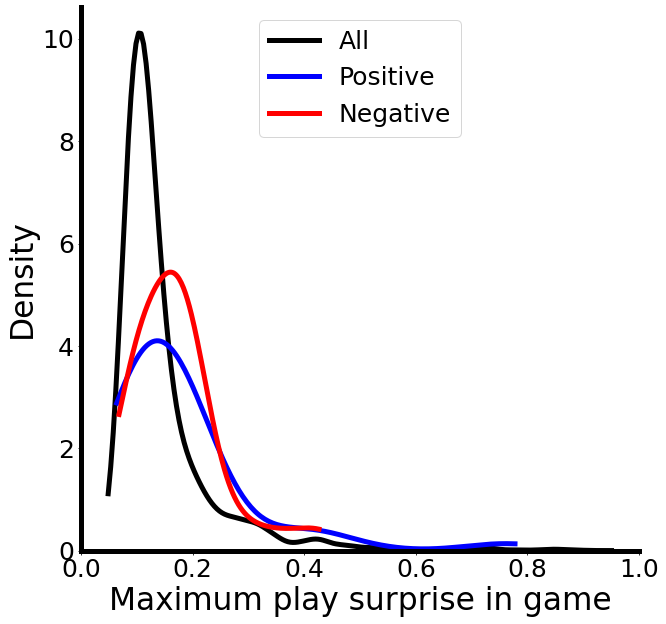

kurtosis g1: 71.326, p=0.0; kurtosis g2: 4.986, p=0.0
skewness g1: 107.655, p=0.0; kurtosis g2: 6.632, p=0.0
use mann-whitney!
max play sur, pos vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.146  0.001  0.117841   77  0.178  0.015  0.133898  22614   

       stat      p      d  
0  692714.5  0.002 -0.343  


kurtosis g1: 71.326, p=0.0; kurtosis g2: 3.172, p=0.002
skewness g1: 107.655, p=0.0; kurtosis g2: 4.667, p=0.0
use mann-whitney!
max play sur, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.146  0.001  0.117841   74  0.171  0.009  0.178961  22611   

       stat    p      d  
0  585431.0  0.0 -0.271  


kurtosis g1: 4.986, p=0.0; kurtosis g2: 3.172, p=0.002
skewness g1: 6.632, p=0.0; kurtosis g2: 4.667, p=0.0
use mann-whitney!
max play sur, pos vs neg
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2   77  0.178  0.015  0.133898   74

meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2   77  0.178  0.015  0.133898   74  0.171  0.009  0.178961  149   

     stat      p      d  
0  2660.0  0.482  0.063

In [290]:
#max surprise play - is higher in chosen games
kdeplotf(maxsurs[:,0],gmaxsursp_a,gmaxsursn_a,'Maximum play surprise in game',[0,1],
         'figs/game_max_play_sur_pn.pdf',4)

astats2(maxsurs[:,0],gmaxsursp_a,'max play sur, pos vs null')
astats2(maxsurs[:,0],gmaxsursn_a,'max play sur, neg vs null')
astats2(gmaxsursp_a,gmaxsursn_a,'max play sur, pos vs neg')

In [292]:
#control analyses - resample w/ replacement
fgsp,fgsn=fgsp.values,fgsn.values
iters,n_iters=0,100
adj_tstats_wgp,adj_pvals_wgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_fgp,adj_pvals_fgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_wgn,adj_pvals_wgn=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_fgn,adj_pvals_fgn=np.zeros((n_iters)),np.zeros((n_iters))
cumu_p,cumu_n,cumu_wgp,cumu_wgn,cumu_fgp,cumu_fgn=[],[],[],[],[],[] #cumulative distributions
while iters<n_iters:
    #positive first
    nv=gmaxsursp_a.shape[0]
    q0=np.random.choice(nv,nv)
    qval=gmaxsursp_a[q0]
    #print(maxsurs[:,0].shape)
    #print(qval.shape)
    stat,pval=ttest_ind(maxsurs[:,0],qval,nan_policy='omit')
    if pval>0.1:
        cumu_p=np.hstack([cumu_p,qval])
        stat,pval=ttest_ind(mwwps,cbsp[q0],nan_policy='omit')
        adj_tstats_wgp[iters]=stat
        adj_pvals_wgp[iters]=pval
        cumu_wgp=np.hstack([cumu_wgp,cbsp[q0]])
        stat,pval=ttest_ind(1-fwwps,np.absolute(fgsp[q0]),nan_policy='omit')
        adj_tstats_fgp[iters]=stat
        adj_pvals_fgp[iters]=pval
        cumu_fgp=np.hstack([cumu_fgp,np.absolute(fgsp[q0])])
        iters+=1

iters=0
while iters<n_iters:
    #positive first
    nv=gmaxsursn_a.shape[0]
    q1=np.random.choice(nv,nv)
    qval=gmaxsursn_a[q1]
    stat,pval=ttest_ind(maxsurs[:,0],qval,nan_policy='omit')
    if pval>0.1:
        cumu_n=np.hstack([cumu_n,qval])
        stat,pval=ttest_ind(mwwps,cbsn[q1],nan_policy='omit')
        adj_tstats_wgn[iters]=stat
        adj_pvals_wgn[iters]=pval
        cumu_wgn=np.hstack([cumu_wgn,cbsn[q1]])
        stat,pval=ttest_ind(1-fwwps,np.absolute(fgsn[q1]),nan_policy='omit')
        adj_tstats_fgn[iters]=stat
        adj_pvals_fgn[iters]=pval
        cumu_fgn=np.hstack([cumu_fgn,np.absolute(fgsn[q1])])
        iters+=1

AttributeError: 'numpy.ndarray' object has no attribute 'values'

pos, adj for fg, nsig:0.12
neg, adj for fg, nsig:1.0
pos, adj for wg, nsig:0.09
neg, adj for wg, nsig:1.0


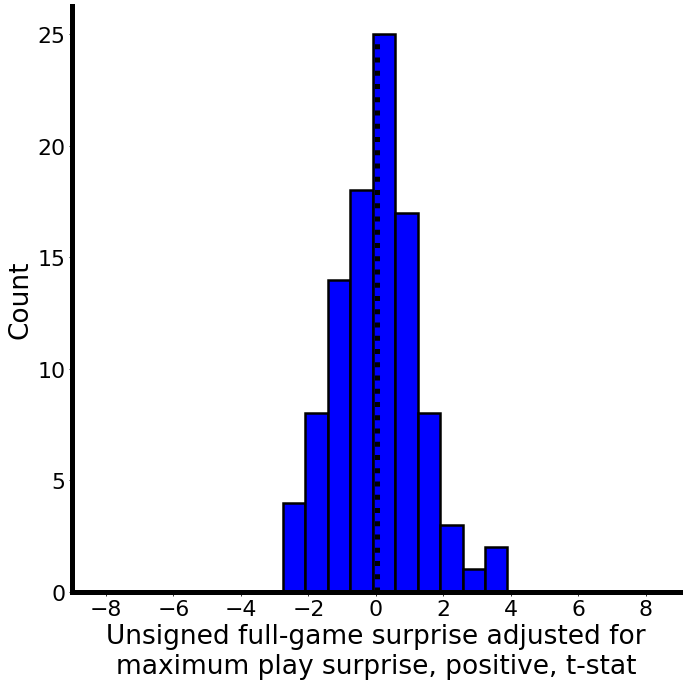

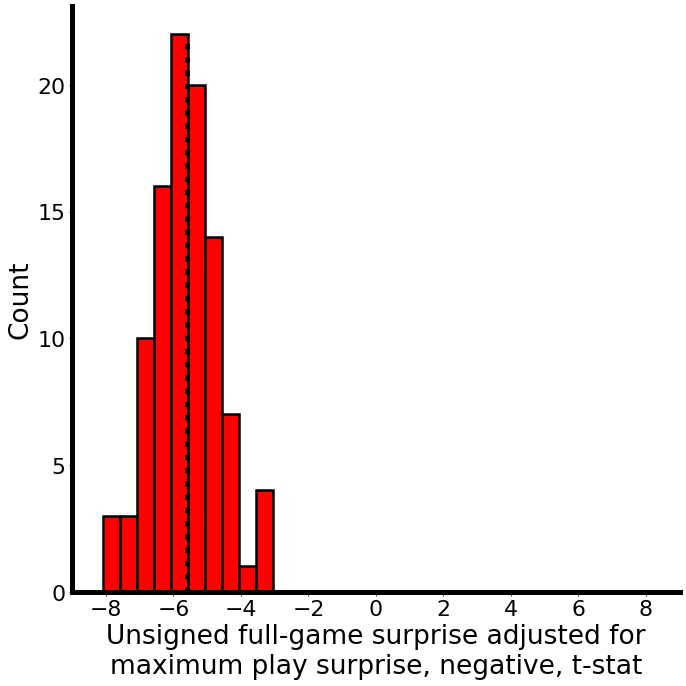

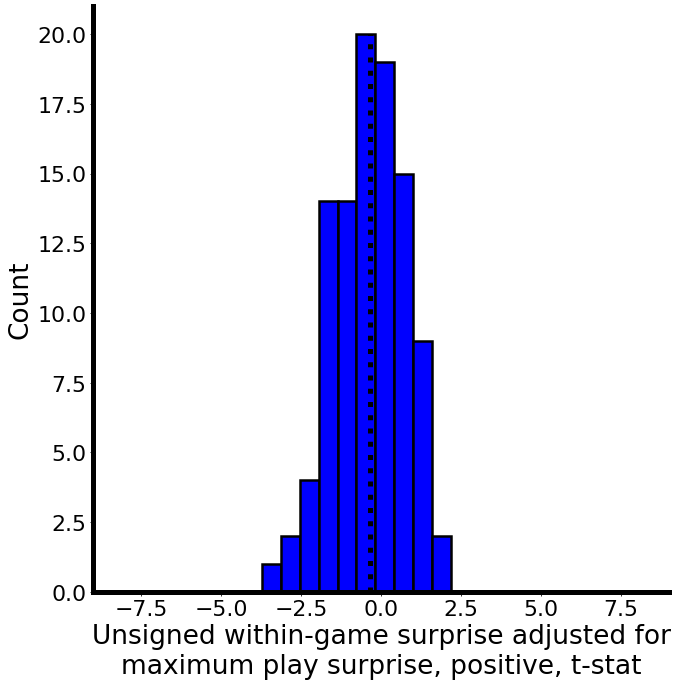

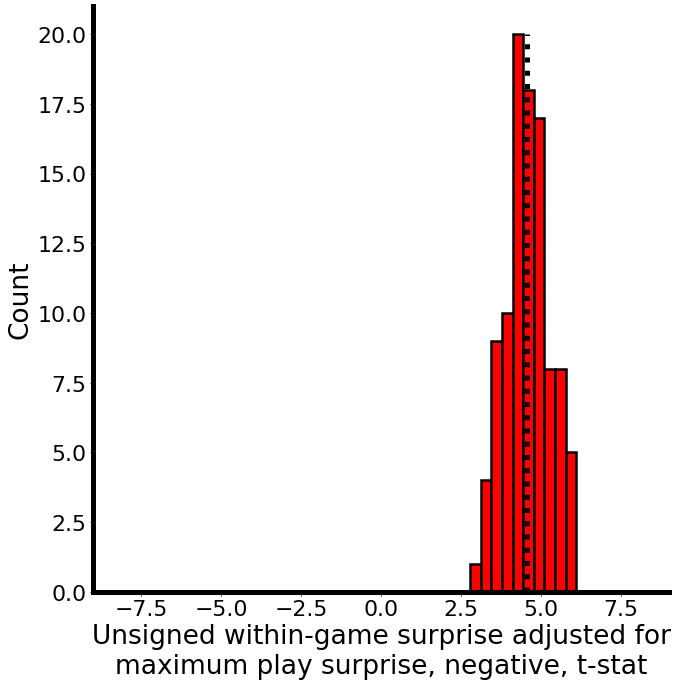

In [293]:
#plot histogram
def adj_histo(dat,lim,col,yls,sn):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    histo=plt.hist(dat,linewidth=lw/2,color=col,ec='black')
    yl=yls+', t-stat'
    ax.set_ylabel('Count',fontsize=fs*4/5)
    ax.set_xlabel(yl,fontsize=fs*4/5)
    ax.set_xlim(-lim,lim)
    plt.vlines(np.mean(dat),0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.tight_layout()
    f.savefig(sn, transparent=True)
    
qq=adj_pvals_fgp<0.05
print('pos, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_fgp)))
qq=adj_pvals_fgn<0.05
print('neg, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_fgn)))
qq=adj_pvals_wgp<0.05
print('pos, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_wgp)))
qq=adj_pvals_wgn<0.05
print('neg, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_wgn)))
    
adj_histo(adj_tstats_fgp,9,'b','''Unsigned full-game surprise adjusted for
maximum play surprise, positive''','figs/game_adj_histo_fullgamesurprise_pos.pdf')
adj_histo(adj_tstats_fgn,9,'r','''Unsigned full-game surprise adjusted for
maximum play surprise, negative''','figs/game_adj_histo_fullgamesurprise_neg.pdf')
adj_histo(adj_tstats_wgp,9,'b','''Unsigned within-game surprise adjusted for
maximum play surprise, positive''','figs/game_adj_histo_comeback_pos.pdf')
adj_histo(adj_tstats_wgn,9,'r','''Unsigned within-game surprise adjusted for
maximum play surprise, negative''','figs/game_adj_histo_comeback_neg.pdf')

adj, pos, stat = 0.4862561283910374, pval = 0.6267902938975982
adj, neg, stat = -0.799110901030604, pval = 0.4242345050444535


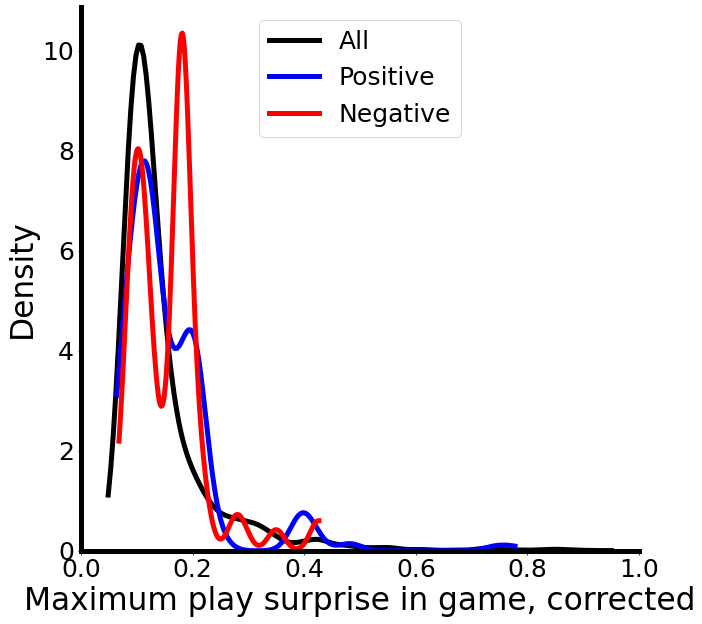

kurtosis g1: -50.885, p=0.0; kurtosis g2: -3.294, p=0.001
skewness g1: 13.595, p=0.0; kurtosis g2: 0.39, p=0.696
use mann-whitney!
adj, abs within game sur, pos vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med     df  \
0     2  22539  0.362  0.001  0.349169   69  0.369  0.03  0.403974  22606   

       stat      p      d  
0  773853.0  0.945 -0.031  


kurtosis g1: -50.885, p=0.0; kurtosis g2: -0.02, p=0.984
skewness g1: 13.595, p=0.0; kurtosis g2: 2.505, p=0.012
use mann-whitney!
adj, abs within game sur, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med     df  \
0     2  22539  0.362  0.001  0.349169   69  0.251  0.02  0.181818  22606   

        stat    p      d  
0  1022344.0  0.0  0.536  


kurtosis g1: -3.294, p=0.001; kurtosis g2: -0.02, p=0.984
skewness g1: 0.39, p=0.696; kurtosis g2: 2.505, p=0.012
use mann-whitney!
adj, abs within game sur, pos vs neg
   meth  g1n    g1m   g1s     g1med  g2n    g2m   g2s     g2med   df 

meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df    stat    p  \
0     2   69  0.529  0.046  0.524   69 -0.564  0.059 -0.742  136  4292.0  0.0   

      d  
0  2.48

In [294]:
#OLD WAY:
#BUT if we adjust this ignore values of high max surprise
coff=np.mean(maxsurs[:,0])+1.645*np.std(maxsurs[:,0]) #1.645 - keep middle 90% of data (or lower 95%)
lcoff=np.mean(maxsurs[:,0])-1.645*np.std(maxsurs[:,0])
q0=np.where(np.logical_and(gmaxsursp_a<coff,gmaxsursp_a>lcoff))[0]
stat,pval=ttest_ind(maxsurs[:,0],gmaxsursp_a[q0],nan_policy='omit')
print('adj, pos, stat = %s, pval = %s' %(stat,pval))
q1=np.where(np.logical_and(gmaxsursn_a<coff,gmaxsursn_a>lcoff))[0]

stat,pval=ttest_ind(maxsurs[:,0],gmaxsursn_a[q1],nan_policy='omit')
print('adj, neg, stat = %s, pval = %s' %(stat,pval))
#kdeplotf(maxsurs[:,0],gmaxsursp_a[q0],gmaxsursn_a[q1],'Maximum play surprise in game, corrected',[0,1],
#         'figs/game_max_play_sur_pn_corr.pdf',4)
kdeplotf(maxsurs[:,0],cumu_p,cumu_n,'Maximum play surprise in game, corrected',[0,1],
         'figs/game_max_play_sur_pn_corr.pdf',4)

astats2(mwwps[:,0],cbsp[q0],'adj, abs within game sur, pos vs null')
astats2(mwwps[:,0],cbsn[q1],'adj, abs within game sur, neg vs null')
astats2(cbsp[q0],cbsn[q1],'adj, abs within game sur, pos vs neg')

astats2(1-fwwps[:,0],np.absolute(fgsp[q0]),'adj, abs full game sur, pos vs null')
astats2(1-fwwps[:,0],np.absolute(fgsn[q1]),'adj, abs full game sur, neg vs null')
astats2(np.absolute(fgsp[q0]),np.absolute(fgsn[q1]),'adj, abs full game sur, pos vs neg')

astats2(rel_mwwps,elatdepp[q0],'adj, rel within-game sur, pos vs null')
astats2(rel_mwwps,elatdepn[q1],'adj, rel within-game sur, neg vs null')
astats2(elatdepp[q0],elatdepn[q1],'adj, rel within-game sur, pos vs neg')


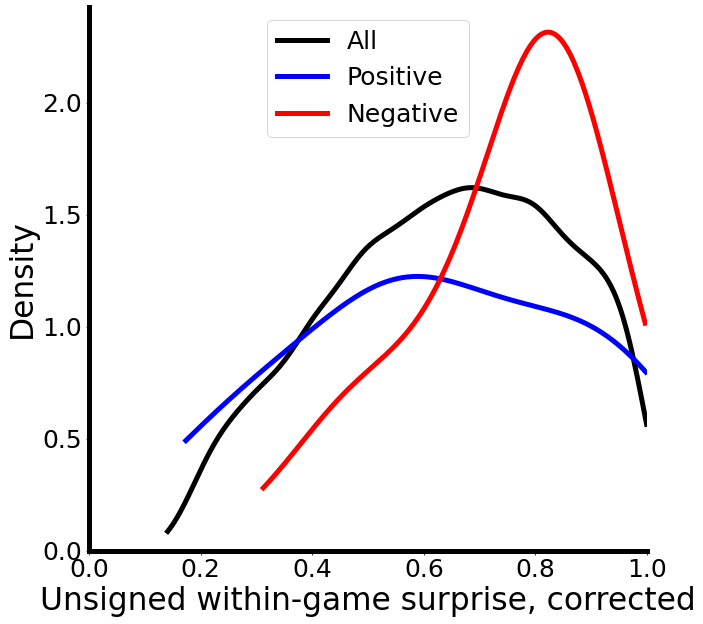

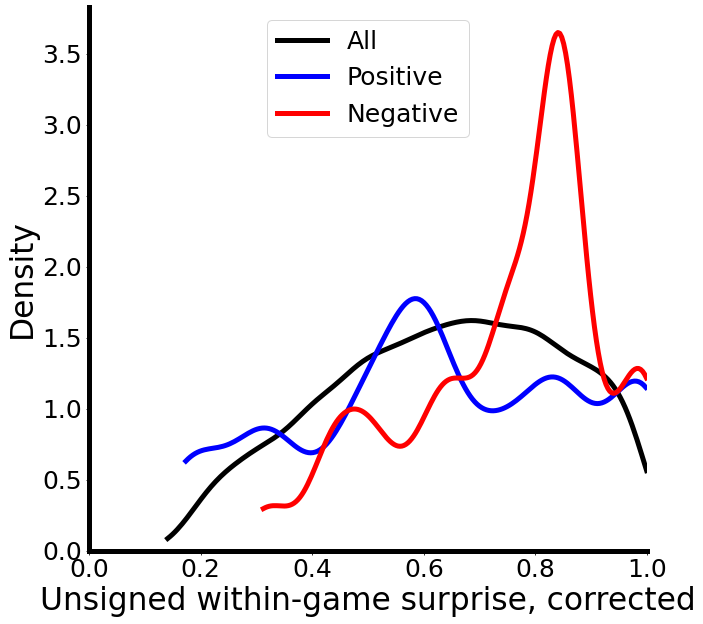

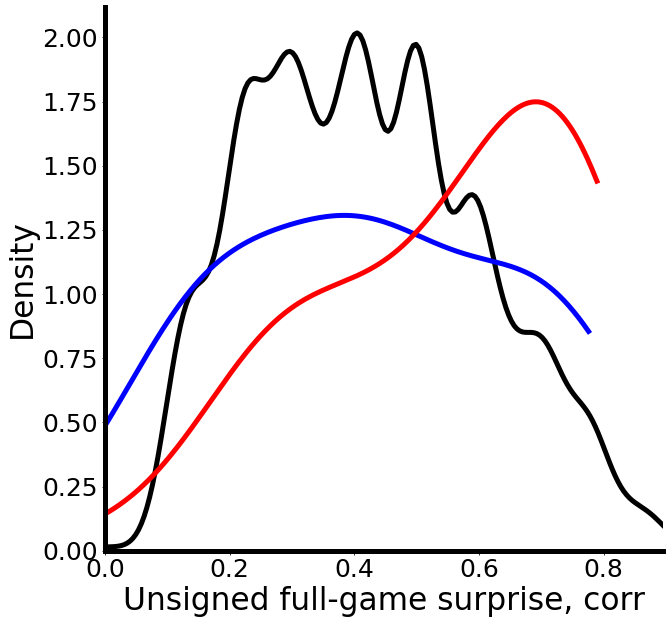

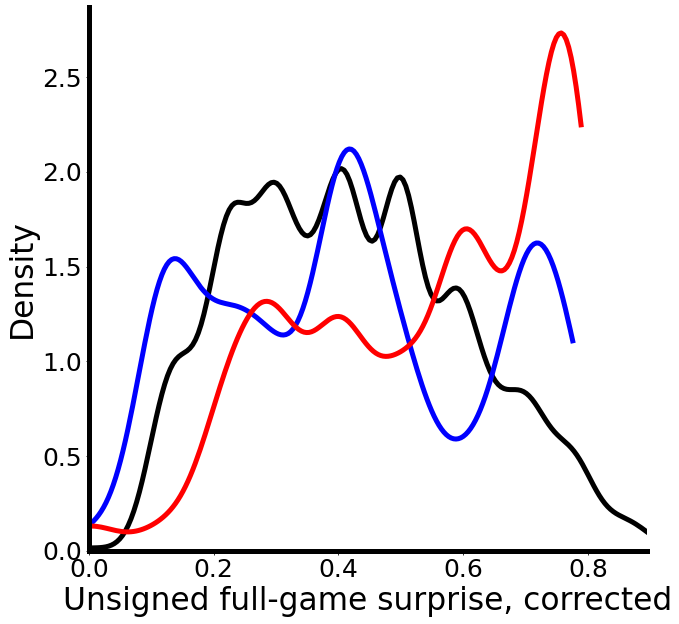

In [295]:
#look for mwwp contrasts with only these values!
kdeplotf(1-mwwps[:,0],1-cbsp[q0],1-cbsn[q1],'''Unsigned within-game surprise, corrected''',[0,1],
         'figs/game_comeback_abs_adj_example.pdf',4) #solo example
kdeplotf(1-mwwps[:,0],1-cumu_wgp,1-cumu_wgn,'''Unsigned within-game surprise, corrected''',[0,1],
         'figs/game_comeback_abs_adj.pdf',4) #cumulative
kdeplotf(1-fwwps[:,0],np.absolute(fgsp[q0]),np.absolute(fgsn[q1]),
         '''Unsigned full-game surprise, corr''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_adj_example.pdf',5)
kdeplotf(1-fwwps[:,0],cumu_fgp,cumu_fgn,
         '''Unsigned full-game surprise, corrected''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_adj.pdf',5)

<ipython-input-300-546bd0a8f5c2>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue


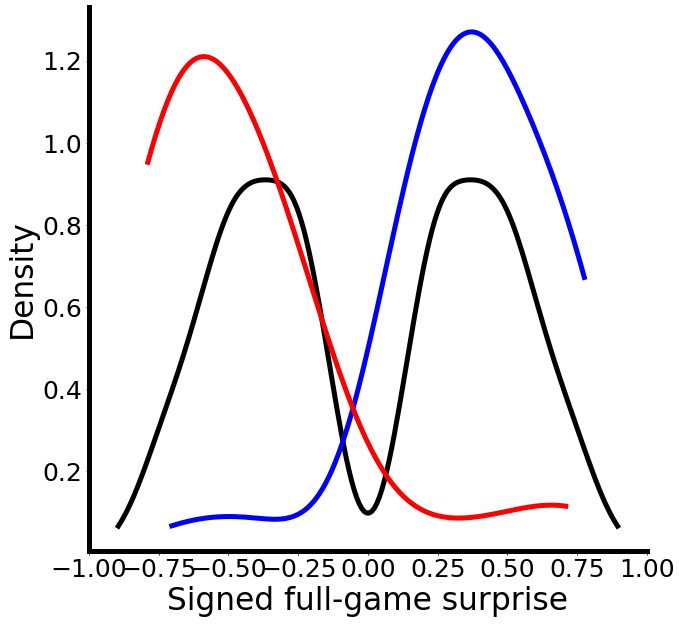

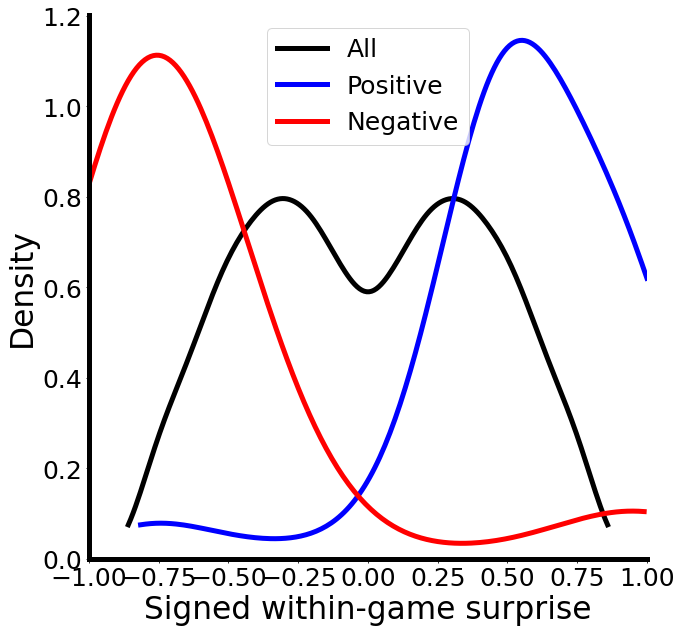

kurtosis g1: 771.101, p=0.0; kurtosis g2: 2.836, p=0.005
skewness g1: 1.0, p=0.317; kurtosis g2: -3.789, p=0.0
use mann-whitney!
signed full-game sur, pos vs null
   meth    g1n  g1m    g1s  g1med  g2n   g2m    g2s     g2med     df  \
0     2  45078 -0.0  0.002    0.0   77  0.37  0.034  0.410526  45153   

       stat    p      d  
0  988415.0  0.0 -0.806  


kurtosis g1: 771.101, p=0.0; kurtosis g2: 3.252, p=0.001
skewness g1: 1.0, p=0.317; kurtosis g2: 5.022, p=0.0
use mann-whitney!
signed full-game sur, neg vs null
   meth    g1n  g1m    g1s  g1med  g2n    g2m    g2s     g2med     df  \
0     2  45078 -0.0  0.002    0.0   74 -0.446  0.043 -0.542763  45150   

        stat    p      d  
0  2590601.0  0.0  0.971  


kurtosis g1: 2.836, p=0.005; kurtosis g2: 3.252, p=0.001
skewness g1: -3.789, p=0.0; kurtosis g2: 5.022, p=0.0
use mann-whitney!
signed full-game sur, pos vs neg
   meth  g1n   g1m    g1s     g1med  g2n    g2m    g2s     g2med   df    stat  \
0     2   77  0.37  0.034  0.4

meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df    stat    p  \
0     2   77  0.551  0.043  0.551   74 -0.591  0.056 -0.742  149  5188.0  0.0   

       d  
0  2.645

In [300]:
#max-min home
winnerp0=dfgp['Home WP after game (0/100)']
winnerp=winnerp0+0
winnerp[winnerp0==100]=1
winnerp[winnerp0==0]=-1
winnern0=dfgn['Home WP after game (0/100)']
winnern=winnern0+0
winnern[winnern0==100]=1
winnern[winnern0==0]=-1

maxminhomep=dfgp['Max Home WP within game (_ or 100)']-dfgp['Min Home WP (_ or 0)']
elatdepp=np.multiply(np.multiply(np.multiply(maxminhomep,dfgp['Cheering for? (1=H,-1=V)']),
                     winnerp),0.01)
maxminhomen=dfgn['Max Home WP within game (_ or 100)']-dfgn['Min Home WP (_ or 0)']
elatdepn=np.multiply(np.multiply(np.multiply(maxminhomen,dfgn['Cheering for? (1=H,-1=V)']),
                                 winnern),0.01)
elatdepp=elatdepp.values
elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue
#elatdepp=elatdepp.astype(float64)
elatdepn=elatdepn.values

#for all games dist, imagine that each team is cheered for in each game exactly once
#for full-game surprise
rel_fwwps=np.hstack([1-fwwps[:,0],-(1-fwwps[:,0])])
kdeplotf(rel_fwwps,dfgp['relgsur_a'],dfgn['relgsur_a'],'Signed full-game surprise',[-1,1],'figs/game_fullgame_valence.pdf',5)

#within-game surprise
rel_mwwps=np.hstack([mwwps[:,0],-mwwps[:,0]])
kdeplotf(rel_mwwps,elatdepp,elatdepn,'Signed within-game surprise',[-1,1],'figs/game_comeback_valence.pdf',4)

astats2(rel_fwwps,dfgp['relgsur_a'],'signed full-game sur, pos vs null')
astats2(rel_fwwps,dfgn['relgsur_a'],'signed full-game sur, neg vs null')
astats2(dfgp['relgsur_a'],dfgn['relgsur_a'],'signed full-game sur, pos vs neg')

astats2(rel_mwwps,elatdepp,'signed within-game sur, pos vs null')
astats2(rel_mwwps,elatdepn,'signed within-game sur, neg vs null')
astats2(elatdepp,elatdepn,'signed within-game sur, pos vs neg')

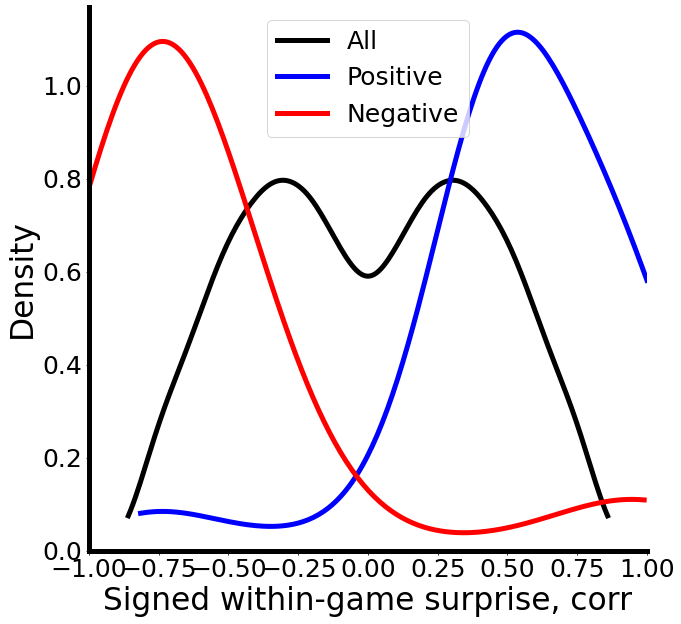

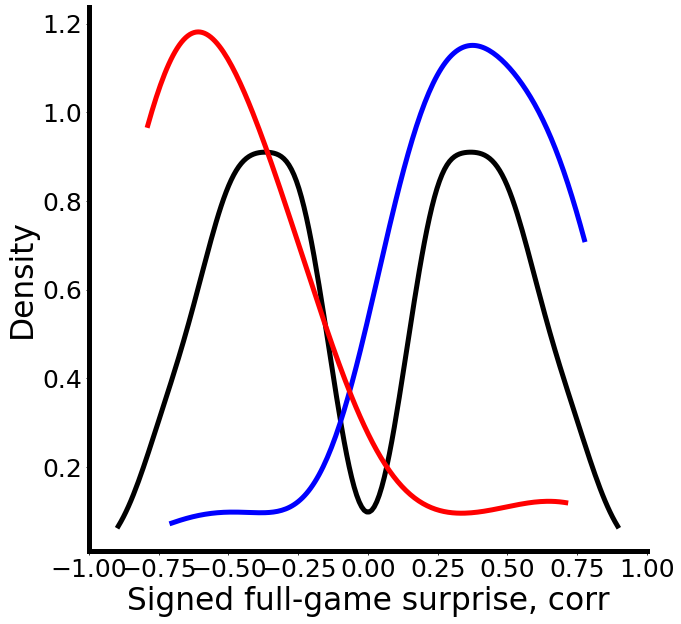

In [297]:
#not using but fyi
kdeplotf(rel_mwwps,elatdepp[q0],elatdepn[q1],'Signed within-game surprise, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',4)
#for post- minus pre-game surprise
ptemp,ntemp=dfgp['relgsur_a'].values,dfgn['relgsur_a'].values
kdeplotf(rel_fwwps,ptemp[q0],ntemp[q1],'Signed full-game surprise, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',5)

<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


kurtosis g1: -5.71, p=0.0; kurtosis g2: -1.975, p=0.048
skewness g1: -0.236, p=0.814; kurtosis g2: 0.369, p=0.712
use mann-whitney!
game spectacularity, pos vs neg
   meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df    stat    p  \
0     2   61  2.836  0.127    3.0   74  1.919  0.078    2.0  133  3365.0  0.0   

     d  
0  1.1  


r-squared,positive = 0.00014389158095890443, pval = 0.9268944669592821
r-squared,negative = 0.07182087369056464, pval = 0.02096986159403054


<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


kurtosis g1: -2.332, p=0.02; kurtosis g2: -2.211, p=0.027
skewness g1: -0.552, p=0.581; kurtosis g2: -0.233, p=0.815
use mann-whitney!
time affected, pos vs neg
   meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df    stat  \
0     2   77  3.481  0.134    3.0   74  3.297  0.133    3.0  149  3093.5   

       p      d  
0  0.346  0.157  


r-squared,positive = 0.015251862596729135, pval = 0.2845870064849969
r-squared,negative = 0.000392413699390922, pval = 0.8669589674417121


(0.4873007667293452,
 3.300413169963471,
 0.061909520316595294,
 3.3248806746603004)

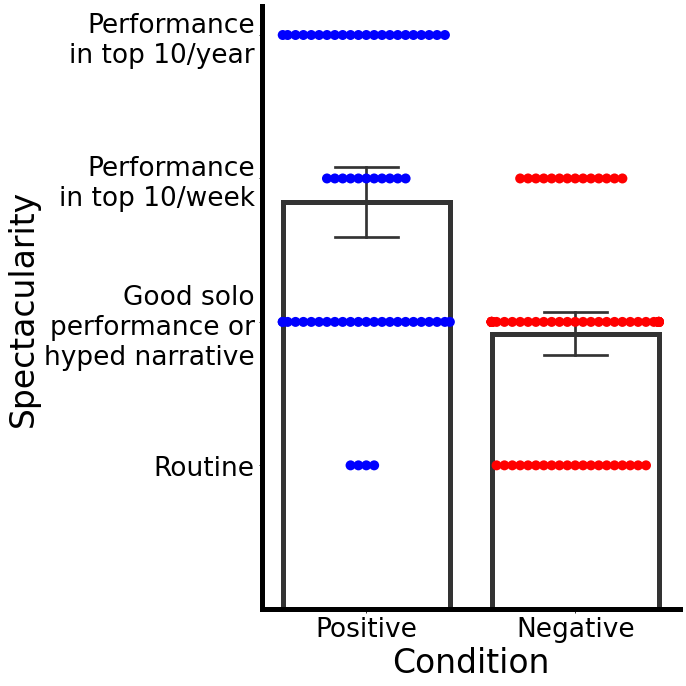

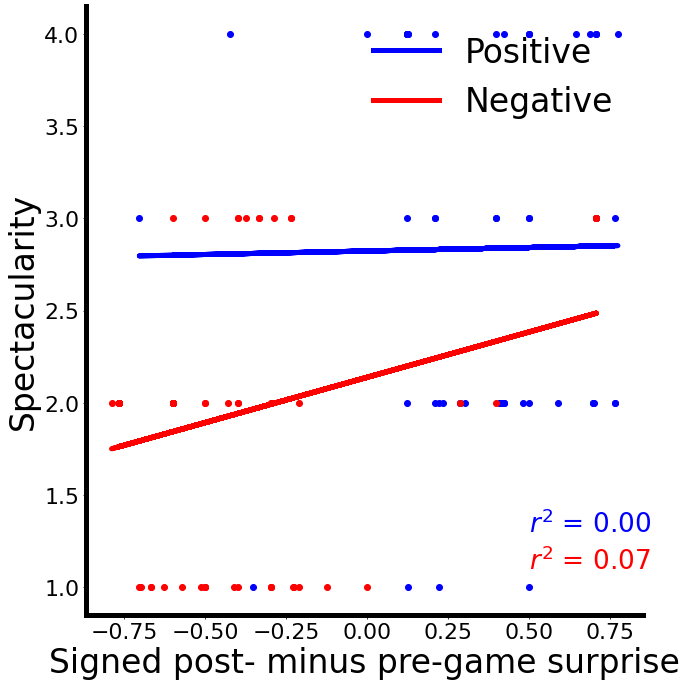

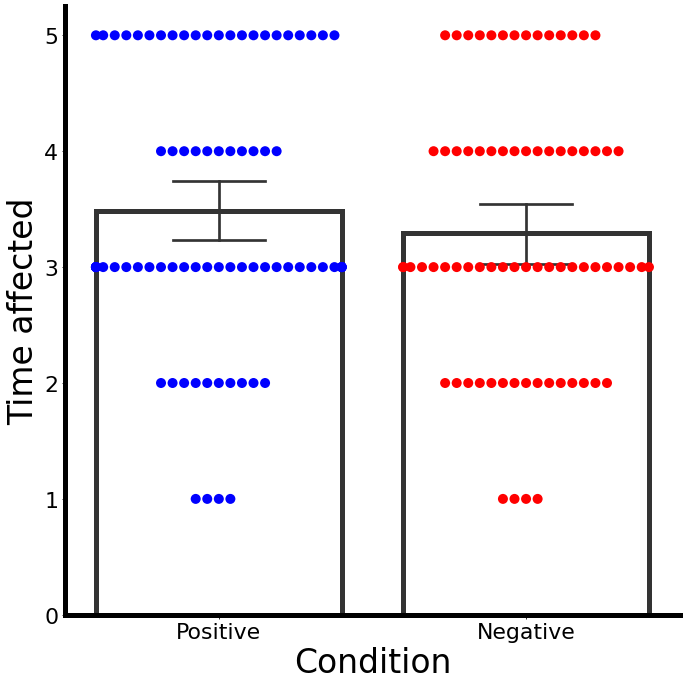

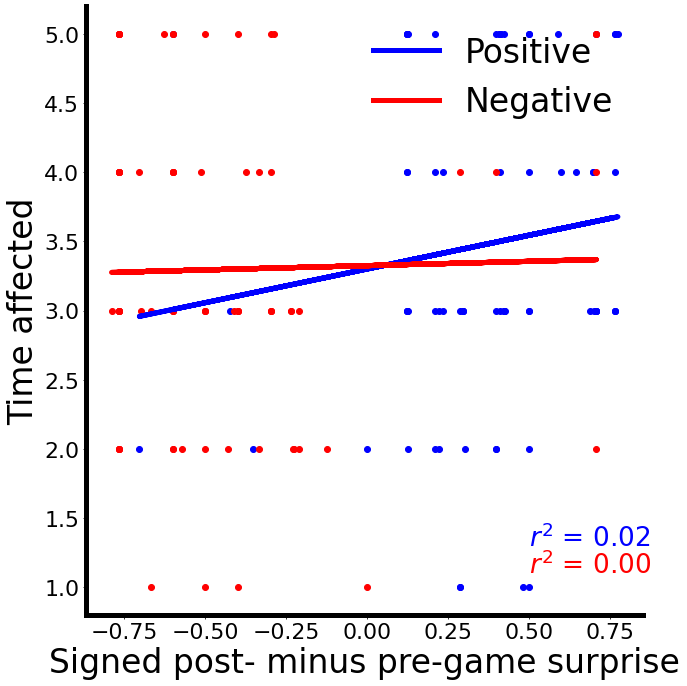

In [301]:
#spectacularity
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='Spectacularity of game?','Spectacularity'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,2)

astats2(y1[qp],y2[qn],'game spectacularity, pos vs neg')

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

#time affected
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

astats2(y1[qp],y2[qn],'time affected, pos vs neg')

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

# season data

In [302]:
#first, find starting year from Year
sp_year,sn_year=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    sp_year[i]=dfsp['Year'][dfsp.index[i]][:4]
for i in range(nsn):
    sn_year[i]=dfsn['Year'][dfsn.index[i]][:4]
dfsp['syear'],dfsn['syear']=sp_year,sn_year

nots=len(df_ots) #same length as df_svr

In [303]:
#find maximum play, full- and within-game surprises during this season
inds=[]
mxmxsurs,mxfgsurs,mxwgsurs=np.zeros((nots)),np.zeros((nots)),np.zeros((nots))
for i in range(nots): #don't use most current year, don't have pbp
    curr_y=df_svr['Starting year'][i] #find year
    s=df_svr['Team'][i] #find team index
    for ii in range(len(nba3)):
        if s == nba3[ii]:
            ix=ii+0
            break
    #find all games with this year / team 
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    qq=np.where(np.logical_and(np.logical_or(df1['home']==ix,df1['vis']==ix),
                               np.logical_or(np.logical_and(df1['year']==curr_y,df1['month']>mthc),
                                   np.logical_and(df1['year']==curr_y+1,df1['month']<mthc))))[0]
    dfq=df1.iloc[qq]
    gids=dfq.g_id.unique()
    maxsurs,maxfgsurs,maxwgsurs=np.zeros((len(gids))),np.zeros((len(gids))),np.zeros((len(gids)))
    for ii in range(len(gids)):
        qq=np.where(dfq['g_id']==gids[ii])[0]
        maxsurs[ii]=dfq['maxsur'][dfq.index[qq[0]]]
        maxfgsurs[ii]=dfq['fgsur'][dfq.index[qq[0]]]
        maxwgsurs[ii]=dfq['wgsur'][dfq.index[qq[0]]]
    mxmxsurs[i]=np.max(np.absolute(maxsurs))
    mxfgsurs[i]=np.max(np.absolute(maxfgsurs))
    mxwgsurs[i]=np.max(np.absolute(maxwgsurs))
    if i%200==0:
        print('progress:',i)
    
df_svr['mxmxsur']=mxmxsurs #add back to dataframe
df_svr['mxfgsur']=mxfgsurs
df_svr['mxwgsur']=mxwgsurs

progress: 0
progress: 200
progress: 400


In [304]:
#rank-ordered "season success" variable rather than win %
years=df_ots['Starting year'].unique()
rank_ys,pre_ranks=np.zeros((len(years),len(nba3))),np.zeros((len(years),len(nba3)))
tnop,t1r,t2r,t3r=14,8,4,2 #teams that miss the playoffs, make only 1st, 2nd, 3rd
for i in range(len(years)):
    #non-playoff teams
    q=np.where(df_ots['Starting year']==years[i])[0]
    rank_y=sss.rankdata(df_svr['Win %'][q])
    #teams making 1st round only
    q0=np.where(np.logical_and(df_ots['P1'][q]>-100000,df_ots['P2'][q].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[q0]])
    rank_y[q0]=tnop+rank_temp #add to main index
    qq=np.where(df_ots['P2'][q]>-100000)[0]
    #teams making 2nd round only
    qq0=np.where(np.logical_and(df_ots['P2'][q[qq]]>-100000,df_ots['P3'][q[qq]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qq0]]])
    rank_y[qq[qq0]]=tnop+t1r+rank_temp
    qqq=np.where(df_ots['P3'][q[qq]]>-100000)[0]
    #teams making 3rd round only
    qqq0=np.where(np.logical_and(df_ots['P3'][q[qq[qqq]]]>-100000,df_ots['P4'][q[qq[qqq]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqq0]]]])
    rank_y[qq[qqq[qqq0]]]=tnop+t1r+t2r+rank_temp
    #team losing championship
    qqqq=np.where(df_ots['P4'][q[qq[qqq]]]>-100000)[0]
    qqqq0=np.where(np.logical_and(df_ots['P4'][q[qq[qqq[qqqq]]]]>-100000,
                                  df_ots['Champ'][q[qq[qqq[qqqq]]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqqq[qqqq0]]]]])
    rank_y[qq[qqq[qqqq[qqqq0]]]]=tnop+t1r+t2r+t3r+rank_temp
    qqqqq=np.where(df_ots['Champ'][q[qq[qqq[qqqq]]]]=='** WINNER **')[0]
    rank_y[qq[qqq[qqqq[qqqqq]]]]=30
    rank_ys[i,:]=len(nba3)+1-rank_y #reverse these for final rankings (so #1 is best)
    #also do pre_odds rank (rather than as odds)
    pre_ranks[i,:]=sss.rankdata(df_ots['Pre3'].values[q])

In [370]:
low_odds,hi_odds=np.zeros((nots)),np.zeros((nots))
for i in range(nots):
    low_odds[i]=np.nanmax([np.nanmax([np.nanmax([np.nanmax( #np.nanmax([np.nanmax([np.nanmax([np.nanmax([
        [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]])#,df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]]),
        #df_ots['P4'][i]])
    hi_odds[i]=np.nanmin([np.nanmin([np.nanmin([np.nanmin( #np.nanmin([np.nanmin([np.nanmin([np.nanmin([
        [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]])#,df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]])#,
        #df_ots['P4'][i]])
df_ots['low_odds']=low_odds
df_ots['hi_odds']=hi_odds

<ipython-input-370-6b37351a5483>:4: RuntimeWarning: All-NaN axis encountered
  [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
<ipython-input-370-6b37351a5483>:9: RuntimeWarning: All-NaN axis encountered
  [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),


In [371]:
#now integrate with subject responses
wonchampp,lostchampp,pre_oddsp,low_oddsp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
hi_oddsp,recordp,rankp,pre_rankp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
mxmxsurp,mxfgsurp,mxwgsurp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
for i in range(nsp):
    curr_y=dfsp['syear'][dfsp.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsp['Team'][dfsp.index[i]] #match team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    #final preseason odds
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsp[i]=100/(100+pre3)
    else:
        pre_oddsp[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    #lowest/highest odds during season
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsp[i]=100/(100+low_o)
    else:
        low_oddsp[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if hi_o>0:
        hi_oddsp[i]=100/(100+hi_o)
    else:
        hi_oddsp[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordp[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampp[i]=1
        else:
            lostchampp[i]=1
    qqq=np.where(years==curr_y)[0]
    rankp[i]=rank_ys[int(qqq[0]),int(qq)] #season success rank
    pre_rankp[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurp[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurp[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurp[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2007.0,BOS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2013.0,SAS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,TOR
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,POR
rows, rows:30,1
Year, team:2

In [372]:
wonchampn,lostchampn,pre_oddsn,low_oddsn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
hi_oddsn,recordn,rankn,pre_rankn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
mxmxsurn,mxfgsurn,mxwgsurn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
for i in range(nsn):
    curr_y=dfsn['syear'][dfsn.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsn['Team'][dfsn.index[i]] #match home team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsn[i]=100/(100+pre3)
    else:
        pre_oddsn[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsn[i]=100/(100+low_o)
    else:
        low_oddsn[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if hi_o>0:
        hi_oddsn[i]=100/(100+hi_o)
    else:
        hi_oddsn[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordn[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampn[i]=1
        else:
            lostchampn[i]=1
    qqq=np.where(years==curr_y)[0]
    rankn[i]=rank_ys[int(qqq[0]),int(qq)]
    pre_rankn[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurn[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurn[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurn[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,POR
rows, rows:30,1
Year, team:2019.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2013.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,CLE
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,LAL
rows, rows:30,1
Year, team:2014.0,MIL
rows, rows:30,1
Year, team:2019.0,LAC
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2020.0,SAC
rows, rows:30,1
Year, team:2017.0,LAL
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2019.0,DEN
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2

kurtosis g1: -19.157, p=0.0; kurtosis g2: -1.8, p=0.072
skewness g1: 1.427, p=0.154; kurtosis g2: 0.132, p=0.895
use mann-whitney!
max play sur in szn, pos vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s  g2med   df     stat  \
0     2  510  0.617  0.008  0.583418   96  0.603  0.015    0.6  604  25049.5   

       p      d  
0  0.718  0.086  


kurtosis g1: -19.157, p=0.0; kurtosis g2: -1.825, p=0.068
skewness g1: 1.427, p=0.154; kurtosis g2: 2.423, p=0.015
use mann-whitney!
max play sur in szn, neg vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.617  0.008  0.583418   83  0.595  0.018  0.588653  591   

      stat      p      d  
0  22583.0  0.327  0.129  


kurtosis g1: -13.981, p=0.0; kurtosis g2: 1.537, p=0.124
skewness g1: -2.614, p=0.009; kurtosis g2: -4.67, p=0.0
use mann-whitney!
max full-game sur in szn, pos vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.828  0.

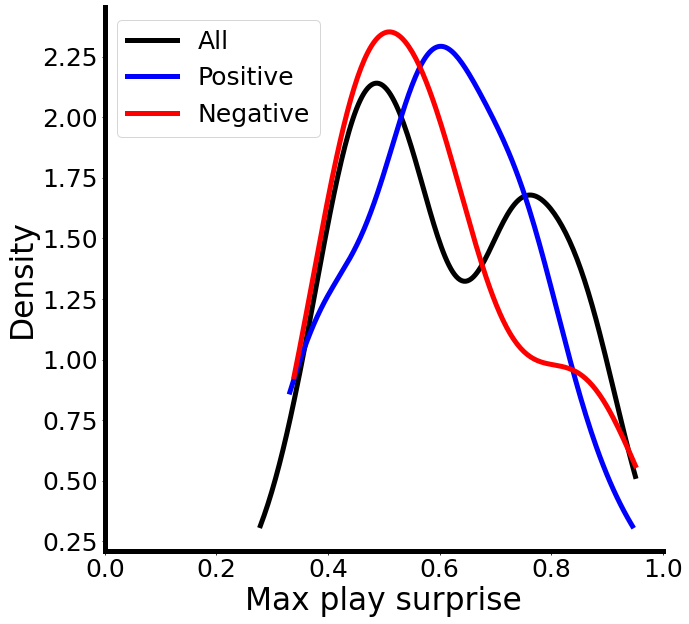

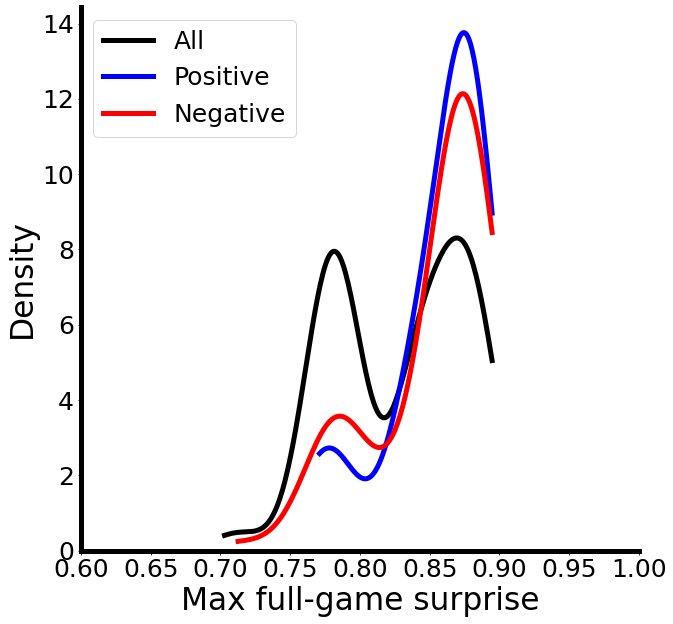

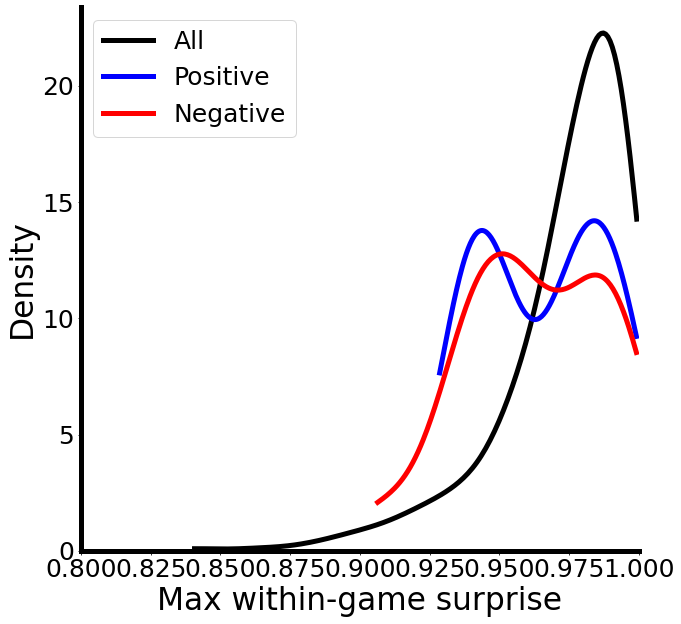

In [373]:
astats2(mxmxsurs,mxmxsurp,'max play sur in szn, pos vs null')
astats2(mxmxsurs,mxmxsurn,'max play sur in szn, neg vs null')
astats2(mxfgsurs,mxfgsurp,'max full-game sur in szn, pos vs null')
astats2(mxfgsurs,mxfgsurn,'max full-game sur in szn, neg vs null')
astats2(mxwgsurs,mxwgsurp,'max within-game sur in szn, pos vs null')
astats2(mxwgsurs,mxwgsurn,'max within-game sur in szn, neg vs null')

kdeplotf(mxmxsurs,mxmxsurp,mxmxsurn,'Max play surprise',[0,1],'figs/season_play_sur.pdf',0)
kdeplotf(mxfgsurs,mxfgsurp,mxfgsurn,'Max full-game surprise',[0.6,1],'figs/season_fgame_sur.pdf',0)
kdeplotf(mxwgsurs,mxwgsurp,mxwgsurn,'Max within-game surprise',[0.8,1],'figs/season_wgame_sur.pdf',0)

kurtosis g1: -13.981, p=0.0; kurtosis g2: -2.02, p=0.043
skewness g1: -2.614, p=0.009; kurtosis g2: -2.194, p=0.028
use mann-whitney!
adjusted max full-game sur, pos vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.828  0.002  0.835789   51  0.834  0.005  0.835789  559   

      stat      p      d  
0  12823.0  0.869 -0.145  


kurtosis g1: -13.981, p=0.0; kurtosis g2: -1.185, p=0.236
skewness g1: -2.614, p=0.009; kurtosis g2: -2.191, p=0.028
use mann-whitney!
adjusted max full-game sur, neg vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.828  0.002  0.835789   52  0.834  0.006  0.853306  560   

      stat      p      d  
0  12392.0  0.434 -0.144  




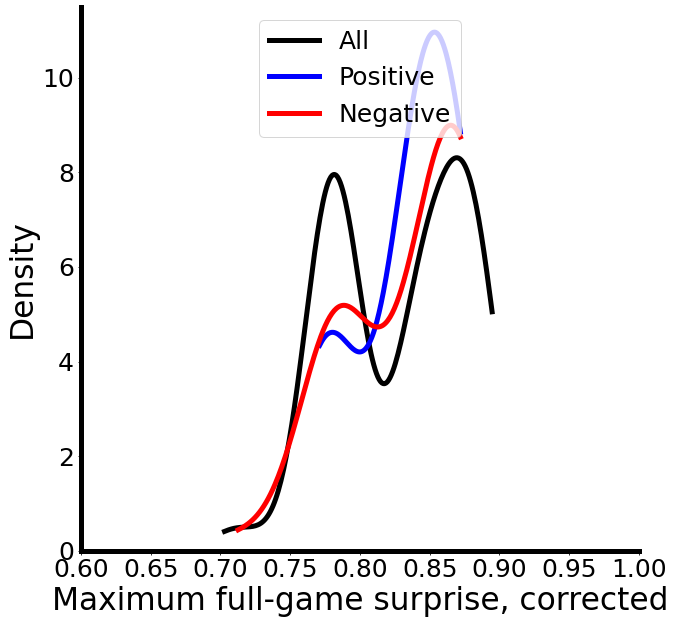

kurtosis g1: 7.545, p=0.0; kurtosis g2: -3.127, p=0.002
skewness g1: -11.978, p=0.0; kurtosis g2: -1.781, p=0.075
use mann-whitney!
adjusted max within-game sur, pos vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.974  0.001  0.980262   69  0.976  0.002  0.975806  577   

      stat      p      d  
0  17829.5  0.858 -0.085  


kurtosis g1: 7.545, p=0.0; kurtosis g2: -10.908, p=0.0
skewness g1: -11.978, p=0.0; kurtosis g2: -0.609, p=0.543
use mann-whitney!
adjusted max within-game sur, neg vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.974  0.001  0.980262   58  0.975  0.002  0.980392  566   

      stat      p      d  
0  15575.0  0.508 -0.052  




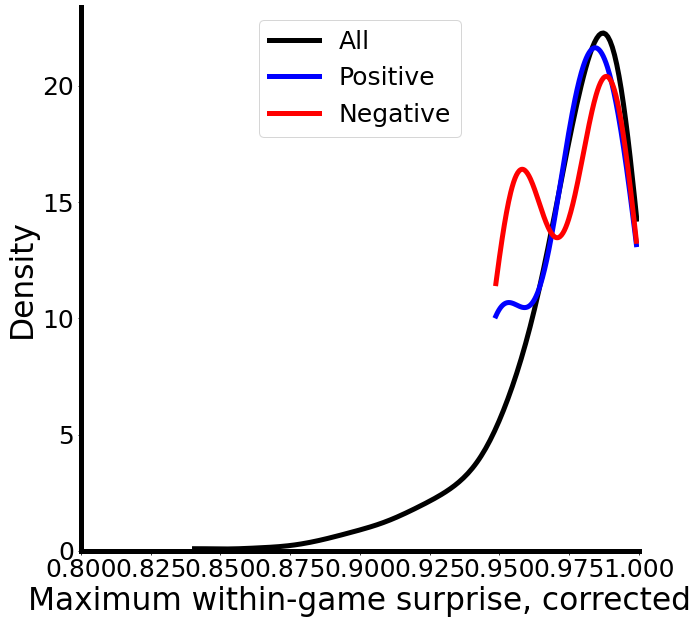

In [374]:
#OLD WAY - for new way, see below after we set residp_val
coff=0.875
lcoff=0.6
qfgp=np.where(np.logical_and(mxfgsurp<coff,mxfgsurp>lcoff))[0]
qfgn=np.where(np.logical_and(mxfgsurn<coff,mxfgsurn>lcoff))[0]

astats2(mxfgsurs,mxfgsurp[qfgp],'adjusted max full-game sur, pos vs null')
astats2(mxfgsurs,mxfgsurn[qfgn],'adjusted max full-game sur, neg vs null')

kdeplotf(mxfgsurs,mxfgsurp[qfgp],mxfgsurn[qfgn],'Maximum full-game surprise, corrected',[0.6,1],
         'figs/season_fgame_sur_pn_corr.pdf',4)

coff=1
lcoff=0.94
qwgp=np.where(np.logical_and(mxwgsurp<coff,mxwgsurp>lcoff))[0]
qwgn=np.where(np.logical_and(mxfgsurn<coff,mxwgsurn>lcoff))[0]

astats2(mxwgsurs,mxwgsurp[qwgp],'adjusted max within-game sur, pos vs null')
astats2(mxwgsurs,mxwgsurn[qwgn],'adjusted max within-game sur, neg vs null')

kdeplotf(mxwgsurs,mxwgsurp[qwgp],mxwgsurn[qwgn],'Maximum within-game surprise, corrected',[0.8,1],
         'figs/season_wgame_sur_pn_corr.pdf',4)

r-squared = 0.4355661839635033, p = 4.343893377519194e-65


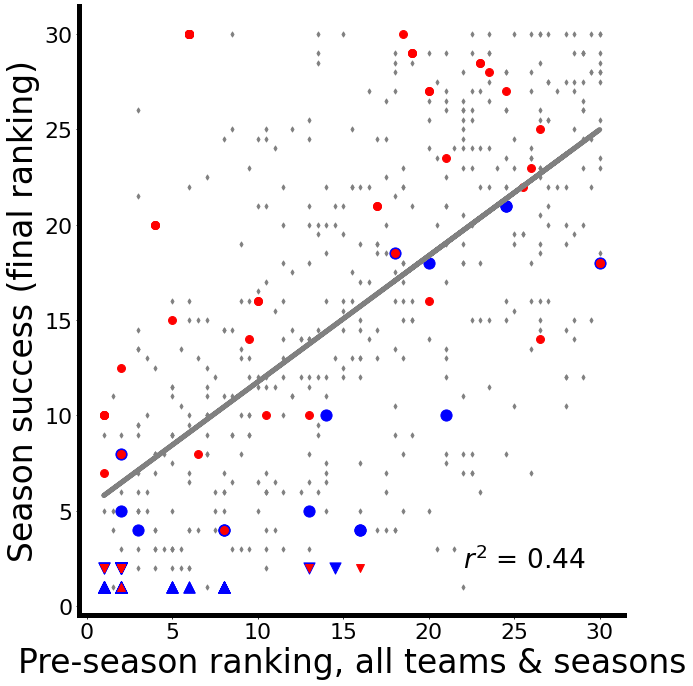

In [385]:
#relationship between pre_odds and record
#re-run this using different predictor (inv) values and outv=2
inv=4 #which odds to use: 1=pre-season,2=lowest in season,3=highest in season,4=pre_rank
outv=2 #outcome variable: 1=regular season record,2=season ranking

final_record=df_svr['Win %'].values
pre_rank_a=np.matrix.flatten(pre_ranks)
final_rank=np.matrix.flatten(rank_ys)

if inv<4:
    if inv==1:
        q=df_ots['Pre3'].values
    elif inv==2:
        q=df_ots['low_odds'].values
    elif inv==3:
        q=df_ots['hi_odds'].values
    odds_a=np.zeros((len(df_ots)))
    odds_a[q>0]=100/(100+q[q>0])
    odds_a[q<=0]=np.absolute(q[q<=0])/(100+np.absolute(q[q<=0]))
    if inv==1:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(pre_oddsp)+0,np.log(pre_oddsn)+0
        xl='''Log pre-season championship
probability, all teams & seasons'''
    elif inv==2:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(low_oddsp)+0,np.log(low_oddsn)+0
        xl='''Log lowest championship probabillity
during season, all teams & seasons'''
    elif inv==3:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(hi_oddsp)+0,np.log(hi_oddsn)+0
        xl='''Log highest championship odds
during season, all teams & seasons'''
elif inv==4:
    x_a,x_p,x_n=pre_rank_a+0,pre_rankp+0,pre_rankn+0
    xl='''Pre-season ranking, all teams & seasons'''

if outv==1:
    y_a,y_p,y_n=final_record+0,recordp+0,recordn+0
    yl='Season win %, all teams & seasons'
elif outv==2:
    y_a,y_p,y_n=final_rank+0,rankp+0,rankn+0
    yl='Season success (final ranking)'

sz=125
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
x,y,lw3=x_a,y_a,2
plt.scatter(x,y,c='gray',marker='d',s=sz*0.1)
a,b=np.polyfit(x,y,1)
plt.plot(x, a*x+b,'gray',linewidth=lw)
ax.set_xlabel(xl,fontsize=fs)
ax.set_ylabel(yl,fontsize=fs)
corr, corr_p = pearsonr(x,y)
print('r-squared = %s, p = %s' %(corr**2,corr_p))

x,y=x_p[wonchampp+lostchampp==0],y_p[wonchampp+lostchampp==0] #add positive seasons
plt.scatter(x,y,c='b',marker='o',s=sz)
x,y=x_p[wonchampp==1],y_p[wonchampp==1] 
plt.scatter(x,y,c='b',marker='^',s=sz)
x,y=x_p[lostchampp==1],y_p[lostchampp==1] 
plt.scatter(x,y,c='b',marker='v',s=sz)

x,y=x_n[wonchampn+lostchampn==0],y_n[wonchampn+lostchampn==0] 
plt.scatter(x,y,c='r',marker='o',s=sz*0.5)
x,y=x_n[wonchampn==1],y_n[wonchampn==1] 
plt.scatter(x,y,c='r',marker='^',s=sz*0.5)
x,y=x_n[lostchampn==1],y_n[lostchampn==1] 
plt.scatter(x,y,c='r',marker='v',s=sz*0.5)
if np.logical_and(inv==4,outv==2):
    ax.text(22,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
elif np.logical_and(inv==3,outv==2):
    ax.text(-7,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
elif np.logical_and(inv==1,outv==2):
    ax.text(-8,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
fn='figs/season_odds_records-' + str(inv) + '-' + str(outv) + '.pdf'
f.savefig(fn, transparent=True)

<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-280-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; yo

kurtosis g1: 2.323, p=0.02
skewness g1: -1.499, p=0.134
use wilcoxon!
szn sur, resid, pos vs null
   meth  g1n    g1m    g1s  df   stat    p     dz     g1med
0     2   96 -5.522  0.257  95 -8.508  0.0 -2.194 -4.810944


kurtosis g1: 5.435, p=0.0
skewness g1: 7.777, p=0.0
use wilcoxon!
szn sur, actual, pos vs null
   meth  g1n    g1m   g1s  df   stat    p     dz  g1med
0     2   96  2.766  0.43  95 -8.632  0.0  0.657    1.0


kurtosis g1: -3.556, p=0.0
skewness g1: 1.901, p=0.057
use wilcoxon!
szn sur, resid, neg vs null
   meth  g1n    g1m    g1s  df   stat      p     dz    g1med
0     2   83  4.475  1.106  82 -2.864  0.004  0.444  2.56846


kurtosis g1: -41.614, p=0.0
skewness g1: 0.152, p=0.879
use wilcoxon!
szn sur, actual, neg vs null
   meth  g1n   g1m    g1s  df   stat      p     dz  g1med
0     2   83  15.5  1.268  82 -0.885  0.376  1.342   16.0


kurtosis g1: 0.965, p=0.334
skewness g1: 0.642, p=0.521
assume normality
szn sur, resid, full-game sur equated, pos vs null
   meth  

/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


meth  g1n    g1m    g1s  df   stat    p    dz     g1med
0     2   56  9.054  1.222  55 -5.403  0.0  0.99  7.726319

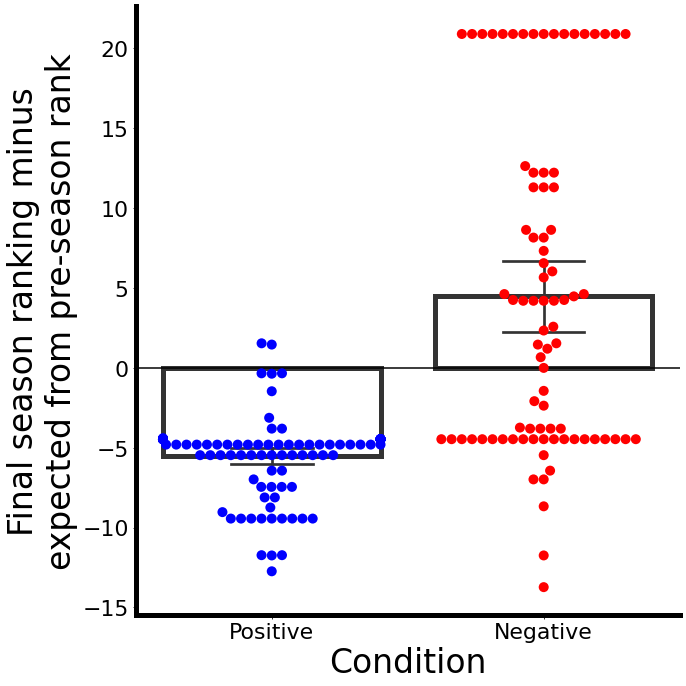

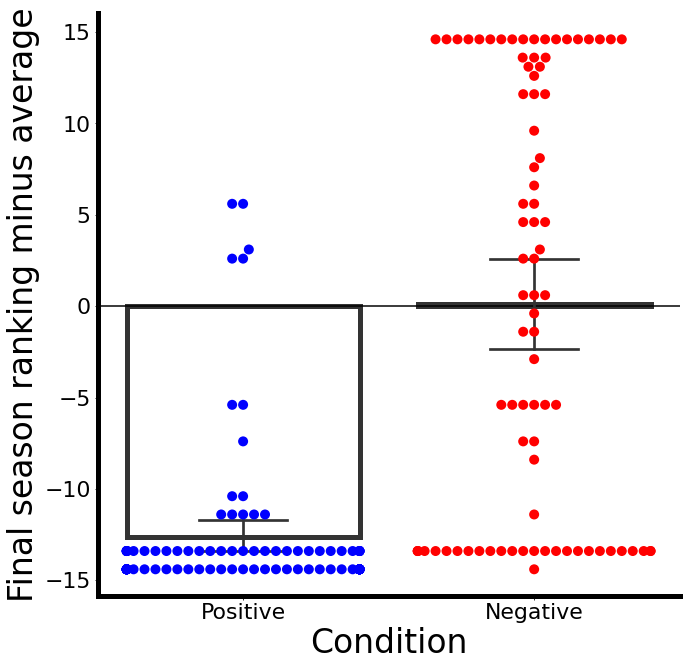

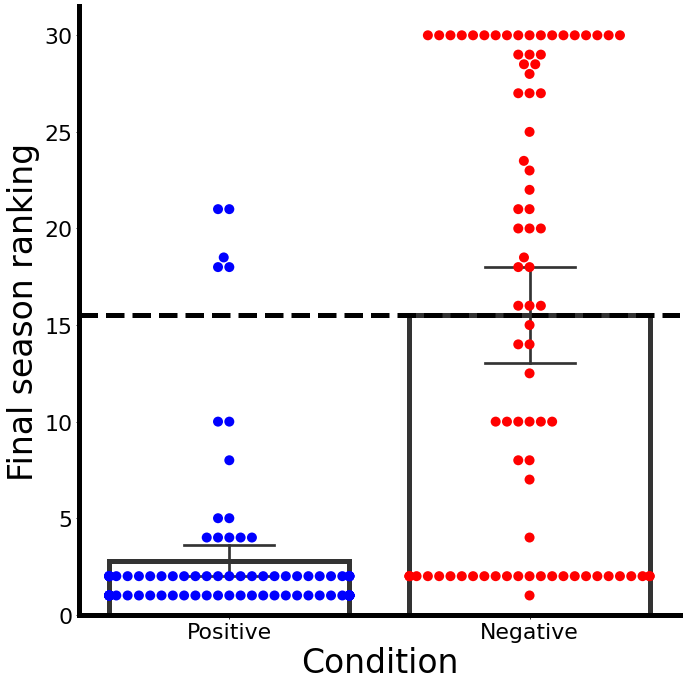

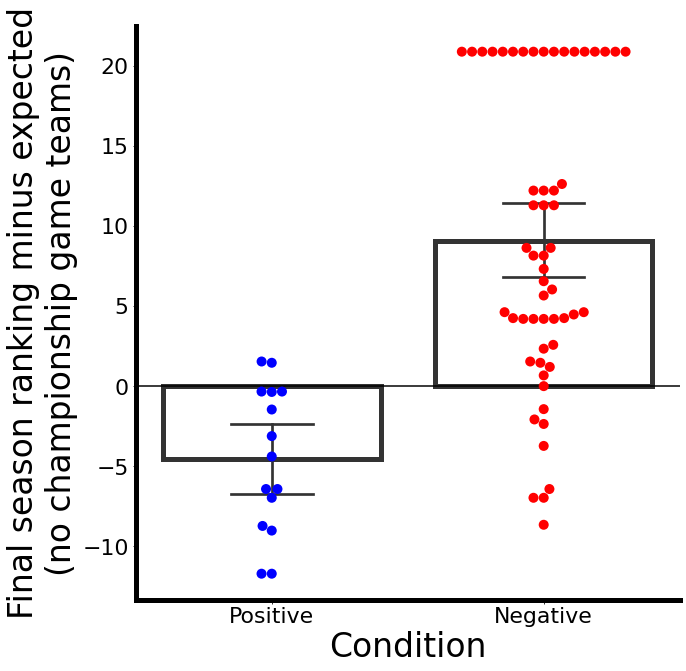

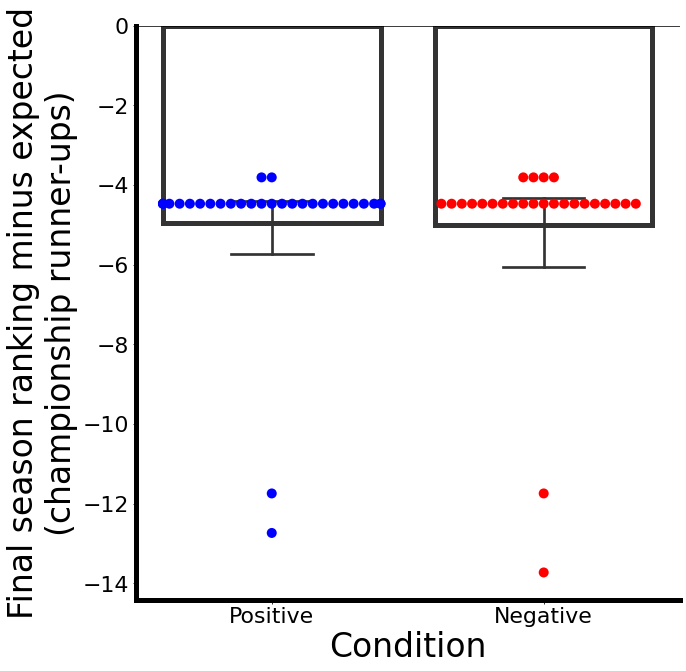

In [386]:
## do contrasts ONLY w/ actual wins - look vs. residual analysis
x1,y1=x_p+0,y_p+0 # positive seasons
x2,y2=x_n+0,y_n+0 # negative seasons

residp=y1-(a*x1+b)
residn=y2-(a*x2+b)
residp_val=np.multiply(residp,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
residn_val=np.multiply(residn,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

residp_vsavg=y1-np.mean(y_a)
residn_vsavg=y2-np.mean(y_a)
residp_vsavg=np.multiply(residp_vsavg,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
residn_vsavg=np.multiply(residn_vsavg,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

if outv==1:
    yl='''Wins minus expected x valence'''
    yl2='''Season win % x valence'''
    yl3='''Season win %'''
    yl4='''Season win %
(no championship game teams)'''
    yl4='''Season win %
(championship runner-ups)'''
elif outv==2:
    if inv==1:
        yl='''Final season ranking minus expected
from pre-season probability'''
    elif inv==3:
        yl='''Final season ranking minus expected
from max championship probability'''
    elif inv==4:
        yl='''Final season ranking minus
expected from pre-season rank'''
    yl2='''Final season ranking minus average'''
    yl3='''Final season ranking'''
    yl4='''Final season ranking minus expected
(no championship game teams)'''
    yl5='''Final season ranking minus expected
(championship runner-ups)'''
    
fn='figs/season_actualVexpected-' + str(inv) + '-' + str(outv) + '.pdf'
barswarm(residp_val,residn_val,'Residual',yl,fn,0)
fn='figs/season_actualXvalence.pdf'
barswarm(residp_vsavg,residn_vsavg,'Actual',yl2,fn,0)
fn='figs/season_actual.pdf'
barswarm(y1,y2,'Actual',yl3,fn,3)
qp,qn=np.where((wonchampp+lostchampp)==0)[0],np.where((wonchampn+lostchampn)==0)[0]
fn='figs/season_actualVexpectedXvalence_nochamp.pdf'
barswarm(residp_val[qp],residn_val[qn],'ResidualNoChamp',yl4,fn,0)
qp,qn=np.where((lostchampp)==1)[0],np.where((lostchampn)==1)[0]
fn='figs/season_actualVexpectedXvalence_runnerups.pdf'
barswarm(residp_val[qp],residn_val[qn],'ResidualRunnerups',yl5,fn,0)

astats1(residp_val,0,'szn sur, resid, pos vs null')
astats1(y1,np.mean(y_a),'szn sur, actual, pos vs null')
astats1(residn_val,0,'szn sur, resid, neg vs null')
astats1(y2,np.mean(y_a),'szn sur, actual, neg vs null')

astats1(residp_val[qfgp],0,'szn sur, resid, full-game sur equated, pos vs null')
astats1(residn_val[qfgn],0,'szn sur, resid, full-game sur equated, neg vs null')
astats1(residp_val[qwgp],0,'szn sur, resid, within-game sur equated, pos vs null')
astats1(residn_val[qwgn],0,'szn sur, resid, within-game sur equated, neg vs null')

astats2(residp_val,residn_val,'szn sur, resid, pos vs neg')
astats2(y1,y2,'szn sur, actual, pos vs neg')

qp,qn=np.where((wonchampp+lostchampp)==0)[0],np.where((wonchampn+lostchampn)==0)[0]
astats1(residp_val[qp],0,'szn sur, resid, no champ game, pos vs null')
astats1(residn_val[qn],0,'szn sur, resid, no champ game, neg vs null')

In [229]:
#permutation analysis equating max full-game / within-game surprise
iters,n_iters,pthr=0,100,0.1
adj_tstats_sp_wgp,adj_pvals_sp_wgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_sp_fgp,adj_pvals_sp_fgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_sn_wgn,adj_pvals_sn_wgn=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_sn_fgn,adj_pvals_sn_fgn=np.zeros((n_iters)),np.zeros((n_iters))
cumu_sp_wgp,cumu_sn_wgn,cumu_sp_fgp,cumu_sn_fgn=[],[],[],[] #cumulative distributions
while iters<n_iters:
    #positive full-game first
    nv=mxfgsurp.shape[0]
    q0=np.random.choice(nv,nv*2//3) #make note of this in methods - couldn't do w/ full sample!
    qval=mxfgsurp[q0]
    stat,pval=ttest_ind(mxfgsurs,qval,nan_policy='omit')
    if pval>pthr:
        stat,pval=stats.ttest_1samp(residp_val[q0],popmean=0,nan_policy='omit')
        adj_tstats_sp_fgp[iters]=stat
        adj_pvals_sp_fgp[iters]=pval
        cumu_sp_fgp=np.hstack([cumu_sp_fgp,residp_val[q0]])
        iters+=1

iters=0
while iters<n_iters:
    nv=mxwgsurp.shape[0]
    q0=np.random.choice(nv,nv*2//3) 
    qval=mxwgsurp[q0]
    stat,pval=ttest_ind(mxwgsurs,qval,nan_policy='omit')
    if pval>pthr:
        stat,pval=stats.ttest_1samp(residp_val[q0],popmean=0,nan_policy='omit')
        adj_tstats_sp_wgp[iters]=stat
        adj_pvals_sp_wgp[iters]=pval
        cumu_sp_wgp=np.hstack([cumu_sp_wgp,residp_val[q0]])
        iters+=1
        
iters=0
while iters<n_iters:
    nv=mxfgsurn.shape[0]
    q0=np.random.choice(nv,nv*2//3) 
    qval=mxfgsurn[q0]
    stat,pval=ttest_ind(mxfgsurs,qval,nan_policy='omit')
    if pval>pthr:
        stat,pval=stats.ttest_1samp(residn_val[q0],popmean=0,nan_policy='omit')
        adj_tstats_sn_fgn[iters]=stat
        adj_pvals_sn_fgn[iters]=pval
        cumu_sn_fgn=np.hstack([cumu_sn_fgn,residn_val[q0]])
        iters+=1

iters=0
while iters<n_iters:
    nv=mxwgsurn.shape[0]
    q0=np.random.choice(nv,nv*2//3) 
    qval=mxwgsurn[q0]
    stat,pval=ttest_ind(mxwgsurs,qval,nan_policy='omit')
    if pval>pthr:
        stat,pval=stats.ttest_1samp(residn_val[q0],popmean=0,nan_policy='omit')
        adj_tstats_sn_wgn[iters]=stat
        adj_pvals_sn_wgn[iters]=pval
        cumu_sn_wgn=np.hstack([cumu_sn_wgn,residn_val[q0]])
        iters+=1

In [230]:
qq=adj_pvals_sp_fgp<0.05
print('pos, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_sp_fgp)))
qq=adj_pvals_sn_fgn<0.05
print('neg, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_sn_fgn)))
qq=adj_pvals_sp_wgp<0.05
print('pos, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_sp_wgp)))
qq=adj_pvals_sn_wgn<0.05
print('neg, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_sn_wgn)))

pos, adj for fg, nsig:1.0
neg, adj for fg, nsig:0.94
pos, adj for wg, nsig:1.0
neg, adj for wg, nsig:0.93


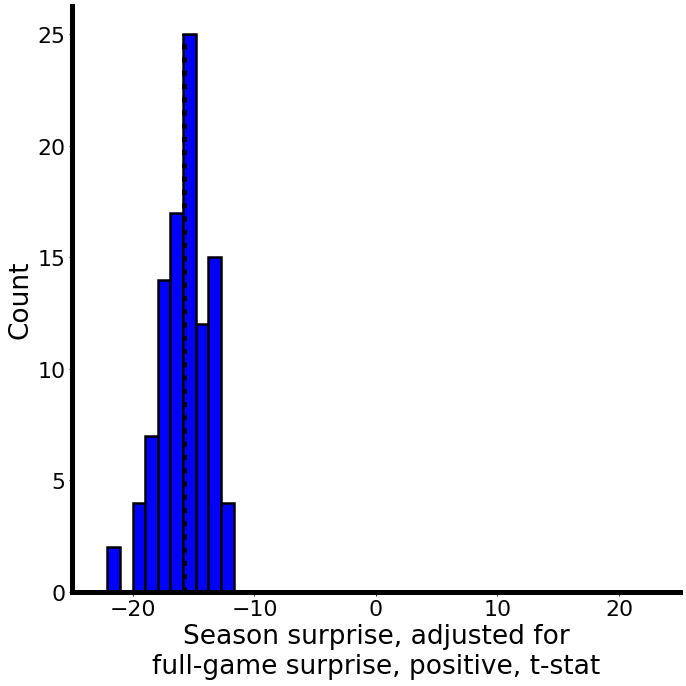

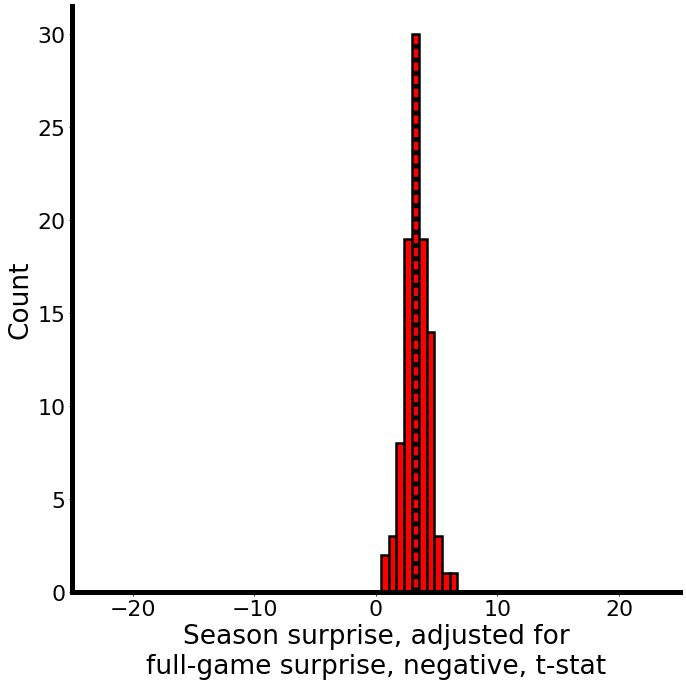

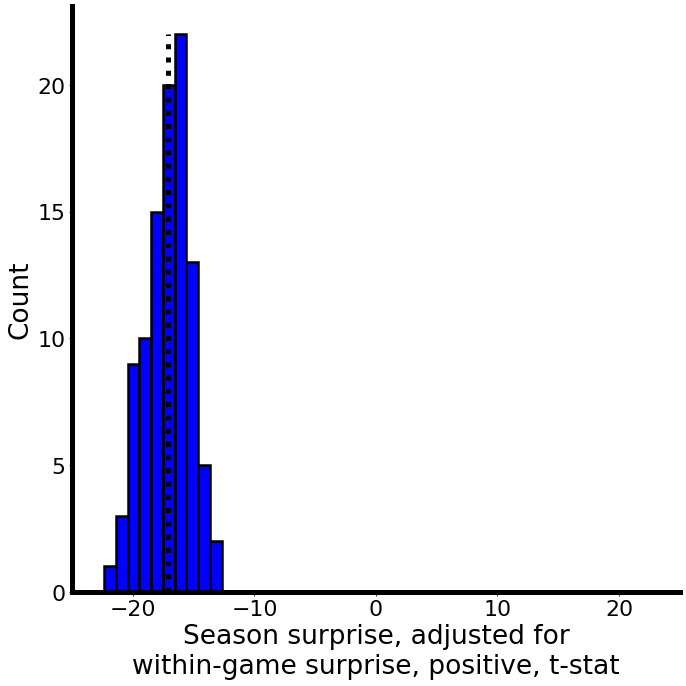

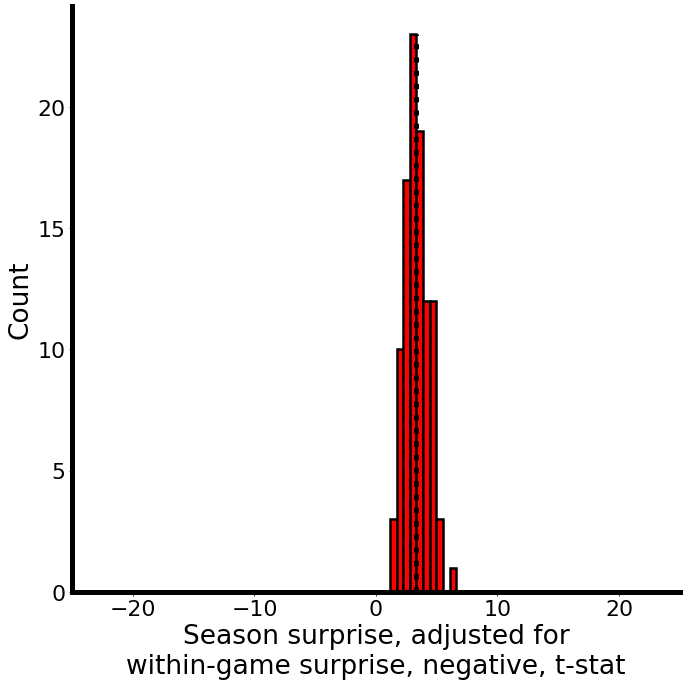

In [231]:
adj_histo(adj_tstats_sp_fgp,25,'b','''Season surprise, adjusted for
full-game surprise, positive''','figs/season_adj_histo_fgsurp.pdf')
adj_histo(adj_tstats_sn_fgn,25,'r','''Season surprise, adjusted for
full-game surprise, negative''','figs/season_adj_histo_fgsurn.pdf')
adj_histo(adj_tstats_sp_wgp,25,'b','''Season surprise, adjusted for
within-game surprise, positive''','figs/season_adj_histo_wgsurp.pdf')
adj_histo(adj_tstats_sn_wgn,25,'r','''Season surprise, adjusted for
within-game surprise, negative''','figs/season_adj_histo_wgsurn.pdf')

<ipython-input-201-477f977d3425>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


kurtosis g1: 0.734, p=0.463; kurtosis g2: 1.542, p=0.123
skewness g1: -3.548, p=0.0; kurtosis g2: -3.225, p=0.001
use mann-whitney!
time affected, pos vs neg
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  3.411  0.184  3.357  0.155  141  2781.0  0.345  0.037


r-squared,positive = 0.0003695968230198624, pval = 0.8717488648162937
r-squared,negative = 0.006413151367405522, pval = 0.509888750177179


(0.009698781059540432,
 3.4586556493202054,
 -0.010897859324401803,
 3.4114764700602325)

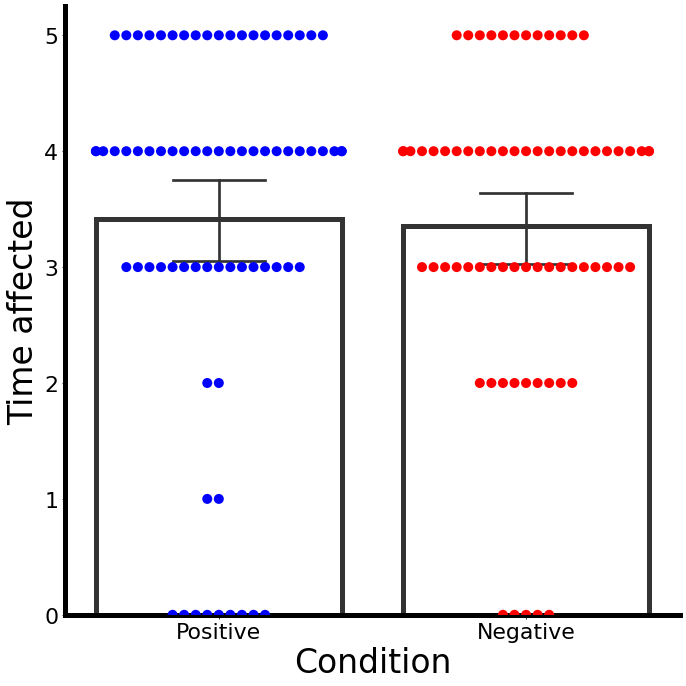

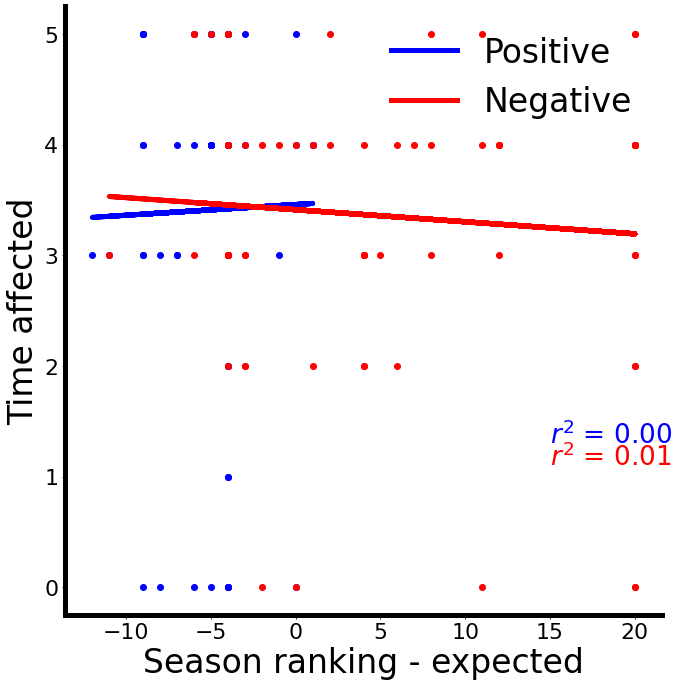

In [232]:
#Time affected
dfsp['x'],dfsn['x']=x_p,x_n
dfsp['y'],dfsn['y'],dfsp['y_res'],dfsn['y_res']=y_p,y_n,residp_val,residn_val

#time affected
act_resid=2 #actual vs residual outcome
if act_resid==1:
    ystr1,ybr1='y','Season ranking'
else:
    ystr1,ybr1='y_res','Season ranking - expected'
#ystr1,ybr1='For - against','For - against fandom'
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfsp[ystr2].isna()==0)[0]
qn=np.where(dfsn[ystr2].isna()==0)[0]
x1,x2=dfsp[ystr1].values,dfsn[ystr1].values
y1,y2=dfsp[ystr2].values,dfsn[ystr2].values

fn='figs/season_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

astats2(y1[qp],y2[qn],'time affected, pos vs neg')

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp].astype(int),y1[qp].astype(int),x2[qn].astype(int),y2[qn].astype(int),
         ybr1,ybr2,'figs/season_'+str(ystr1)+'_'+str(ystr2)+'.pdf',2)

kurtosis g1: -1.346, p=0.178; kurtosis g2: -2.452, p=0.014
skewness g1: -0.015, p=0.988; kurtosis g2: 0.429, p=0.668
use mann-whitney!
Time affected, plays
   meth    g1m    g1s    g2m   g2s   df    stat      p      d
0     2  3.162  0.145  2.836  0.15  139  2828.5  0.138  0.263


kurtosis g1: -2.332, p=0.02; kurtosis g2: -2.211, p=0.027
skewness g1: -0.552, p=0.581; kurtosis g2: -0.233, p=0.815
use mann-whitney!
Time affected, games
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  3.481  0.134  3.297  0.133  149  3093.5  0.346  0.157


kurtosis g1: 0.734, p=0.463; kurtosis g2: 1.542, p=0.123
skewness g1: -3.548, p=0.0; kurtosis g2: -3.225, p=0.001
use mann-whitney!
Time affected, seasons
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  3.411  0.184  3.357  0.155  141  2781.0  0.345  0.037




<ipython-input-233-e0cbf961cc24>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
<ipython-input-233-e0cbf961cc24>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat3)
<ipython-input-233-e0cbf961cc24>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat4)
<ipython-input-233-e0cbf961cc24>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat5)
<ipython-input-233-e0cbf961cc24>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat6)
/Users/jantony/opt/anaconda3/lib/pyt

kurtosis g1: -2.852, p=0.004; kurtosis g2: -0.99, p=0.322
skewness g1: 0.787, p=0.431; kurtosis g2: -1.658, p=0.097
use mann-whitney!
Emotionality, plays
   meth    g1m    g1s    g2m   g2s   df    stat    p    d
0     2  1.957  0.149 -1.959  0.14  142  5156.0  0.0  3.2


kurtosis g1: -2.573, p=0.01; kurtosis g2: -2.105, p=0.035
skewness g1: -0.594, p=0.553; kurtosis g2: 0.266, p=0.791
use mann-whitney!
Emotionality, games
   meth    g1m    g1s    g2m    g2s   df    stat    p      d
0     2  2.584  0.137 -2.446  0.137  149  5695.0  0.0  4.236


kurtosis g1: 1.144, p=0.253; kurtosis g2: -2.398, p=0.016
skewness g1: -3.596, p=0.0; kurtosis g2: 0.703, p=0.482
use mann-whitney!
Emotionality, seasons
   meth    g1m    g1s    g2m    g2s   df    stat    p      d
0     2  2.379  0.191 -2.159  0.156  175  7473.5  0.0  2.723




<ipython-input-233-e0cbf961cc24>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
<ipython-input-233-e0cbf961cc24>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat3)
<ipython-input-233-e0cbf961cc24>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat4)
<ipython-input-233-e0cbf961cc24>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat5)
<ipython-input-233-e0cbf961cc24>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat6)
/Users/jantony/opt/anaconda3/lib/pyt

kurtosis g1: -2.852, p=0.004; kurtosis g2: -0.99, p=0.322
skewness g1: 0.787, p=0.431; kurtosis g2: 1.658, p=0.097
use mann-whitney!
Absolute emotionality, plays
   meth    g1m    g1s    g2m   g2s   df    stat      p      d
0     2  1.957  0.149  1.959  0.14  142  2593.0  0.992 -0.002


kurtosis g1: -2.573, p=0.01; kurtosis g2: -2.105, p=0.035
skewness g1: -0.594, p=0.553; kurtosis g2: -0.266, p=0.791
use mann-whitney!
Absolute emotionality, games
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  2.584  0.137  2.446  0.137  149  3032.0  0.485  0.117


kurtosis g1: -4.667, p=0.0; kurtosis g2: -2.869, p=0.004
skewness g1: -2.263, p=0.024; kurtosis g2: -0.416, p=0.678
use mann-whitney!
Absolute emotionality, seasons
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  2.589  0.159  2.183  0.151  175  4622.0  0.029  0.276




/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-233-e0cbf961cc24>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat1.append(dat2)
<ipython-input-233-e0cbf961cc24>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat3)
<ipython-input-233-e0cbf961cc24>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.append(dat4)
<ipython-input-233-e0cbf961cc24>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat=dat.appe

kurtosis g1: -4.439, p=0.0; kurtosis g2: -3.286, p=0.001
skewness g1: -0.273, p=0.785; kurtosis g2: -1.506, p=0.132
use mann-whitney!
Fandom, plays
   meth  g1m    g1s   g2m    g2s   df    stat      p      d
0     2  2.5  0.126  2.73  0.123  142  2268.0  0.182 -0.218


kurtosis g1: -2.082, p=0.037; kurtosis g2: 0.794, p=0.427
skewness g1: -1.69, p=0.091; kurtosis g2: -2.694, p=0.007
use mann-whitney!
Fandom, games
   meth    g1m    g1s    g2m    g2s   df    stat      p      d
0     2  2.675  0.112  2.986  0.098  149  2370.0  0.055 -0.338


kurtosis g1: 0.3, p=0.765; kurtosis g2: 1.938, p=0.053
skewness g1: -2.333, p=0.02; kurtosis g2: -2.764, p=0.006
use mann-whitney!
Fandom, seasons
   meth   g1m    g1s    g2m    g2s   df    stat      p      d
0     2  2.89  0.087  3.096  0.077  172  3290.5  0.103 -0.267




/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-p

kurtosis g1: 5.011, p=0.0; kurtosis g2: 5.568, p=0.0
skewness g1: 6.653, p=0.0; kurtosis g2: 7.366, p=0.0
use mann-whitney!
# re-viewings, plays
   meth     g1m    g1s    g2m    g2s   df    stat    p      d
0     2  27.271  4.526  10.73  2.084  142  3995.5  0.0  0.563


kurtosis g1: 6.952, p=0.0; kurtosis g2: 7.073, p=0.0
skewness g1: 9.245, p=0.0; kurtosis g2: 9.545, p=0.0
use mann-whitney!
# re-viewings, games
   meth     g1m    g1s    g2m    g2s   df    stat    p      d
0     2  11.579  2.823  3.932  1.414  148  4227.0  0.0  0.392


kurtosis g1: 7.584, p=0.0; kurtosis g2: 5.522, p=0.0
skewness g1: 10.592, p=0.0; kurtosis g2: 7.315, p=0.0
use mann-whitney!
# re-viewings, seasons
   meth     g1m     g1s    g2m    g2s   df    stat    p      d
0     2  29.988  12.125  8.757  2.146  156  4167.5  0.0  0.259




/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-

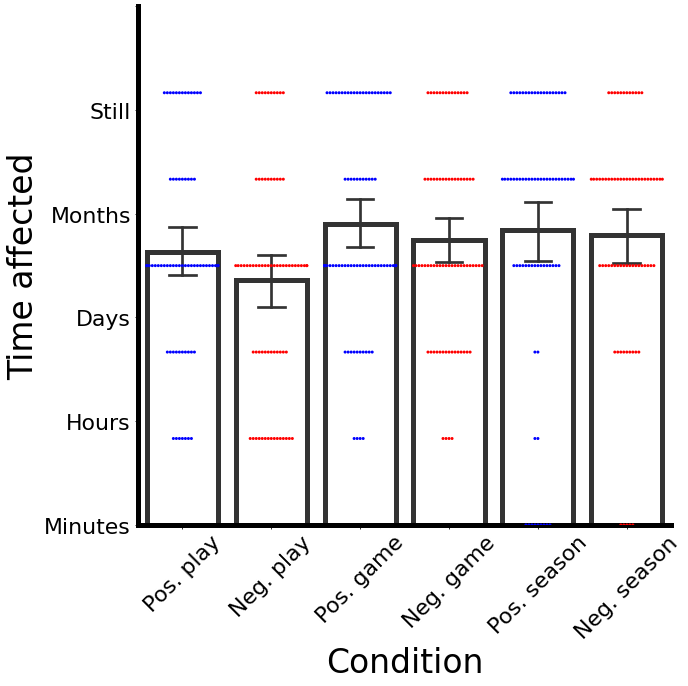

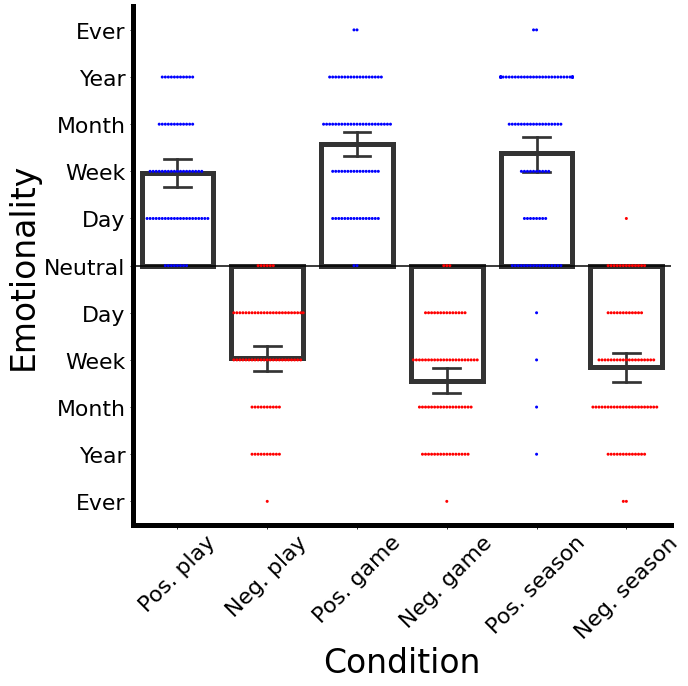

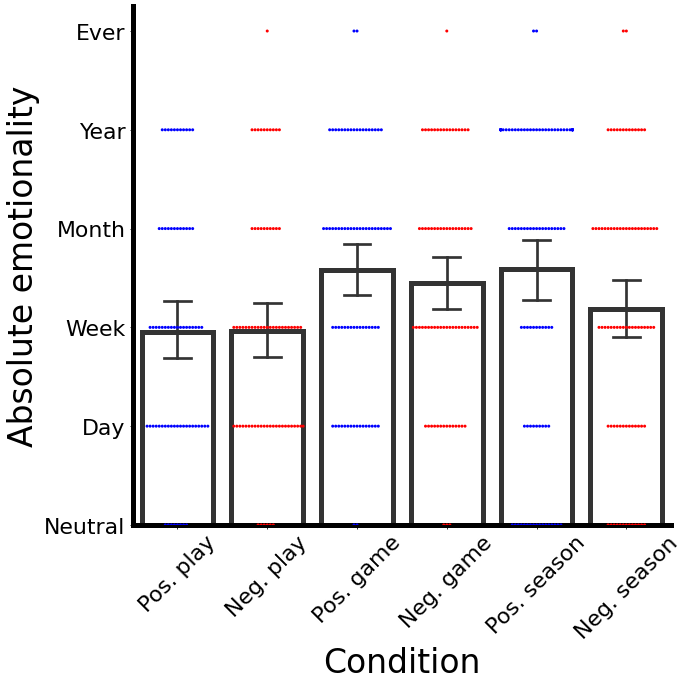

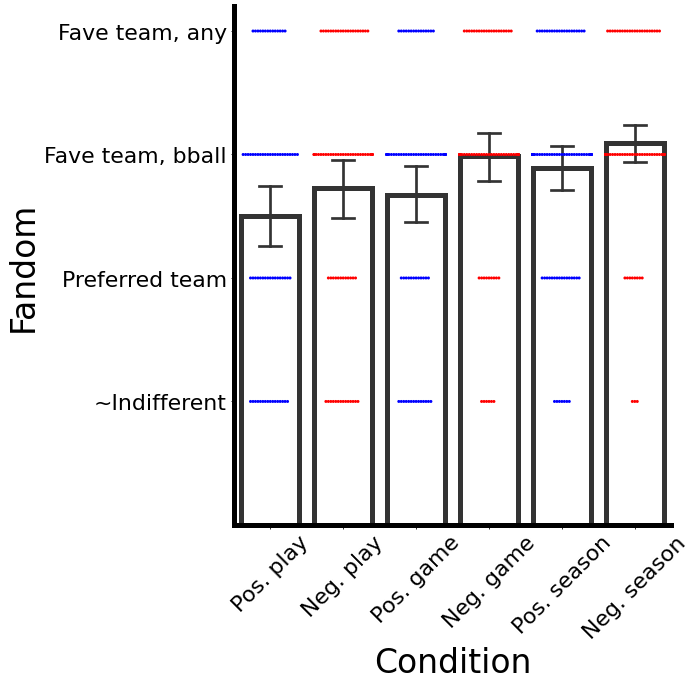

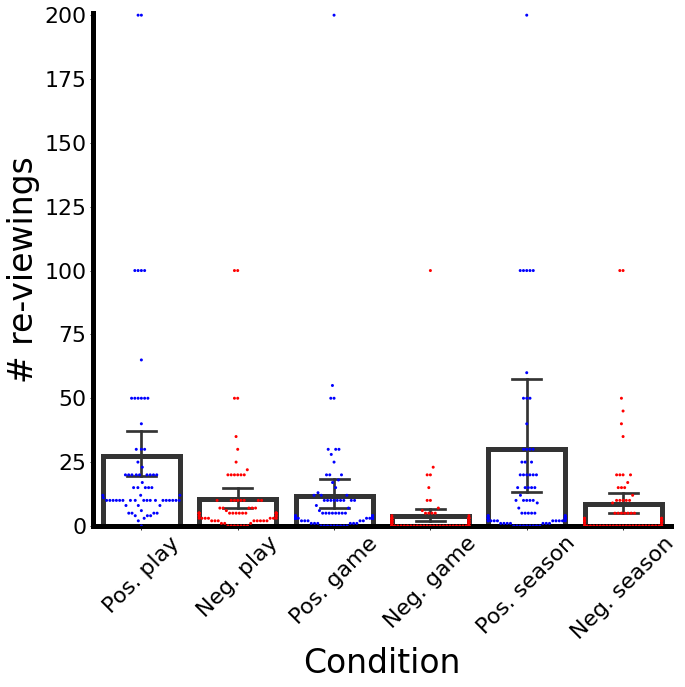

In [233]:
def barswarm_a(dp,dn,dgp,dgn,dsp,dsn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Pos. play']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Neg. play']*len(dn),lab:dn})
    dat3=pd.DataFrame({'Condition':['Pos. game']*len(dgp),lab:dgp})
    dat4=pd.DataFrame({'Condition':['Neg. game']*len(dgn),lab:dgn})
    dat5=pd.DataFrame({'Condition':['Pos. season']*len(dsp),lab:dsp})
    dat6=pd.DataFrame({'Condition':['Neg. season']*len(dsn),lab:dsn})
    dat=dat1.append(dat2)
    dat=dat.append(dat3)
    dat=dat.append(dat4)
    dat=dat.append(dat5)
    dat=dat.append(dat6)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors=["blue","red","blue","red","blue","red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    if exv==4:
        ax=sns.barplot(x=dat['Condition'],y=np.absolute(dat[lab]),facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    else:
        ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    ax.tick_params(axis='x', rotation=45)
    ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],facecolor=None,palette=cp,size=msz//3)
    ax.hlines(0,-0.5,5.5,color="black")
    ax.set_ylabel(yl,fontsize=fs)
    if exv==0:
        ax.set_yticks(np.linspace(0,6,6))
        ax.set_yticklabels(['Minutes','Hours','Days','Months','Still'])
    elif exv==1:
        ax.set_yticks(np.linspace(-5,5,11))
        ax.set_yticklabels(['Ever','Year','Month','Week','Day','Neutral','Day','Week','Month','Year','Ever']) 
    elif exv==2:
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['~Indifferent','Preferred team','Fave team, bball','Fave team, any']) 
    elif exv==3:
        ax.set_ylim([0,201])
    elif exv==4:
        ax.set_yticks(np.linspace(0,5,6))
        ax.set_yticklabels(['Neutral','Day','Week','Month','Year','Ever']) 
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.tight_layout()
    f.savefig(fn, transparent=True)

#time affected by play, game, season
def consol(ystr2,ybr2,exv2):
    #play
    qp=np.where(dfp[ystr2].isna()==0)[0]
    qn=np.where(dfn[ystr2].isna()==0)[0]
    y1,y2=dfp[ystr2].values,dfn[ystr2].values
    if exv2==4:
        y1,y2=np.absolute(dfp[ystr2].values),np.absolute(dfn[ystr2].values)
    astats2(y1[qp],y2[qn],'%s, plays' %ybr2)
    #game
    qgp=np.where(dfgp[ystr2].isna()==0)[0]
    qgn=np.where(dfgn[ystr2].isna()==0)[0]
    y1g,y2g=dfgp[ystr2].values.astype(int),dfgn[ystr2].values.astype(int)
    if exv2==4:
        y1g,y2g=np.absolute(dfgp[ystr2].values.astype(int)),np.absolute(dfgn[ystr2].values.astype(int))
    astats2(y1g[qgp],y2g[qgn],'%s, games' %ybr2)
    #season
    qsp=np.where(dfsp[ystr2].isna()==0)[0]
    qsn=np.where(dfsn[ystr2].isna()==0)[0]
    y1sz,y2sz=dfsp[ystr2].values,dfsn[ystr2].values
    y1s,y2s=y1sz[qsp].astype(int),y2sz[qsn].astype(int)
    if exv2==4:
        y1s,y2s=np.absolute(y1s),np.absolute(y2s)
    astats2(y1s,y2s,'%s, seasons' %ybr2)
    fn='figs/all_'+str(ybr2)+'.pdf'
    barswarm_a(y1[qp],y2[qn],y1g[qgp],y2g[qgn],y1s,y2s,ybr2,ybr2,fn,exv2)

ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
consol(ystr2,ybr2,0)
ystr2='Overall emotionality w/r/t life (-5 to 5) (Day, Week, Month, Year, Ever)'
ybr2='Emotionality'
consol(ystr2,ybr2,1)
ybr2='Absolute emotionality'
consol(ystr2,ybr2,4)
ystr2,ybr2='How big a fan?','Fandom'
consol(ystr2,ybr2,2)
ystr2,ybr2='# re-viewings?','# re-viewings'
consol(ystr2,ybr2,3)